# Anti-Hater Filter for Social Networks

In recent years, online content moderation has become a critical challenge for many platforms facing an increasing volume of potentially harmful comments. These comments can include insults, threats, obscene content, or hate speech. Manual moderation is ineffective at scale, and traditional algorithms often fail to capture the complexity and variety of offensive language.

**The Problem to Solve**

The company **TechTalk**, a forum for technology enthusiasts, has found that a significant number of comments posted in community threads contain hate speech and insults that compromise the quality of discussions. Users have reported that, due to its growing popularity, the platform struggles to manage the flow of harmful comments using traditional moderation tools. **TechTalk** has turned to **DeepCortex AI Solutions** to implement an automated moderation solution based on Deep Learning that can filter toxic comments in real-time.

**DeepCortex AI Solutions** has decided to develop an advanced system based on Deep Learning technologies to automate and improve the moderation process. At the heart of the project is a deep learning model featuring **recurrent layers**, designed to classify comments into multiple toxicity categories.

**Use Case**

**Real-world scenario:** Mario Rossi, community manager at TechTalk, handles the manual moderation of user-generated content daily. With the increase in platform traffic, Mario can no longer manually manage the volume of harmful comments and must find a way to automatically filter offensive, threatening, or obscene comments without slowing down the user experience.

---

**Technical Model Requirements**

* **Task:** Multi-label classification of comments into 6 categories:
1. Toxic
2. Severely Toxic
3. Obscene
4. Threat
5. Insult
6. Identity Hate


* **Dataset:** A dataset of 160,000 comments will be provided, with each comment labeled in one or more of the categories above. Comments may have zero or more active labels.
* **Architecture:** The model must include **recurrent layers** (e.g., LSTM or GRU) to handle the sequential nature of textual comments.
* **Output:** At the inference level, for each comment, the model must produce a vector of 6 elements (one for each label) with binary values (0 or 1), where 1 indicates the presence of the corresponding label and 0 its absence.

---

**Project Phases**

**1. Data Preprocessing**

* Textual comments must be converted into numerical sequences (tokenization).
* Data must be normalized and balanced to ensure all toxicity categories are represented fairly.

**2. Model Development**

* The deep learning model will be based on a recurrent architecture capable of capturing long-term dependencies between words in comments.
* Recurrent layers (LSTM or GRU) will be implemented for the multi-label classification task.

**3. Model Training**

* The dataset will be split into training, validation, and test sets.
* Advanced optimization techniques will be used to improve model convergence.

**4. Inference and Prediction**

* During inference time, for each comment, the model will return a 6-element vector of 0s or 1s, depending on the presence of toxicity in one or more of the predicted categories.

**5. Validation**

* The model will be evaluated using metrics such as **Accuracy**, **F1-score** for each category, and **Global Precision** in predicting multiple labels.

---

**Added Value**

* **Automation:** The model will significantly reduce the manual moderation workload, allowing TechTalk to handle a larger number of comments in real-time while maintaining a safe environment for users.
* **Efficiency:** By using recurrent layers, the model will better capture the context and nuances of textual comments, improving prediction accuracy compared to traditional methods.
* **Scalability:** Once implemented, the system will be easily scalable to handle growing volumes of data, adapting to the increasing number of users and comments on the platform.
* **Integration:** The solution will be integrated directly into TechTalk's commenting system, making automatic filtering immediately operational without negatively impacting user experience.

**Dataset**

The dataset can be downloaded from this link:

[Filter_Toxic_Comments_dataset.csv](https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv)

## Import

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import time
import json
from tqdm import tqdm
from collections import Counter
import pickle

import os
import requests
import zipfile
import sys
import random
import contractions

import emoji
import html
import unicodedata

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

# Sklearn packages
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, hamming_loss
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.feature_selection import mutual_info_classif

from scipy.sparse import hstack, csr_matrix
from scipy import stats



# RNN packages tensorflow, keras
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from keras import ops
from keras.models import Model
from keras.layers import TextVectorization, Input, Embedding, LSTM, GRU, Dense, Bidirectional
from keras.layers import SpatialDropout1D, GlobalMaxPooling1D, Concatenate, BatchNormalization, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.metrics import AUC


## Functions

In [4]:
def count_uppercase(text):
    '''
    Counts the number of uppercase characters in a given text.
    @param text: The input text to analyze.
    '''
    if not isinstance(text, str):
        return 0
    return sum(1 for char in text if char.isupper())

In [5]:
def plot_multi_bar(count_series, perc_series, title, figsize=(10, 6)):
    '''
    Plots a multi-bar chart with two y-axes: one for count and one for percentage.
    @param count_series: A pandas Series containing the count values for each category.
    @param perc_series: A pandas Series containing the percentage values for each category.
    @param title: The title of the plot.
    '''
    w, h = figsize
    base_font_size = min(w, h)
    title_size = base_font_size * 2
    label_size = base_font_size * 1.5
    tick_size = base_font_size * 1.2
    bar_label_size = base_font_size * 1.3
    legend_size = base_font_size * 1.5
    
    categories = count_series.index
    x = np.arange(len(categories))
    width = 0.35
    fig, ax1 = plt.subplots(figsize=figsize)

    # first axes - count
    barre1 = ax1.bar(x - width/2 - 0.05, count_series, width, 
                    label='Count', color='#3498db', edgecolor='white')

    ax1.set_ylabel('Sum', color='#3498db', fontsize=label_size, fontweight='bold')
    ax1.set_ylim(0, max(count_series)*1.2)
    ax1.tick_params(axis='y', labelcolor='#3498db', labelsize=tick_size)
    ax1.grid(axis='y', linestyle='--', alpha=0.3) 
    ax1.bar_label(barre1, padding=3, color='#3498db', fontsize=bar_label_size)

    # second axes - percentage
    ax2 = ax1.twinx()
    barre2 = ax2.bar(x + width/2 + 0.05, perc_series, width, 
                    label='Percentage', color='#e67e22', edgecolor='white')
    ax2.set_ylabel('Percentage (%)', color='#e67e22', fontsize=label_size, fontweight='bold')
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='#e67e22', labelsize=tick_size)
    ax2.bar_label(barre2, padding=3, color='#e67e22', fontsize=bar_label_size, fmt='%.2f%%')

    # legend
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', frameon=True, fontsize=legend_size)

    plt.title(title, fontsize=title_size, pad=20)
    plt.tight_layout()
    plt.show()

In [6]:
def normalize_unicode(text):
    return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')

def remove_html(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

def replace_urls_emails(text):
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return url_pattern.sub(r'url', text)

def clean_spacing(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'\n+', ' ', text)  
    return text.strip() 

def base_clean(text):
    text = normalize_unicode(text)
    text = remove_html(text)
    text = replace_urls_emails(text)
    text = clean_spacing(text)
    return text

def get_number_tokens(text):
    text = base_clean(text)
    return len(text.split())

In [7]:
def print_label_distribution(y, name):
    df_dist = pd.DataFrame(y, columns=labels_df.columns)
    print(f"\n{name} - Distribution:")
    print(df_dist.sum())
    print(f"Positive Percentage: {(y.sum(axis=1) > 0).mean()*100:.2f}%")

## Load Data

In [8]:
dataset_path ="https://proai-datasets.s3.eu-west-3.amazonaws.com/Filter_Toxic_Comments_dataset.csv"
dataset = pd.read_csv(dataset_path)

In [9]:
dataset.head()

comment_text  toxic  severe_toxic  \
0  Explanation\nWhy the edits made under my usern...      0             0   
1  D'aww! He matches this background colour I'm s...      0             0   
2  Hey man, I'm really not trying to edit war. It...      0             0   
3  "\nMore\nI can't make any real suggestions on ...      0             0   
4  You, sir, are my hero. Any chance you remember...      0             0   

   obscene  threat  insult  identity_hate  sum_injurious  
0        0       0       0              0              0  
1        0       0       0              0              0  
2        0       0       0              0              0  
3        0       0       0              0              0  
4        0       0       0              0              0

## Global parameters

In [10]:
MAX_LEN = 128
VOCAB_SIZE = 20000

# EDA

In [11]:
dataset.info()

<class 'pandas.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   comment_text   159571 non-null  str  
 1   toxic          159571 non-null  int64
 2   severe_toxic   159571 non-null  int64
 3   obscene        159571 non-null  int64
 4   threat         159571 non-null  int64
 5   insult         159571 non-null  int64
 6   identity_hate  159571 non-null  int64
 7   sum_injurious  159571 non-null  int64
dtypes: int64(7), str(1)
memory usage: 9.7 MB


## Labels distribution

In [12]:
count_sum_inj = dataset["sum_injurious"].value_counts()
count_perc_inj = count_sum_inj/len(dataset) * 100

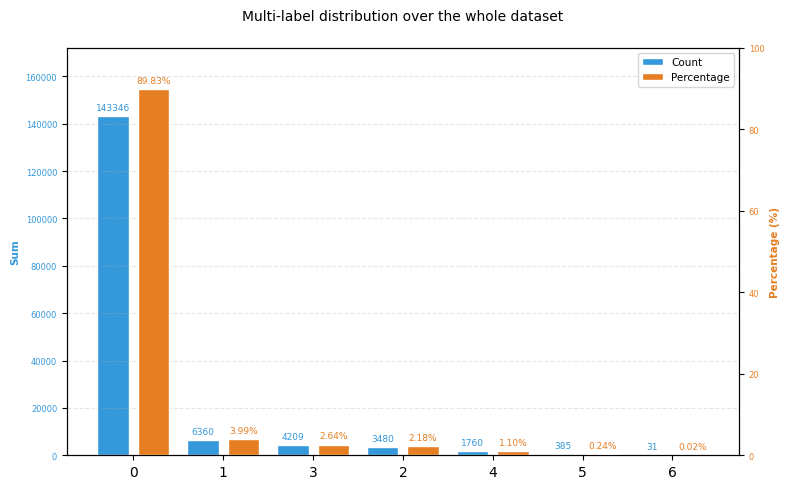

In [13]:
plot_multi_bar(count_sum_inj, 
               count_perc_inj, 
               'Multi-label distribution over the whole dataset',
               figsize=(8,5))

In [14]:
count_labels = dataset.drop(columns=['sum_injurious', 'comment_text']).sum(axis=0)
percent_labels = count_labels/len(dataset) * 100

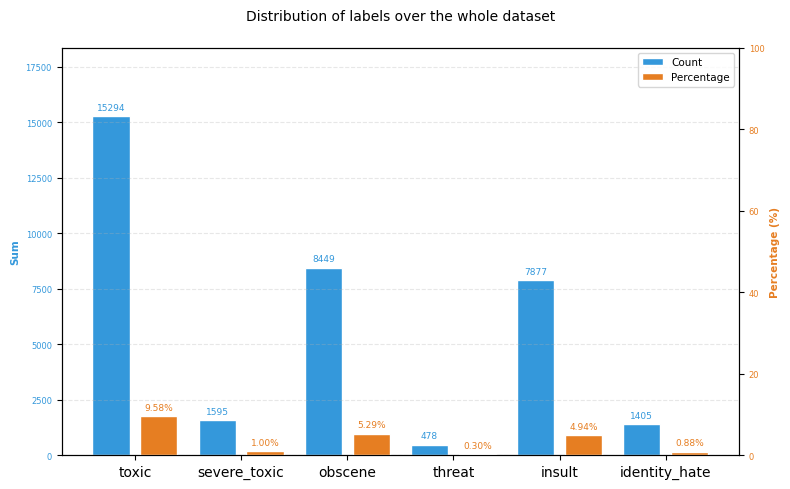

In [15]:
plot_multi_bar(count_labels, percent_labels, 
               'Distribution of labels over the whole dataset',
               figsize=(8,5))

## Co-occurence labels analysis

In [16]:
# co-occurence matrix
labels_df = dataset.drop(columns=['sum_injurious', 'comment_text'])
co_occurrence_matrix = labels_df.T.dot(labels_df)

In [17]:
LABEL_NAMES = labels_df.columns.to_list()

In [18]:
# co-occurence matrix normalized on the total count of each label by column
tot_labels_count = np.diag(co_occurrence_matrix) 
cond_prob_matrix = co_occurrence_matrix.div(tot_labels_count, axis=1)

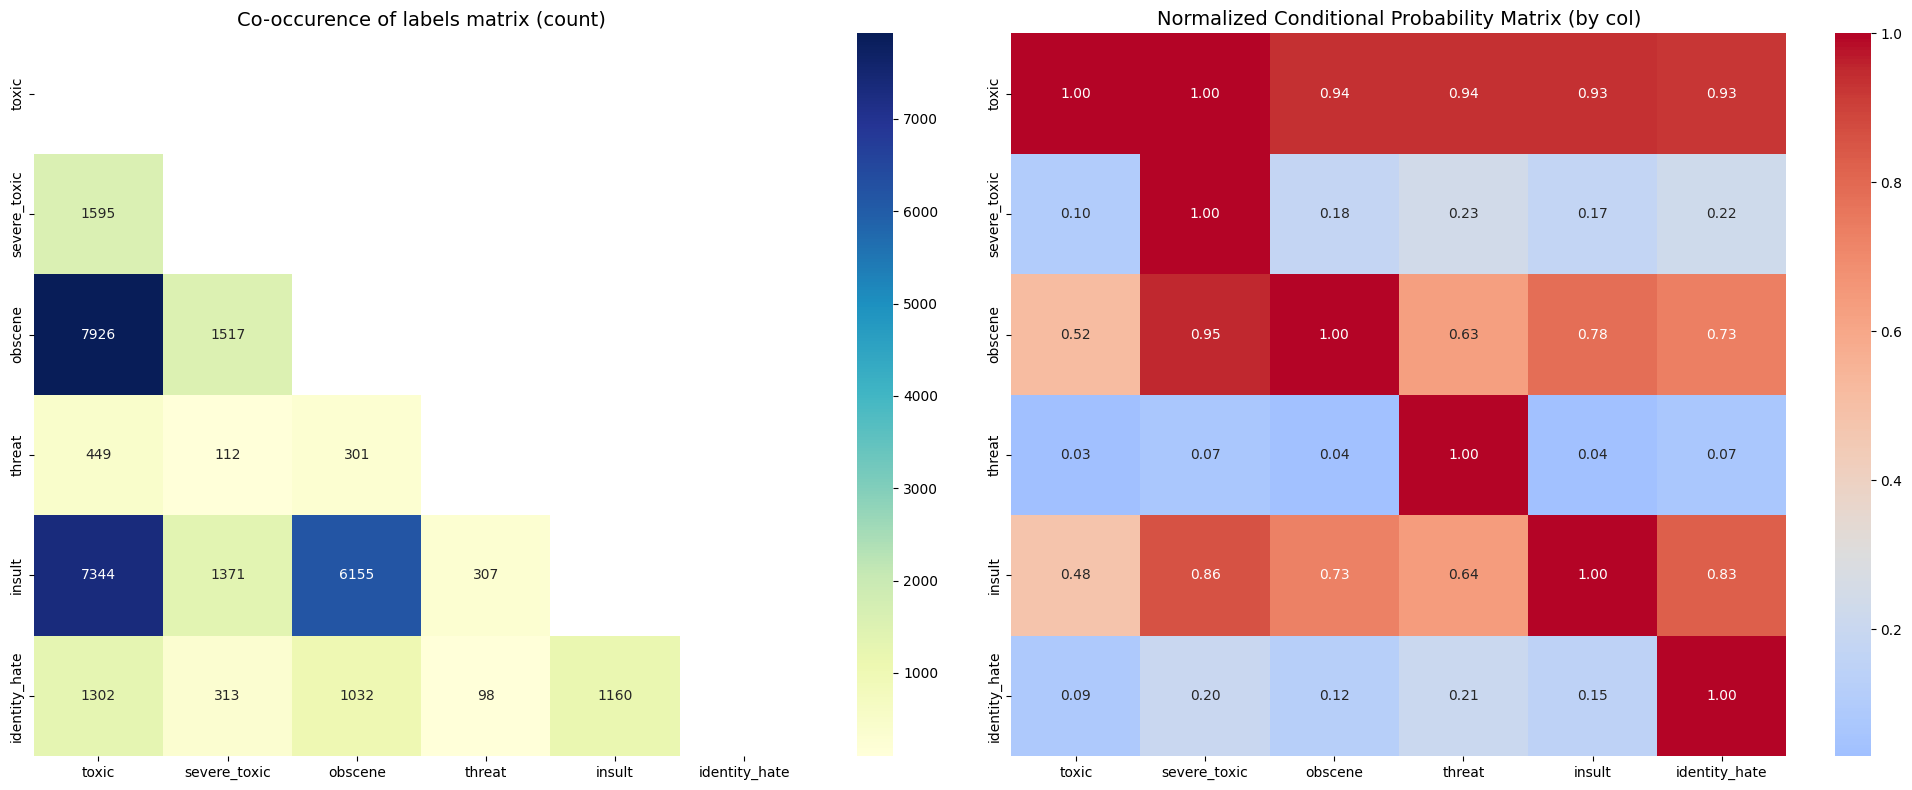

In [19]:
# plots co-occurence of labels
mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
sns.heatmap(co_occurrence_matrix, annot=True, fmt='d', cmap='YlGnBu', mask=mask, )
plt.title('Co-occurence of labels matrix (count)', fontsize=14)

plt.subplot(1,2,2)
sns.heatmap(cond_prob_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0.3)
plt.title('Normalized Conditional Probability Matrix (by col)', fontsize=14)

plt.tight_layout()
plt.show();

💡 **Observation**

- **IMBALANCE**: Most of the comments ($89 \%$) in the dataset have no hate label, so we have non hate-hate comment ratio of $8,9$.
- The *sum_injurious* feature explain the information about how many labels are true for the record $[0;6]$
- The most common label in the hate comments is *toxic* (in almost all hate comments), followed by *obscene* and *insult*. The labels *severe_toxic*, *threat* and *identity_hate* have less than $1%$ of representation in the dataset.

We can see from the heatmap (especially from the normalized one) how the labels appear in co-occurence:
- almost all hate comments are labeled *toxic*, so every other label has a very high co-occurence probability with that label (all over 93%)
- comments *toxic*: 48% are also *insult* and 52% are also *obscene*
- comments *severe_toxic*: 86% are also *insult* and 95% are also *obscene*
- comments *obscene*: 73% are also *insult*
- comments *threat*: 74% are also *insult* and 63% are also *obscene*
- comments *insult*: 78% are also *obscene* 
- comments *identity_hate*: 83% are also *insult* and 73% are also *obscene*

## Case sensitivity

In [20]:
# Count uppercase characters
dataset['num_uppercase'] = dataset['comment_text'].apply(count_uppercase)

In [21]:
# Create a binary 'hate' column based on 'sum_injurious'
dataset['hate'] = dataset['sum_injurious'].apply(lambda x: 1 if x > 0 else 0)

In [22]:
# Calculate mean number of uppercase characters for each label
df_uppercase_labels = pd.DataFrame(columns=['uppercase_mean'])
for col in labels_df.columns:
    mean = dataset.groupby(col)['num_uppercase'].mean()
    df_uppercase_labels.loc[col] = mean[1]
    
df_uppercase_labels

uppercase_mean
toxic               44.190859
severe_toxic       154.927273
obscene             50.508818
threat              76.297071
insult              49.329821
identity_hate       72.030605

In [23]:
# Calculate mean number of uppercase characters for non-hate comments
non_hate_uppercase_mean = dataset[dataset['hate'] == 0]['num_uppercase'].mean()

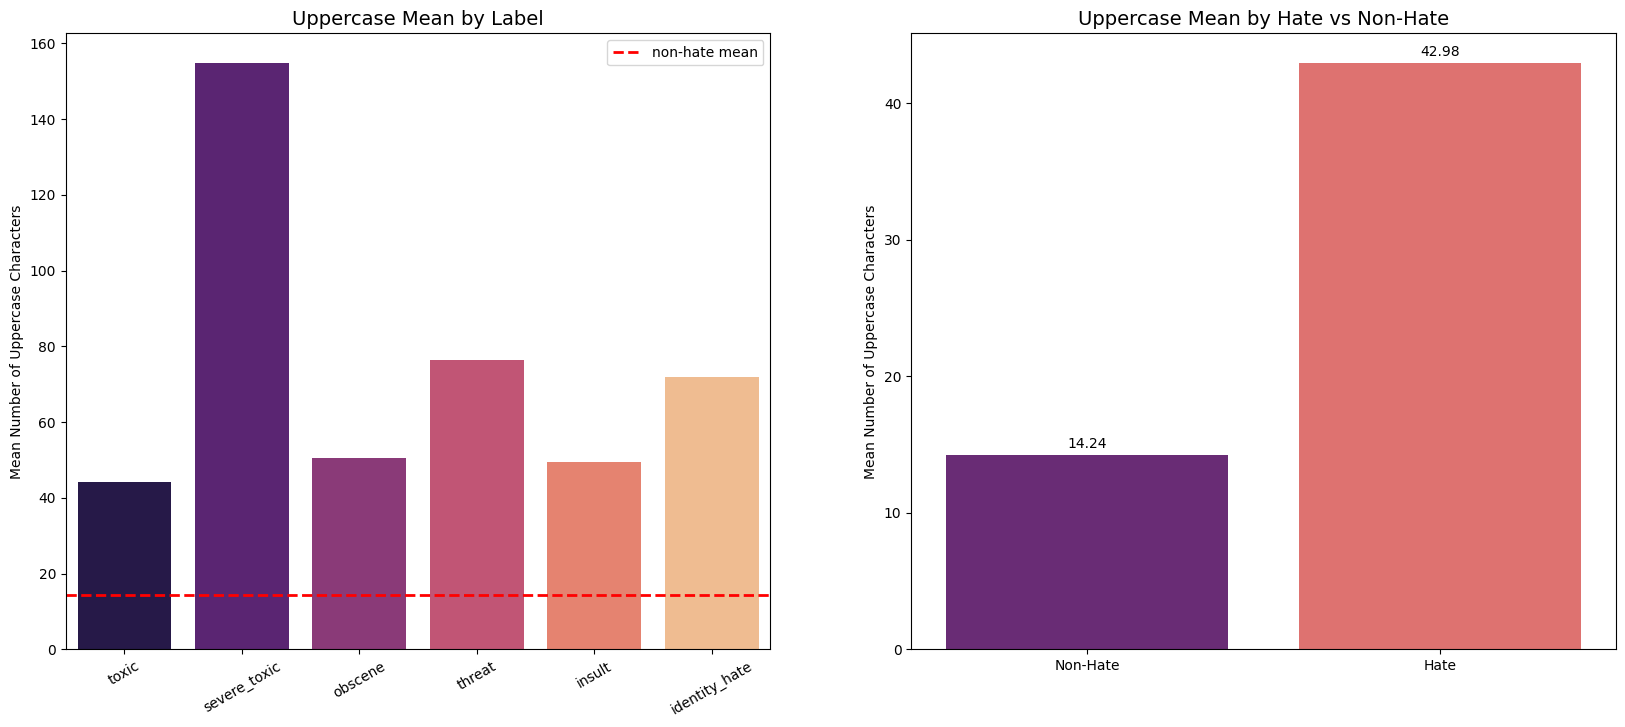

In [24]:
# Plot mean number of uppercase characters
plt.figure(figsize=(20, 8))

plt.subplot(1,2,1)
sns.barplot(data=df_uppercase_labels, 
            x=df_uppercase_labels.index, y='uppercase_mean', hue=df_uppercase_labels.index,
            estimator='mean', errorbar=None,
            palette='magma')

plt.title('Uppercase Mean by Label', fontsize=14)
plt.xticks(rotation=30)
plt.xlabel(None)
plt.ylabel('Mean Number of Uppercase Characters')
plt.axhline(y=non_hate_uppercase_mean, 
            color='red', 
            linestyle='--', 
            linewidth=2, 
            label='non-hate mean')
plt.legend()

plt.subplot(1,2,2)
sns.barplot(data=dataset[['num_uppercase', 'hate']], 
            x='hate', y='num_uppercase', hue='hate',
            estimator='mean', errorbar=None, legend=False,
            palette='magma')

for container in plt.gca().containers:
    plt.gca().bar_label(container, padding=3, fmt='%.2f')
plt.title('Uppercase Mean by Hate vs Non-Hate', fontsize=14)
plt.xticks(ticks=[0,1], labels=['Non-Hate', 'Hate'])
plt.xlabel(None)
plt.ylabel('Mean Number of Uppercase Characters')
plt.show();

💡 **Observation**

From the case sensitivity analysis we can say that in hate comments the mean of uppercase characters is very higher (43 vs 14). 

Looking at the hate comments we can see the mean distribution by label of the uppercase characters and concluding that *severe_toxic* has the highest value (154) and after there are *threat* and *identity_hate* (76, 72), the others are close to the mean of the entire group.

This analysis let us know that the uppercase count can give an information to the model about the prediction of the label.

## Length Analysis 

In [25]:
dataset['text_char_length'] = dataset['comment_text'].apply(lambda x: len(str(x)))

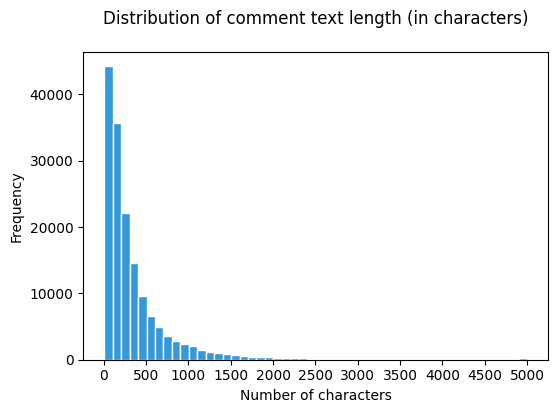

In [26]:
# Plot distribution of comment text length in characters
dataset['text_char_length'].plot(kind="hist", bins=50, figsize=(6, 4), color="#3498db", edgecolor='white')
plt.title('Distribution of comment text length (in characters)', pad=20)
plt.xticks(np.arange(0, dataset['text_char_length'].max()+1, 500))
plt.xlabel('Number of characters')
plt.show()

In [27]:
# apply simple tokenization for length analysis
dataset['tokens_number'] = dataset['comment_text'].apply(get_number_tokens)

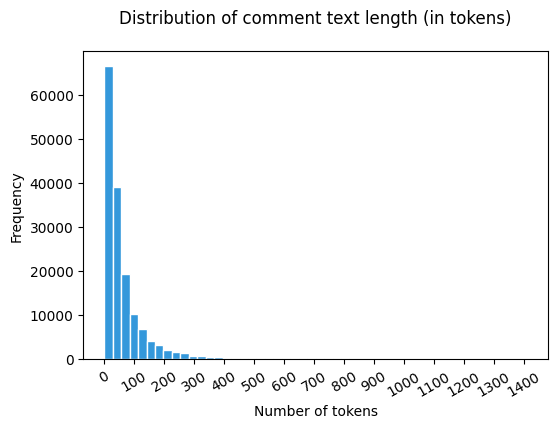

In [28]:
# Plot distribution of comment text length in tokens
dataset['tokens_number'].plot(kind="hist", bins=50, figsize=(6, 4), color="#3498db", edgecolor='white')
plt.title('Distribution of comment text length (in tokens)', pad=20)
plt.xticks(np.arange(0, dataset['tokens_number'].max()+1, 100), rotation=30)
plt.xlabel('Number of tokens')
plt.show()

In [29]:
# % of comments over 1000 characters and over 200 tokens
len_over_k_char = dataset[dataset['text_char_length'] > 1000].shape[0]
len_over_k_tokens = dataset[dataset['tokens_number'] > 200].shape[0]
print(f"Number of comments with more than 1000 characters: {len_over_k_char/dataset.shape[0]*100:.2f}%")
print(f"Number of comments with more than 200 tokens: {len_over_k_tokens/dataset.shape[0]*100:.2f}%")

Number of comments with more than 1000 characters: 8.37%
Number of comments with more than 200 tokens: 6.32%


In [30]:
# stats distribution of comments' length 
dataset[['text_char_length', 'tokens_number']].describe().transpose()

count        mean         std  min   25%    50%    75%  \
text_char_length  159571.0  394.073221  590.720282  6.0  96.0  205.0  435.0   
tokens_number     159571.0   67.267229   99.208728  0.0  17.0   36.0   75.0   

                     max  
text_char_length  5000.0  
tokens_number     1411.0

💡 **Observation**

- The average length of the comment text is *394 characters* and *67 tokens*
- 50% of the comments have less than *205 characters* and *36 tokens*
- 75% of the comments have les than *435 characters* and *75 tokens*
- There are also some longer comments:
    - with over 1000 characters only 8%
    - with over 200 tokens 6%

To better capture the semantic meaning and relationship of the text we will select models and algorithms that works well with short texts.

# Preprocess

## Dataset division

- Train 70%
- Validation 15%
- Test 15%

Stritified to mantain the proportion of the labels distribution

In [31]:
# prepare data for splitting
texts = dataset['comment_text'].values
labels = labels_df.values

# split Train vs (Val+Test)
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
train_idx, temp_idx = next(msss.split(texts, labels))

X_train = texts[train_idx]
y_train = labels[train_idx]

X_temp = texts[temp_idx]
y_temp = labels[temp_idx]

print(f"\nTrain size: {len(X_train)} ({len(X_train)/len(texts)*100:.1f}%)")
print(f"Temp (Val+Test) size: {len(X_temp)} ({len(X_temp)/len(texts)*100:.1f}%)")


# split (Val+Test) → Val e Test
msss2 = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(msss2.split(X_temp, y_temp))

X_val = X_temp[val_idx]
y_val = y_temp[val_idx]

X_test = X_temp[test_idx]
y_test = y_temp[test_idx]

print(f"Val size: {len(X_val)} ({len(X_val)/len(texts)*100:.1f}%)")
print(f"Test size: {len(X_test)} ({len(X_test)/len(texts)*100:.1f}%)")


Train size: 111699 (70.0%)
Temp (Val+Test) size: 47872 (30.0%)
Val size: 23936 (15.0%)
Test size: 23936 (15.0%)


In [32]:
# stratification check
print_label_distribution(y_train, "TRAIN")
print_label_distribution(y_val, "VAL")
print_label_distribution(y_test, "TEST")


TRAIN - Distribution:
toxic            10706
severe_toxic      1116
obscene           5914
threat             335
insult            5514
identity_hate      983
dtype: int64
Positive Percentage: 10.15%

VAL - Distribution:
toxic            2294
severe_toxic      240
obscene          1267
threat             71
insult           1182
identity_hate     211
dtype: int64
Positive Percentage: 10.19%

TEST - Distribution:
toxic            2294
severe_toxic      239
obscene          1268
threat             72
insult           1181
identity_hate     211
dtype: int64
Positive Percentage: 10.21%


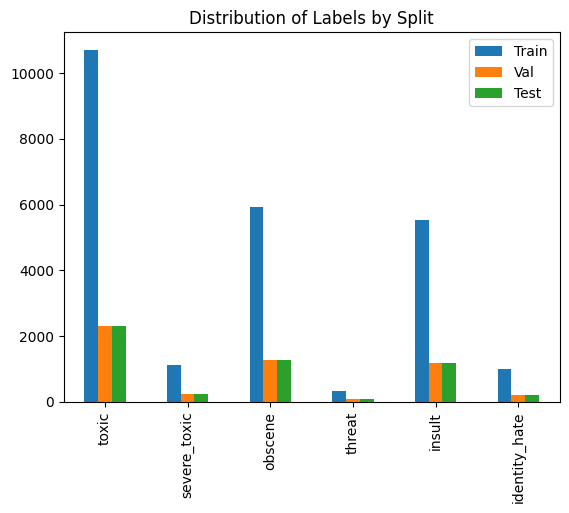

In [33]:
# bar plot distribution of labels in each split
counts = pd.DataFrame({
    'Train': y_train.sum(axis=0),
    'Val': y_val.sum(axis=0),
    'Test': y_test.sum(axis=0)
}, index=labels_df.columns)

counts.plot(kind='bar', title='Distribution of Labels by Split');

## Preprocess Class

In [34]:
class HateSpeechPreprocessor:
    """
    Text preprocessor for hate speech detection using TensorFlow TextVectorization.

    Pipeline:
    1. Cleaning: Normalizes Unicode, HTML, URLs, Mentions, Emails, and Emojis.
    2. Feature Extraction: Captures structural metadata (ratios, counts) from raw text.
    3. Vectorization: Maps cleaned text to fixed-length integer sequences.

    Attributes:
        max_len (int): Output sequence length.
        vocab_size (int): Max vocabulary size.
        padding/truncating (str): Sequence handling strategies.
        vectorizer (TextVectorization): Keras layer for tokenization.
        _is_fitted (bool): Fitting status.
    """
    def __init__(self, 
                 max_len=MAX_LEN,
                 vocab_size=20000,
                 padding='post',
                 truncating='post'):
        
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.padding = padding
        self.truncating = truncating
        
        # Initialize the TextVectorization layer
        # standardize=None because we use your custom clean_text function
        self.vectorizer = TextVectorization(
            max_tokens=vocab_size,
            output_mode='int',
            output_sequence_length=max_len,
            standardize=None 
        )
        
        self._is_fitted = False

    def clean_text(self, text):
        text = self._normalize_unicode(text)
        text = self._decode_html_entities(text)
        text = self._remove_zero_width_chars(text)
        text = self._normalize_urls(text)
        text = self._normalize_mentions(text)
        text = self._normalize_hashtags(text)
        text = self._normalize_emails(text)
        text = self._expand_contractions(text)
        text = self._handle_emoji(text)
        text = self._normalize_repetitions(text)
        text = self._normalize_punctuation(text)
        text = self._expand_punctuation(text)
        text = self._normalize_whitespace(text)
        text = text.lower().strip()
        return text

    def _normalize_unicode(self, text): return unicodedata.normalize('NFKD', text)
    def _decode_html_entities(self, text): return html.unescape(text)
    def _remove_zero_width_chars(self, text): return re.sub(r'[\u200b-\u200d\ufeff\u00ad]', '', text)
    def _normalize_urls(self, text): return re.sub(r'http\S+|www\.\S+', '<URL>', text)
    def _normalize_mentions(self, text): return re.sub(r'@\w+', '<USER>', text)
    def _normalize_hashtags(self, text): return re.sub(r'#(\w+)', r'<HASHTAG> \1', text)
    def _normalize_emails(self, text): return re.sub(r'\S+@\S+', '<EMAIL>', text)
    def _handle_emoji(self, text): return emoji.demojize(text, delimiters=('<EMOJI_', '>'))
    def _normalize_repetitions(self, text): return re.sub(r'(.)\1{2,}', r'\1\1', text)
    def _normalize_punctuation(self, text): return re.sub(r'([!?.,;:]){3,}', r'\1\1', text)
    def _expand_punctuation(self, text): return re.sub(r'([.,!?();:])', r' \1 ', text)
    def _normalize_whitespace(self, text): return re.sub(r'\s+', ' ', text)
    def _expand_contractions(self, text): return contractions.fix(text)

    def extract_auxiliary_features(self, text):
        """
        Extract auxiliary features from RAW text (before cleaning)
        """
        features = {
            'char_length': len(text),
            'word_count': len(text.split()),
            'uppercase_ratio': sum(c.isupper() for c in text) / max(len(text), 1),
            'has_all_caps': int(text.isupper() and len(text) > 0),
            'has_url': int(bool(re.search(r'http|www', text))),
            'num_mentions': len(re.findall(r'@\w+', text)),
            'num_hashtags': len(re.findall(r'#\w+', text)),
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'punctuation_ratio': sum(c in '!?.,' for c in text) / max(len(text), 1),
            'num_emoji': emoji.emoji_count(text),
            'has_emoji': int(emoji.emoji_count(text) > 0),
            'has_char_repetition': int(bool(re.search(r'(.)\1{3,}', text))),
        }
        return features

    # Fit & Transform
    def fit(self, texts, verbose=False):
        print(f"Fitting TextVectorization on {len(texts)} texts...")
        cleaned_texts = [self.clean_text(text) for text in texts]

        self.vectorizer.adapt(cleaned_texts)
        self._is_fitted = True
        
        vocab = self.vectorizer.get_vocabulary()
        if verbose:
            print(f"Vocabulary size: {len(vocab)}")
        return self

    def transform(self, texts, return_features=False):
        if not self._is_fitted:
            raise ValueError("Preprocessor not fitted! Call .fit() first.")
        
        all_features = []
        if return_features:
            for text in texts:
                all_features.append(self.extract_auxiliary_features(text))
        
        cleaned_texts = [self.clean_text(text) for text in texts]
        
        sequences = self.vectorizer(np.array(cleaned_texts)).numpy()
        
        if return_features:
            features_array = self._features_dict_to_array(all_features)
            return sequences, features_array
        
        return sequences

    def _features_dict_to_array(self, features_list):
        if not features_list: return np.array([])
        feature_names = list(features_list[0].keys())
        matrix = np.zeros((len(features_list), len(feature_names)), dtype=np.float32)
        for i, feat in enumerate(features_list):
            for j, name in enumerate(feature_names):
                matrix[i, j] = feat[name]
        return matrix

    # save & load methods
    def save(self, filepath):
        # To save TextVectorization we need to extract the weights (vocabulary)
        save_dict = {
            'config': {
                'max_len': self.max_len,
                'vocab_size': self.vocab_size,
                'padding': self.padding,
                'truncating': self.truncating,
            },
            'weights': self.vectorizer.get_weights(),
            'vocabulary': self.vectorizer.get_vocabulary(),
            'is_fitted': self._is_fitted
        }
        with open(filepath, 'wb') as f:
            pickle.dump(save_dict, f)
        print(f"✓ Preprocessor saved to {filepath}")

    @classmethod
    def load(cls, filepath):
        with open(filepath, 'rb') as f:
            save_dict = pickle.load(f)
        
        conf = save_dict['config']
        instance = cls(max_len=conf['max_len'], vocab_size=conf['vocab_size'])
        
        instance.vectorizer.adapt(np.array(save_dict['vocabulary']))
        instance.vectorizer.set_vocabulary(save_dict['vocabulary'])
        instance._is_fitted = save_dict['is_fitted']
        return instance

### Preprocess - max_len analysis

Fitting TextVectorization on 111699 texts...
Vocabulary size: 50000

✓ Preprocessing fitting with tokens' max_len = 128 complete!
The length 128 correspond to the percetile: 92.18%


count       mean        std  min   25%   50%   75%    max
0  111699.0  55.889381  41.918693  1.0  20.0  42.0  87.0  128.0

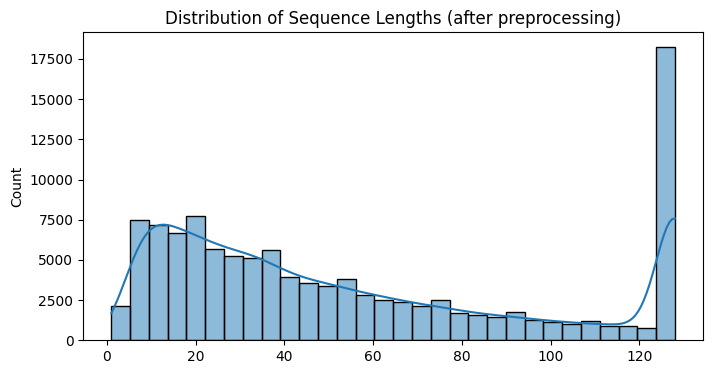

Fitting TextVectorization on 111699 texts...
Vocabulary size: 50000

✓ Preprocessing fitting with tokens' max_len = 200 complete!
The length 200 correspond to the percetile: 95.97%


count      mean        std  min   25%   50%   75%    max
0  111699.0  64.00051  58.157569  1.0  20.0  42.0  87.0  200.0

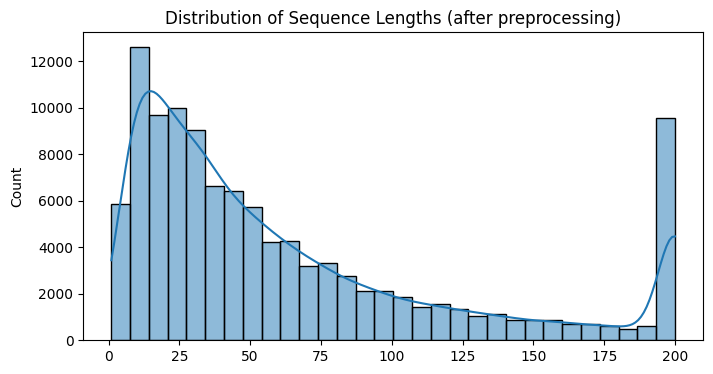

Fitting TextVectorization on 111699 texts...
Vocabulary size: 50000

✓ Preprocessing fitting with tokens' max_len = 220 complete!
The length 220 correspond to the percetile: 96.58%


count      mean       std  min   25%   50%   75%    max
0  111699.0  65.47389  61.72185  1.0  20.0  42.0  87.0  220.0

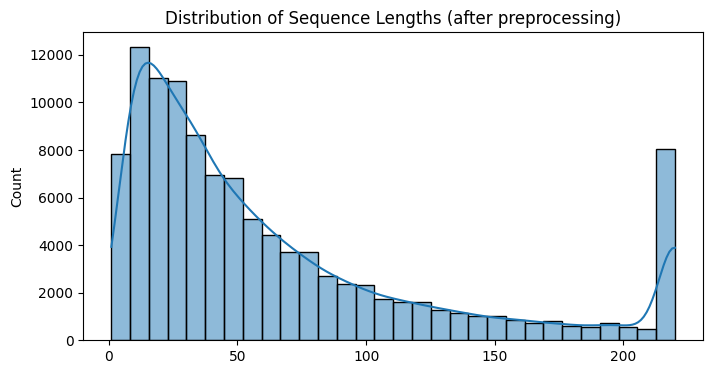

Fitting TextVectorization on 111699 texts...
Vocabulary size: 50000

✓ Preprocessing fitting with tokens' max_len = 250 complete!
The length 250 correspond to the percetile: 97.25%


count       mean        std  min   25%   50%   75%    max
0  111699.0  67.307845  66.528137  1.0  20.0  42.0  87.0  250.0

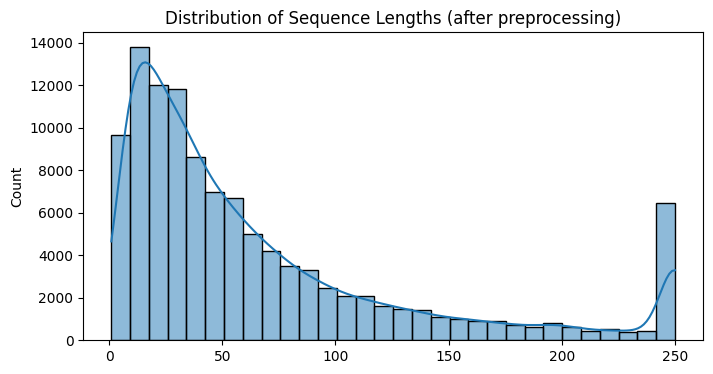

In [35]:
preps={}
for m_len in [128, 200, 220, 250]:
    
    # create the preprocessor
    preprocessor = HateSpeechPreprocessor(
        max_len=m_len,
        vocab_size=50000,
        padding='post',
        truncating='post'
    )
    preprocessor.fit(X_train, verbose=True)
    preps[str(m_len)] = preprocessor
    print(f"\n✓ Preprocessing fitting with tokens' max_len = {m_len} complete!")
    
    # calculate the series
    X_train_seq, _ = preprocessor.transform(X_train, return_features=True)
    lengths_new = (X_train_seq != 0).sum(axis=1)
    
    # percentiles & stats of the serie
    percentile = stats.percentileofscore(lengths_new, m_len)
    print(f"The length {m_len} correspond to the percetile: {percentile:.2f}%")
    display(pd.DataFrame(lengths_new).describe().transpose())
    
    # plot
    plt.figure(figsize=(8, 4))
    sns.histplot(lengths_new, bins=30, kde=True)
    plt.title("Distribution of Sequence Lengths (after preprocessing)")
    plt.show();

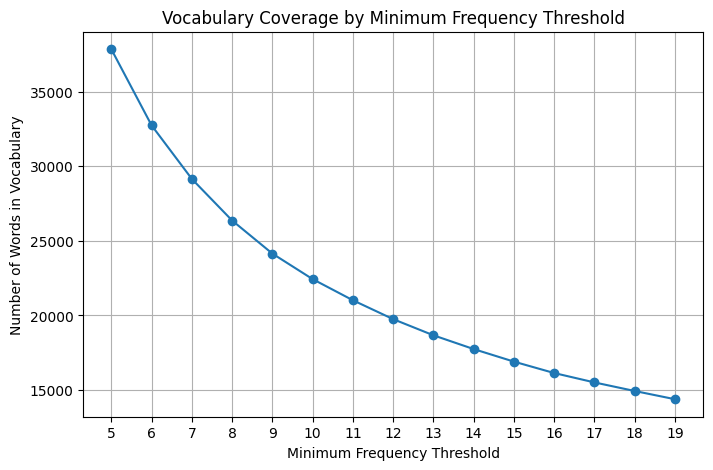

In [36]:
# after fitting analyze the vocabulary coverage by minimum frequency threshold

prep = preps['200']
word_counts = Counter()
cleaned_texts = [prep.clean_text(text) for text in X_train]
for text in cleaned_texts:
    word_counts.update(text.split())
    
sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

word_representation = {}
for min_freq in range(5, 20):
    words_above_threshold = [w for w, c in sorted_counts if c >= min_freq]
    word_representation[min_freq] = len(words_above_threshold)

plt.figure(figsize=(8, 5))
plt.plot(list(word_representation.keys()), list(word_representation.values()), marker='o')
plt.title('Vocabulary Coverage by Minimum Frequency Threshold')
plt.xlabel('Minimum Frequency Threshold')
plt.ylabel('Number of Words in Vocabulary')
plt.xticks(range(5, 20))
plt.grid()
plt.show()

💡 **Observation**

Looking at the maximum length analysis we can choose the max_len parameter on the percentile reached, and with over the 95% of the records under the 200 tokens length this can be considered a good representation.

I analyzed the dimension of minimum frequency threshold, that is the frequency that a token need to reach to be preserved. The size is choosen on 50K to take into account much more information, this graph can help to reduce the amount of words considered based on the minimum frequency of the words. The next analysis on embeddings will help with the choice.

Both max_len and vocab_size are a compromise between compute time and words representation.

## Embedding

For the embedding I chose ro use a pre-trained one due to the lack of samples in my dataset (only 160K, it's not enough to train from scratch a new one).

The best 2 alternatives that well fit my use case are:
- **GloVe**: 
    - *dimensions* -> 50/100/200/300
    - *vocabulary* -> 400K-2.2M
    - *pro* -> fast, light, good for hate speech
    - *cons* -> doesn't manage OOV word-level
- **FastText**:
    - *dimensions* -> 300
    - *vocabulary* -> 2M+ subwords
    - *pro* -> manage OOV, typo, obfuscation
    - *cons* -> heavier and slower than GloVe

In [37]:
def download_file(url, destination):
    """
    Download a file from a URL with progress bar and save to destination.
    """
    print(f"Downloading from {url}...")
    
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    
    with open(destination, 'wb') as file, tqdm(
        desc=destination,
        total=total_size,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as progress_bar:
        for data in response.iter_content(chunk_size=1024):
            size = file.write(data)
            progress_bar.update(size)
    
    print(f"✓ Downloaded to {destination}")

In [38]:
def download_embedding(embedding_name=None, embedding_dim=100, keep_zip=False):
    '''
    Download the specified embedding (FastText or GloVe) with progress bar and error handling.
    
    Args:
        embedding_name (str): "fasttext" or "glove"
        embedding_dim (int): dimension for GloVe (50, 100, 200, 300)
        keep_zip (bool): whether to keep the downloaded zip file after extraction
        
    Returns:
        file_path (str): path to the extracted embedding file
    '''
    
    output_dir = "embeddings"
    if embedding_name.lower() == "fasttext":
        url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip"
        zip_path = os.path.join(output_dir, "crawl-300d-2M.vec.zip")
        file_path = os.path.join(output_dir, "crawl-300d-2M.vec")
    elif embedding_name.lower() == "glove":
        url = "https://nlp.stanford.edu/data/glove.twitter.27B.zip"
        zip_path = os.path.join(output_dir, "glove_twitter.zip")
        file_path = os.path.join(output_dir, f"glove.twitter.27B.{embedding_dim}d.txt")
    else:
        raise ValueError("Embedding name not recognized. Use 'fasttext' or 'glove'.")
    
    os.makedirs(output_dir, exist_ok=True)

    # check if file already exists
    if os.path.exists(file_path):
        print(f"✓ Embeddings already exist at {file_path}")
        file_size_gb = os.path.getsize(file_path) / (1024**3)
        print(f"  File size: {file_size_gb:.2f} GB")
        return file_path
    
    # download .zip
    try:
        download_file(url, zip_path)
    except Exception as e:
        print(f"❌ Error downloading: {e}")
        sys.exit(1)
    
    # extract .zip
    print(f"\nExtracting {zip_path}...")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"✓ Extracted to {output_dir}")
    except Exception as e:
        print(f"❌ Error extracting: {e}")
        sys.exit(1)
    
    # remove .zip folder if not needed
    if not keep_zip:
        print(f"\nRemoving {zip_path}...")
        os.remove(zip_path)
        print("✓ Zip file removed")
    
    # file verification
    if os.path.exists(file_path):
        file_size_gb = os.path.getsize(file_path) / (1024**3)
        print(f"\n✓ Embeddings ready at {file_path}")
        print(f"  File size: {file_size_gb:.2f} GB")
        return file_path
    else:
        print(f"❌ Error: {file_path} not found after extraction")
        sys.exit(1)

In [39]:
def check_weighted_coverage(texts, embeddings_index, emb_name, verbose_oov=False):
    '''    
    Calculate the vocabulary coverage weighted by the actual frequency of the words.
    
    Args:
        texts (list of str): list of raw text samples from the dataset
        embeddings_index (dict): dictionary of word → embedding vector from GloVe
        verbose_oov (bool): whether to print detailed OOV information
    
    Returns:
        tuple: (weighted_coverage, unique_coverage, sorted_oov)
            - weighted_coverage (float): percentage of total word occurrences covered by embeddings
            - unique_coverage (float): percentage of unique words covered by embeddings
            - sorted_oov (list of tuples): list of (word, frequency) for OOV words sorted by frequency
    '''    
    # count sequence in the dataset
    word_counts = Counter()
    for text in texts:
        word_counts.update(text.split())
    
    total_words_count = sum(word_counts.values())
    unique_words = list(word_counts.keys())
    
    # identify words covered by embeddings and OOV
    covered_count = 0
    oov_counts = {}
    
    for word, count in word_counts.items():
        if word in embeddings_index:
            covered_count += count
        else:
            oov_counts[word] = count
            
    # coverage metrics
    unique_coverage = len(set(unique_words) & set(embeddings_index.keys())) / len(unique_words)
    weighted_coverage = covered_count / total_words_count
    
    print(f"--- Embedding Coverage Analysis {emb_name} ---")
    print(f"Unique words on dataset: {len(unique_words)}")
    print(f"Unique words coverage {unique_coverage:.2%}")
    print(f"Weighted coverage: {weighted_coverage:.2%}")
    
    # calculate OOV sorted by frequency
    sorted_oov = sorted(oov_counts.items(), key=lambda x: x[1], reverse=True)
    if verbose_oov:
        print("Top 30 missed words (OOV):")
        for word, freq in sorted_oov[:30]:
            print(f" - {word}: {freq} occurrences")
        
    return (weighted_coverage, unique_coverage, sorted_oov)

In [40]:
def get_embedding_index(path):
    index = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Reading embeddings..."):
            values = line.split()
            word = values[0]
            # values following the word are the coordinates of the vector
            coefs = np.asarray(values[1:], dtype='float32')
            index[word] = coefs
    return index

In [41]:
def load_embeddings(path_file, embedding_dim=None, word_index=None):
    """
    Load embeddings and create matrix for tokenizer vocabulary
    
    Args:
        path_file (str): path to the embedding file (e.g. 'embeddings/glove.twitter.27B.100d.txt')
        word_index (dict): {word: index} from Tokenizer
        embedding_dim (int): embedding dimension (for GloVe 50, 100, 200, 300, for FastText 300)
    
    Returns:
        embeddings_matrix (np.array): (vocab_size, embedding_dim)
        embeddings_index (dict): {word: embedding_vector}
        coverage (float): % of words covered by embeddings
    """
    
    print(f"Loading embedding from {path_file}...")
    
    # upload embeddings in memory
    embeddings_index = get_embedding_index(path_file)
    print(f"Loaded {len(embeddings_index)} word vectors")
    
    # create embedding matrix
    vocab_size = len(word_index) + 1  # +1 for padding (index 0)
    embeddings_matrix = np.zeros((vocab_size, embedding_dim), dtype='float32')
    
    # populate embedding matrix
    words_found = 0
    words_not_found = []
    
    for word, i in tqdm(word_index.items(), desc="Building embeddings matrix"):
        embedding_vector = embeddings_index.get(word)
        
        if embedding_vector is not None:
            # word found in embeddings
            embeddings_matrix[i] = embedding_vector
            words_found += 1
        else:
            # word NOT found in embeddings
            # random initialization
            embeddings_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
            words_not_found.append(word)
    
    # coverage stats
    coverage = words_found / len(word_index) * 100
    
    return embeddings_matrix, embeddings_index, coverage

In [42]:
def embedding_coverage_analysis(vocab_size_list, file_path, emb_name, glove_dim=100):
    '''
    Create an analysis on the embedding coverage for different vocabulary sizes.
    
    Args:
        vocab_size_list (list of int): list of vocabulary sizes to analyze
        embedding_matrix (np.array): the embedding matrix used in the model
        coverage (float): the global coverage percentage of the embedding on the dataset
        file_path (str): path to the embedding file (e.g., GloVe)
        emb_name (str): name of the embedding (e.g., "GloVe" or "FastText")
        glove_dim (int): dimension of GloVe embeddings (default 100)
        
    Returns:
        results (list of dict): each dict contains analysis results for a specific vocabulary size
    '''
    
    results = []
    for vs in vocab_size_list:
        
        preprocessor = HateSpeechPreprocessor(
            max_len=MAX_LEN,
            vocab_size=vs,
            padding='post',
            truncating='post'
        )
        preprocessor.fit(X_train)

        vocab_list = preprocessor.vectorizer.get_vocabulary()
        word_index = {word: i for i, word in enumerate(vocab_list)}
        
        if emb_name.lower() == "glove":
            embedding_dim = glove_dim
        elif emb_name.lower() == "fasttext":
            embedding_dim = 300
        else:
            raise ValueError("Embedding name not recognized. Use 'fasttext' or 'glove'.")
        
        embeddings_matrix, embeddings_index, coverage = load_embeddings(
            path_file=file_path,
            word_index=word_index,
            embedding_dim=embedding_dim
            )

        vocab_size = embeddings_matrix.shape[0]
        embedding_dim = embeddings_matrix.shape[1]

        cleaned_texts = [preprocessor.clean_text(t) for t in X_train]
        weighted_coverage, unique_coverage, sorted_oov = check_weighted_coverage(cleaned_texts, embeddings_index, emb_name)
        
        print(f"Vocabulary Size: {vocab_size}")
        print(f"Embedding Dimension: {embedding_dim}")
        print(f"Embedding Coverage: {coverage:.2f}% of the vocabulary")
        print(f"Dictionary created: {len(embeddings_index)} words uploaded.")
        
        oov_analysis = {
            "embedding_name": emb_name,
            "vocab_size": vocab_size,
            "global_coverage": coverage,
            "weighted_coverage": weighted_coverage,
            "unique_coverage": unique_coverage,
            "sorted_oov": sorted_oov
        }
        
        print("="*50)
        
        results.append(oov_analysis)
        
    return results

### GloVe

In [43]:
#glove_file = download_embedding(embedding_name="GloVe", embedding_dim=100, keep_zip=False) review
glove_file = "embeddings/glove.twitter.27B.100d.txt"

### Fast Text

In [44]:
# fasttext_file = download_embedding(embedding_name="FastText", keep_zip=False) review
fasttext_file = "embeddings/crawl-300d-2M.vec" # review

### Embedding Coverage Analysis

In [45]:
glove_data_coverage = embedding_coverage_analysis(vocab_size_list=[20000, 30000, 50000], file_path=glove_file, emb_name="GloVe")
glove_df = pd.DataFrame(glove_data_coverage)
display(glove_df)

Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/glove.twitter.27B.100d.txt...


Reading embeddings...: 1193514it [00:21, 56035.10it/s]


Loaded 1193514 word vectors


Building embeddings matrix: 100%|██████████| 20000/20000 [00:00<00:00, 556528.39it/s]


--- Embedding Coverage Analysis GloVe ---
Unique words on dataset: 217229
Unique words coverage 32.07%
Weighted coverage: 94.87%
Vocabulary Size: 20001
Embedding Dimension: 100
Embedding Coverage: 85.00% of the vocabulary
Dictionary created: 1193514 words uploaded.
Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/glove.twitter.27B.100d.txt...


Reading embeddings...: 1193514it [00:21, 56134.52it/s]


Loaded 1193514 word vectors


Building embeddings matrix: 100%|██████████| 30000/30000 [00:00<00:00, 471526.18it/s]


--- Embedding Coverage Analysis GloVe ---
Unique words on dataset: 217229
Unique words coverage 32.07%
Weighted coverage: 94.87%
Vocabulary Size: 30001
Embedding Dimension: 100
Embedding Coverage: 79.33% of the vocabulary
Dictionary created: 1193514 words uploaded.
Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/glove.twitter.27B.100d.txt...


Reading embeddings...: 1193514it [00:20, 57675.97it/s]


Loaded 1193514 word vectors


Building embeddings matrix: 100%|██████████| 50000/50000 [00:00<00:00, 454269.21it/s]


--- Embedding Coverage Analysis GloVe ---
Unique words on dataset: 217229
Unique words coverage 32.07%
Weighted coverage: 94.87%
Vocabulary Size: 50001
Embedding Dimension: 100
Embedding Coverage: 68.86% of the vocabulary
Dictionary created: 1193514 words uploaded.


embedding_name  vocab_size  global_coverage  weighted_coverage  \
0          GloVe       20001        84.995000           0.948667   
1          GloVe       30001        79.333333           0.948667   
2          GloVe       50001        68.864000           0.948667   

   unique_coverage                                         sorted_oov  
0         0.320652  [("", 9709), (2, 4014), (1, 3861), (3, 3009), ...  
1         0.320652  [("", 9709), (2, 4014), (1, 3861), (3, 3009), ...  
2         0.320652  [("", 9709), (2, 4014), (1, 3861), (3, 3009), ...

In [46]:
fasttext_data_coverage = embedding_coverage_analysis(vocab_size_list=[20000, 30000, 50000], file_path=fasttext_file, emb_name="FastText")
fasttext_df = pd.DataFrame(fasttext_data_coverage)
display(fasttext_df)

Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/crawl-300d-2M.vec...


Reading embeddings...: 1999996it [01:46, 18801.53it/s]


Loaded 1999996 word vectors


Building embeddings matrix: 100%|██████████| 20000/20000 [00:00<00:00, 358348.16it/s]


--- Embedding Coverage Analysis FastText ---
Unique words on dataset: 217229
Unique words coverage 42.12%
Weighted coverage: 96.67%
Vocabulary Size: 20001
Embedding Dimension: 300
Embedding Coverage: 89.38% of the vocabulary
Dictionary created: 1999996 words uploaded.
Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/crawl-300d-2M.vec...


Reading embeddings...: 1999996it [01:27, 22826.23it/s]


Loaded 1999996 word vectors


Building embeddings matrix: 100%|██████████| 30000/30000 [00:00<00:00, 365616.52it/s]


--- Embedding Coverage Analysis FastText ---
Unique words on dataset: 217229
Unique words coverage 42.12%
Weighted coverage: 96.67%
Vocabulary Size: 30001
Embedding Dimension: 300
Embedding Coverage: 84.36% of the vocabulary
Dictionary created: 1999996 words uploaded.
Fitting TextVectorization on 111699 texts...
Loading embedding from embeddings/crawl-300d-2M.vec...


Reading embeddings...: 1999996it [01:27, 22784.66it/s]


Loaded 1999996 word vectors


Building embeddings matrix: 100%|██████████| 50000/50000 [00:00<00:00, 294843.22it/s]


--- Embedding Coverage Analysis FastText ---
Unique words on dataset: 217229
Unique words coverage 42.12%
Weighted coverage: 96.67%
Vocabulary Size: 50001
Embedding Dimension: 300
Embedding Coverage: 76.08% of the vocabulary
Dictionary created: 1999996 words uploaded.


embedding_name  vocab_size  global_coverage  weighted_coverage  \
0       FastText       20001        89.380000           0.966674   
1       FastText       30001        84.356667           0.966674   
2       FastText       50001        76.084000           0.966674   

   unique_coverage                                         sorted_oov  
0         0.421168  [("", 9709), (<url>, 5303), (""the, 1938), (<h...  
1         0.421168  [("", 9709), (<url>, 5303), (""the, 1938), (<h...  
2         0.421168  [("", 9709), (<url>, 5303), (""the, 1938), (<h...

💡 **Observation**

Having to make a choice on which embeddings to use, the coverage analysis showed that with a lot less vocabulary size (20k vs 30k and 50k) we get the same weighted coverage. Fast Text is a little bit higher in Global Coverage, that's why we are going to use this with a vocab_size of 20k. 

## Utility functions

### Class Weights

In [47]:
def compute_multilabel_class_weights_sqrt(y_train, label_names=LABEL_NAMES):
    """
    Formula square root: more balanced
    """
    weights = {}
    
    for i, label in enumerate(label_names):
        n_pos = y_train[:, i].sum()
        n_neg = len(y_train) - n_pos
        
        weight_pos = np.sqrt(n_neg / n_pos) if n_pos > 0 else 1.0
        
        weights[label] = {'neg': 1.0, 'pos': float(weight_pos)}
        
        print(f"{label}: pos={n_pos} ({n_pos/len(y_train)*100:.2f}%), "
              f"weight_pos={weight_pos:.2f}")
    
    return weights

In [48]:
def weighted_binary_crossentropy(weights_dict, label_names=LABEL_NAMES):
    '''
    Create weighted binary crossentropy loss for multi-label classification.
    
    Applies per-class weights to handle imbalanced datasets. Works with sigmoid
    activation outputs (probabilities), not logits.
    
    Args:
        weights_dict (dict): mapping labels to weights, format:
                     {label: {'neg': 1.0, 'pos': pos_weight}}
        label_names (list):  Ordered list of label names matching model output order
    
    Returns:
        Loss function compatible with model.compile(loss=...)
    '''
    pos_weights = np.array([weights_dict[label]['pos'] for label in label_names], dtype='float32')
    pos_weights_tensor = tf.constant(pos_weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        bce = -(y_true * tf.math.log(y_pred) + (1.0 - y_true) * tf.math.log(1.0 - y_pred))
        
        weights = y_true * pos_weights_tensor + (1.0 - y_true) * 1.0
        weighted_bce = bce * weights
        
        return tf.reduce_mean(weighted_bce)
    
    return loss

### Metrics

In [49]:
def get_per_label_metrics(y_true, y_pred, y_proba, label_names=LABEL_NAMES):
    '''
    Calculate the metrics by label of a prediction model
    
    Args:
        y_true (np.array): vector with real labels
        y_pred (np.array): binarized array of predicted labels
        y_proba (np.array): vector with probabilities for each label
        label_names (list)
        
    Return:
        metrics (pd.DataFrame)
    '''
    metrics_list = []
    
    # Precision, Recall, F1 for each label
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)
    
    for i, name in enumerate(label_names):
        # ROC-AUC by label i
        roc_auc = roc_auc_score(y_true[:, i], y_proba[:, i])
        pr_auc = average_precision_score(y_true[:, i], y_proba[:, i])
        
        metrics_list.append({
            'Label': name,
            'Precision': precision[i],
            'Recall': recall[i],
            'F1-Score': f1[i],
            'ROC-AUC': roc_auc,
            'PR-AUC': pr_auc
        })
    
    return pd.DataFrame(metrics_list)

In [50]:
def get_global_metrics(y_true, y_pred, y_proba):
    '''    
    Calculate the global metrics of a prediction model
    
    Macro and Micro for F1 score, ROC-AUC, PR-AUC, hamming loss, subset accuracy 
    
    Args:
        y_true (np.array): vector with real labels
        y_pred (np.array): binarized array of predicted labels
        y_proba (np.array): vector with probabilities for each label
        
    Return:
        metrics (dict)    
    '''
    metrics = {
        'F1_Macro': f1_score(y_true, y_pred, average='macro'),
        'F1_Micro': f1_score(y_true, y_pred, average='micro'),
        'ROC_AUC_Macro': roc_auc_score(y_true, y_proba, average='macro'),
        'ROC_AUC_Micro': roc_auc_score(y_true, y_proba, average='micro'),
        'PR_AUC_Macro': average_precision_score(y_true, y_proba, average='macro'),
        'PR_AUC_Micro': average_precision_score(y_true, y_proba, average='micro'),
        'Hamming_Loss': hamming_loss(y_true, y_pred),
        'Subset_Accuracy': accuracy_score(y_true, y_pred)
    }
    return metrics

In [51]:
def plot_pr_curves(y_true, y_proba, label_names=LABEL_NAMES, figsize=(10, 7)):
    '''
    Plot the Precision-Recall curve for each label
    
    Args:
        y_true (np.array): vector with real labels
        y_proba (np.array): vector with probabilities for each label
        label_names (list)
        figsize (tuple)
    '''
    plt.figure(figsize=figsize)
    
    for i, name in enumerate(label_names):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_proba[:, i])
        ap_score = average_precision_score(y_true[:, i], y_proba[:, i])
        
        plt.plot(recall, precision, label=f'{name} (AP = {ap_score:.2f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves by Label')
    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

### Learning Curve

In [52]:
def plot_learning_curves_with_diagnosis(history, metrics=None, figsize=(15, 8), save_path=None):
    """
    Plot of Learning Curves and Automatic Diagnosis of overfitting/underfitting
    
    Args:
        history of the model
        metrics (list): to plot
        save_path (str)
        figsize (tuple)
        
    Return:
        figure
        overfitting value (float)
    """
    
    # get history
    if hasattr(history, 'history'):
        history_dict = history.history
    else:
        history_dict = history
    
    available_metrics = [k for k in history_dict.keys() if not k.startswith('val_')]
    
    if metrics is None:
        metrics = available_metrics
    else:
        metrics = [m for m in metrics if m in available_metrics]
    
    n_metrics = len(metrics)
    
    # create figure with space for diagnosis
    fig = plt.figure(figsize=figsize)
    
    # Subplot for metrics
    for idx, metric in enumerate(metrics):
        ax = plt.subplot(2, n_metrics, idx + 1)
        
        train_values = history_dict[metric]
        epochs = range(1, len(train_values) + 1)
        
        ax.plot(epochs, train_values, 'b-o', label=f'Train', 
                linewidth=2, markersize=4, alpha=0.8)
        
        val_metric = f'val_{metric}'
        if val_metric in history_dict:
            val_values = history_dict[val_metric]
            ax.plot(epochs, val_values, 'r-s', label=f'Val', 
                    linewidth=2, markersize=4, alpha=0.8)
            
            if metric == 'loss':
                best_epoch = np.argmin(val_values) + 1
                best_value = np.min(val_values)
            else:
                best_epoch = np.argmax(val_values) + 1
                best_value = np.max(val_values)
            
            ax.axvline(x=best_epoch, color='g', linestyle='--', alpha=0.5)
            ax.plot(best_epoch, best_value, 'g*', markersize=15)
        
        ax.set_title(f'{metric.upper()}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.grid(True, alpha=0.3)
        ax.legend(loc='best')
    
    # automatic diagnosis
    diagnosis_ax = plt.subplot(2, 1, 2)
    diagnosis_ax.axis('off')
    
    # loss analysis for diagnosis
    if 'loss' in history_dict and 'val_loss' in history_dict:
        train_loss = history_dict['loss']
        val_loss = history_dict['val_loss']
        
        final_train_loss = train_loss[-1]
        final_val_loss = val_loss[-1]
        min_val_loss = min(val_loss)
        best_epoch = np.argmin(val_loss) + 1
        
        # Gap between train and val
        gap = final_val_loss - final_train_loss
        gap_percent = (gap / final_train_loss) * 100
        
        # diagnosis
        diagnosis_text = "=== AUTOMATIC DIAGNOSIS ===\n\n"
        
        # convergence
        if final_train_loss < 0.01:
            diagnosis_text += "✓ CONVERGENCE: Excellent (very low train loss)\n"
        elif final_train_loss < 0.05:
            diagnosis_text += "✓ CONVERGENCE: Good\n"
        else:
            diagnosis_text += "⚠ CONVERGENCE: Could benefit from more epochs or different LR\n"
        
        # overfitting
        if gap_percent > 50:
            diagnosis_text += f"❌ OVERFITTING: SEVERE (gap train-val: {gap_percent:.1f}%)\n"
            diagnosis_text += "   → Tips: increase dropout, use regularization, more data\n"
        elif gap_percent > 20:
            diagnosis_text += f"⚠ OVERFITTING: Moderate (gap: {gap_percent:.1f}%)\n"
            diagnosis_text += "   → Consider: higher dropout, more aggressive early stopping\n"
        elif gap_percent > 10:
            diagnosis_text += f"✓ OVERFITTING: Slight (gap: {gap_percent:.1f}%) - Acceptable\n"
        else:
            diagnosis_text += f"✓ OVERFITTING: Minimum (gap: {gap_percent:.1f}%) - Excellent!\n"
        
        # early stopping
        epochs_after_best = len(val_loss) - best_epoch
        if epochs_after_best > 5:
            diagnosis_text += f"⚠ EARLY STOPPING: You could stop {epochs_after_best} epochs before (epoch {best_epoch})\n"
        elif epochs_after_best > 0:
            diagnosis_text += f"✓ EARLY STOPPING: It worked (stop {epochs_after_best} epochs after best)\n"
        else:
            diagnosis_text += "⚠ EARLY STOPPING: Model could benefit from more epochs\n"
        
        # trend validation loss
        last_5_val = val_loss[-5:]
        if all(last_5_val[i] <= last_5_val[i-1] for i in range(1, len(last_5_val))):
            diagnosis_text += "✓ TREND VAL_LOSS: Constantly improving\n"
        elif all(last_5_val[i] >= last_5_val[i-1] for i in range(1, len(last_5_val))):
            diagnosis_text += "❌ TREND VAL_LOSS: Constantly worsening (overfitting in progress)\n"
        else:
            diagnosis_text += "○ TREND VAL_LOSS: Stable/fluctuating\n"
        
        # final stats
        diagnosis_text += f"\n=== STATISTICHE ===\n"
        diagnosis_text += f"Best Val Loss: {min_val_loss:.6f} (epoca {best_epoch})\n"
        diagnosis_text += f"Final Train Loss: {final_train_loss:.6f}\n"
        diagnosis_text += f"Final Val Loss: {final_val_loss:.6f}\n"
        diagnosis_text += f"Epochs total: {len(train_loss)}\n"
        
        # print diagnosis
        diagnosis_ax.text(0.05, 0.95, diagnosis_text, 
                         transform=diagnosis_ax.transAxes,
                         fontsize=10, verticalalignment='top',
                         fontfamily='monospace',
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    plt.suptitle('Learning Curves & Diagnosis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved in: {save_path}")
    
    plt.show()
    
    return fig, gap_percent

### Confusion matrix

In [53]:
def confusion_matrix_2x3(y_pred, label_names=LABEL_NAMES, figsize=(10,6), title=''):
    '''
    Show a subplot (2x3) with the confusion matrix for each label
    '''
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    for i, label in enumerate(label_names):
        ax = axes[i]
        
        # calculate the confusion matrix for the current label
        cm = confusion_matrix(y_val[:, i], y_pred[:, i])
        
        # heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
        ax.set_title(f'{label}', fontsize='small', fontweight='bold')
        ax.set_xlabel('Predicted', fontsize='small')
        ax.set_ylabel('True', fontsize='small')
        ax.set_xticks([0.5, 1.5])
        ax.set_xticklabels(['0', '1'])
        ax.set_yticks([0.5, 1.5])
        ax.set_yticklabels(['0', '1'], va='center')
        
    title = 'Confusion Matrix' + '\n' + title
    fig.suptitle(title, fontsize='small', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

### Evaluate Model

In [54]:
def evaluate_model(model, X_val, y_val, threshold=0.5, label_names=LABEL_NAMES, pr_curve=True, conf_matrix=True):
    """
    Evaluate a model on the multi-label classification on the validation set
    
    Args:
        model: Keras model
        X_val (np.array): validation sequences
        y_val (np.array): validation labels (n_samples, 6)
        threshold (float, list): for binarization (default 0.5)
        labels_names (list)
    
    Returns:
        results (dict): with all the metrics calculated
    """
    
    # Predici probabilità
    y_pred_proba = model.predict(X_val, verbose=0)
    
    # Binarizza con threshold
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Metriche globali
    global_df = get_global_metrics(y_val, y_pred, y_pred_proba)
    display(pd.DataFrame(global_df, index=[0]))
    
    f1_macro = f1_score(y_val, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_val, y_pred, average='micro', zero_division=0)
    
    precision_macro = precision_score(y_val, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_val, y_pred, average='micro', zero_division=0)
    
    recall_macro = recall_score(y_val, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_val, y_pred, average='micro', zero_division=0)
    
    roc_auc_macro = roc_auc_score(y_val, y_pred_proba, average='macro')
    roc_auc_micro = roc_auc_score(y_val, y_pred_proba, average='micro')
    
    pr_auc_macro = average_precision_score(y_val, y_pred_proba, average='macro')
    pr_auc_micro = average_precision_score(y_val, y_pred_proba, average='micro')
    
    hamming = hamming_loss(y_val, y_pred)
    subset_acc = accuracy_score(y_val, y_pred)
    
    # Metriche per-label
    labels_metrics_df = get_per_label_metrics(y_val, y_pred, y_pred_proba, label_names)
    display(labels_metrics_df)
    
    f1_per_label = f1_score(y_val, y_pred, average=None, zero_division=0)
    precision_per_label = precision_score(y_val, y_pred, average=None, zero_division=0)
    recall_per_label = recall_score(y_val, y_pred, average=None, zero_division=0)
    roc_auc_per_label = roc_auc_score(y_val, y_pred_proba, average=None)
    pr_auc_per_label = average_precision_score(y_val, y_pred_proba, average=None)
    
    

    # PR curves by label
    if pr_curve:
        plot_pr_curves(y_val, y_pred_proba, label_names, figsize=(6, 4))
        
    # Confusion matrix per label
    if conf_matrix:
        confusion_matrix_2x3(y_pred, LABEL_NAMES)
    
    results = {
        # Globali
        'f1_macro': float(f1_macro),
        'f1_micro': float(f1_micro),
        'precision_macro': float(precision_macro),
        'precision_micro': float(precision_micro),
        'recall_macro': float(recall_macro),
        'recall_micro': float(recall_micro),
        'roc_auc_macro': float(roc_auc_macro),
        'roc_auc_micro': float(roc_auc_micro),
        'pr_auc_macro': float(pr_auc_macro),
        'pr_auc_micro': float(pr_auc_micro),
        'hamming_loss': float(hamming),
        'subset_accuracy': float(subset_acc),
        
        # Per-label
        'f1_per_label': f1_per_label.tolist(),
        'precision_per_label': precision_per_label.tolist(),
        'recall_per_label': recall_per_label.tolist(),
        'roc_auc_per_label': roc_auc_per_label.tolist(),
        'pr_auc_per_label': pr_auc_per_label.tolist(),
        
        # Predictions (per analisi successiva)
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
    }
    
    return results

### Threshold optimizaton

In [55]:
def find_optimal_label_thresholds(y_true, y_proba, label_names):
    """
    Find optimal threshold for each label by maximizing F1 score on validation set.
    
    Args:
        y_true (array-like): shape (n_samples, n_labels) - true binary labels
        y_proba (array-like): shape (n_samples, n_labels) - predicted probabilities for each label
        
    Returns:
        thresholds_optimal (dict): {label_name : optimal threshold}
        thresholds_f1 (dict): label_name -> list of {threshold: f1_score} for all tested thresholds, to analyze the curve
        best_f1 (dict): {label_name : best f1 scores for each label}
    """
    thresholds_optimal = {}
    thresholds_f1 = {}
    best_f1_by_threshold = {}
    
    for i, label_name in enumerate(label_names):
        best_threshold = 0.5
        best_f1 = 0
        f1_scores = []
        
        # Test different threshold
        for threshold in np.arange(0.05, 0.95, 0.05):
            y_pred = (y_proba[:, i] > threshold).astype(int)
            f1 = f1_score(y_true[:, i], y_pred, zero_division=0)
            f1_scores.append({threshold: f1})
            
            
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold
        
        thresholds_optimal[label_name] = best_threshold
        thresholds_f1[label_name] = f1_scores
        best_f1_by_threshold[label_name] = best_f1
        print(f"{label_name}: threshold={best_threshold:.2f}, F1={best_f1:.3f}")
    
    return thresholds_optimal, thresholds_f1, best_f1_by_threshold
def merge_label_metrics_df(labels_metrics_df, labels_metrics_std_df):
    labels_metrics_std_df = labels_metrics_std_df.rename(
        columns={col: f"{col}_std" for col in labels_metrics_std_df.columns if col != 'Label'}
    )

    merged_df = pd.merge(labels_metrics_df, labels_metrics_std_df, on='Label')

    # sort the columns to have them next to each other (es. Precision near Precision_std)
    ordered_columns = ['Label']
    base_metrics = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']

    for metric in base_metrics:
        ordered_columns.append(metric)
        ordered_columns.append(f"{metric}_std")

    final_df = merged_df[ordered_columns]

    return final_df

In [56]:
def plot_threshold_label_curve(thresholds_f1, optimal_thresholds, label_names, figsize=(10,6)):
    '''
    Plot F1 score vs threshold for each label, showing standard 0.5 and optimal threshold.
    
    Args:
    - thresholds_f1 (dict): label_name -> list of dict {threshold: f1_score}
    - optimal_thresholds (dict): {label_name : optimal threshold}
    
    '''
    # create the figure with 2 rows and 3 columns
    with plt.rc_context({'axes.labelsize': 'small', 'xtick.labelsize': 'small', 'ytick.labelsize': 'small', 'axes.titlesize':'small', 'legend.fontsize':'small'}):
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        axes = axes.flatten()

        for i, label in enumerate(label_names):
            ax = axes[i] 
            
            thresholds_values = [float(k) for d in thresholds_f1[label] for k in d.keys()]
            f1_values = [float(v) for d in thresholds_f1[label] for v in d.values()]

            # Plot on the specific axes 'ax'
            ax.plot(thresholds_values, f1_values, 'b-', linewidth=2)
            ax.axvline(x=0.5, color='r', linestyle='--', label='Standard (0.5)')
            ax.axvline(x=optimal_thresholds[label], color='g', linestyle='--', 
                        label=f'Optimal ({optimal_thresholds[label]:.2f})')
            ax.set_xlabel('Threshold', fontsize='small')
            ax.set_ylabel('F1 Score', fontsize='small')
            ax.set_title(f'{label}')
            ax.legend(fontsize='small')
            ax.grid(True, alpha=0.3)

    fig.suptitle('F1 Score vs Threshold', fontsize='small', fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [57]:
def threshold_analysis(model_all_results, figure_size=(8,5)):
    '''
    Perform the threshold analysis from the model results of a specific model
    
    Show for each label the curve f1 score-threshold
    
    Show the confusion matrix and the metrics for for predictions with Optimal and Selective Threshold
    
    Args:
        model_all_results (dict): from the list of all results 
        figure_size (tuple)
        
    Return:
        thresh_array_opt (list): floats from the optimal thresholds
        thresh_array_sel (list): floats from the selective thresholds
    '''
    model_name= model_all_results['model_name']
    y_pred_proba = model_all_results['y_pred_proba']
    
    y_pred_std = (y_pred_proba > 0.5).astype(int)
    std_df = pd.DataFrame(get_global_metrics(y_val, y_pred_std, y_pred_proba), index=['std'])
    labels_metrics_std_df = get_per_label_metrics(y_val, y_pred_std, y_pred_proba, label_names=LABEL_NAMES)

    print(f"\n{'='*60}")
    print(f"THRESHOLD ANALYSIS: {model_name}")
    print(f"{'='*60}\n")
    optimal_thresholds, threshold_f1, best_f1 = find_optimal_label_thresholds(y_val, y_pred_proba, LABEL_NAMES)
    best_f1_values = [np.float32(v) for v in best_f1.values()]
    print(f"F1-Macro = {round(np.array(best_f1_values).mean(),3)}")
    plot_threshold_label_curve(threshold_f1, optimal_thresholds, LABEL_NAMES, figsize=figure_size)

    # Total Thresholding
    print(f"\n{'='*60}")
    print(f"Total Thresholding")  
    thresh_array_opt = np.array([optimal_thresholds[l] for l in LABEL_NAMES])
    title = "Total Thresholding" + " " + str(thresh_array_opt)  
    y_pred = (y_pred_proba > thresh_array_opt).astype(int)
    confusion_matrix_2x3(y_pred, LABEL_NAMES, figsize=figure_size, title=title)
    global_df = pd.DataFrame(get_global_metrics(y_val, y_pred, y_pred_proba), index=['thresh'])
    display(pd.concat([global_df, std_df], ignore_index=False))
    labels_metrics_df = get_per_label_metrics(y_val, y_pred, y_pred_proba, label_names=LABEL_NAMES)
    display(merge_label_metrics_df(labels_metrics_df, labels_metrics_std_df))

    # Selective Thresholding
    print(f"\n{'='*60}")
    print(f"Selective Thresholding")   
    thresh_array_sel = np.array([
        optimal_thresholds[l] if i in [1,3,5] else 0.5 
        for i,l in enumerate(LABEL_NAMES)
    ])
    title = "Selective Thresholding" + " " + str(thresh_array_sel) 
    y_pred = (y_pred_proba > thresh_array_sel).astype(int)
    confusion_matrix_2x3(y_pred, LABEL_NAMES, figsize=figure_size, title=title)
    global_df = pd.DataFrame(get_global_metrics(y_val, y_pred, y_pred_proba), index=['thresh'])
    display(pd.concat([global_df, std_df], ignore_index=False))
    labels_metrics_df = get_per_label_metrics(y_val, y_pred, y_pred_proba, label_names=LABEL_NAMES)
    display(merge_label_metrics_df(labels_metrics_df, labels_metrics_std_df))
    
    return thresh_array_opt, thresh_array_sel

## Configuration

In [58]:
SEED = 42
MAX_LEN = 200
VOCAB_SIZE = 20000
EMBEDDING_DIM = 300
LABEL_NAMES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [59]:
# --- Preprocessing ---
preprocessor = HateSpeechPreprocessor(
    max_len=MAX_LEN,
    vocab_size=VOCAB_SIZE,
    padding='post',
    truncating='post'
    )
preprocessor.fit(X_train, verbose=True)

Fitting TextVectorization on 111699 texts...
Vocabulary size: 20000


In [60]:
# --- Embedding ---
vocab_list = preprocessor.vectorizer.get_vocabulary()
word_index = {word: i for i, word in enumerate(vocab_list)}

embedding_matrix, _, _ = load_embeddings(
    path_file=fasttext_file,
    embedding_dim=EMBEDDING_DIM,
    word_index=word_index
)

Loading embedding from embeddings/crawl-300d-2M.vec...


Reading embeddings...: 1999996it [01:27, 22789.54it/s]


Loaded 1999996 word vectors


Building embeddings matrix: 100%|██████████| 20000/20000 [00:00<00:00, 572433.21it/s]


In [195]:
# save vocabulary after preprocessor.fit()
with open('hate_speech_vocabulary.pkl', 'wb') as f:
    pickle.dump(vocab_list, f)

print("✅ Vocabulary correctly saved.")

✅ Vocabulary correctly saved.


In [61]:
# --- Transform datasets ---
X_train_seq, X_train_feat = preprocessor.transform(X_train, return_features=True)
X_val_seq, X_val_feat = preprocessor.transform(X_val, return_features=True)
X_test_seq, X_test_feat = preprocessor.transform(X_test, return_features=True)

print(f"Train sequences shape: {X_train_seq.shape}") 
print(f"Train features shape: {X_train_feat.shape}")  
print(f"Val sequences shape: {X_val_seq.shape}")
print(f"Test sequences shape: {X_test_seq.shape}")

Train sequences shape: (111699, 200)
Train features shape: (111699, 13)
Val sequences shape: (23936, 200)
Test sequences shape: (23936, 200)


In [62]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')

# Models

In [63]:
# structures for results
total_resume_df = pd.DataFrame()
per_label_resume_df = pd.DataFrame()
all_results = []

## Benchmarck 

**Logistic Regression multi-label**: simple NLP preprocess and classifier as a baseline to compare the RNN models

Model          Label  Precision    Recall  F1-Score   ROC-AUC  \
0  Baseline_LR_TFIDF          toxic   0.647846  0.865301  0.740948  0.973084   
1  Baseline_LR_TFIDF   severe_toxic   0.299572  0.878661  0.446809  0.988197   
2  Baseline_LR_TFIDF        obscene   0.680723  0.891167  0.771858  0.985308   
3  Baseline_LR_TFIDF         threat   0.276190  0.805556  0.411348  0.985970   
4  Baseline_LR_TFIDF         insult   0.554631  0.846740  0.670241  0.979474   
5  Baseline_LR_TFIDF  identity_hate   0.239726  0.663507  0.352201  0.976351   

     PR-AUC  
0  0.860459  
1  0.442303  
2  0.883364  
3  0.510606  
4  0.772074  
5  0.430640


Global Metrics:


Model  F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  \
0  Baseline_LR_TFIDF  0.565567  0.680816       0.981397       0.984604   

   PR_AUC_Macro  PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.649908      0.788321       0.02953         0.879888

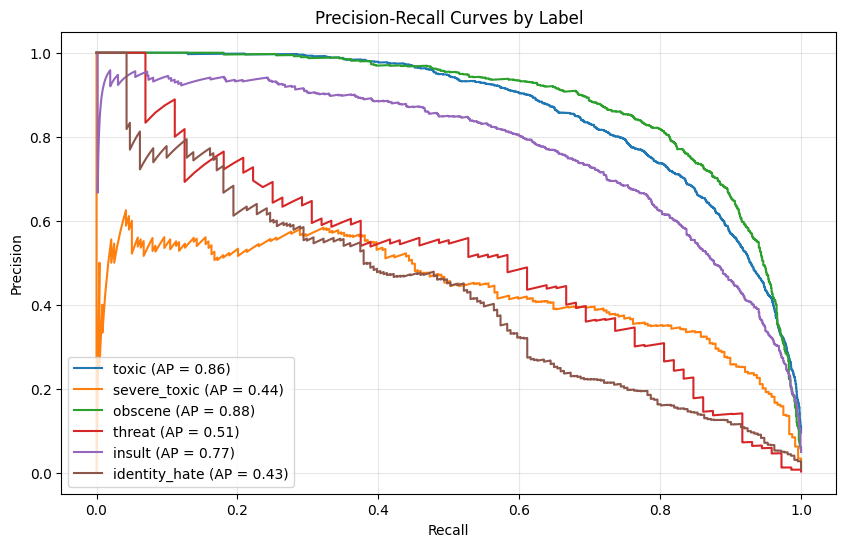

Training time: 87.9011 seconds


In [137]:
model_name = 'Baseline_LR_TFIDF'
vectorizer = TfidfVectorizer(
            max_features=50000,
            ngram_range=(1,2),
            min_df=2,
            max_df=0.95,
            sublinear_tf=True,
            strip_accents='unicode',
            analyzer='word',
            token_pattern=r'\w+',
            lowercase=True
        )
lr = LogisticRegression(
            max_iter=1000,
            C=1.0,
            solver='lbfgs',
            class_weight='balanced',
            random_state=42,
            verbose=1
        )
multi_label_lr = MultiOutputClassifier(lr, n_jobs=-1)

start_time = time.time()
cleaned_texts = [preprocessor.clean_text(text) for text in X_train]
X_tfidf = vectorizer.fit_transform(cleaned_texts)
X_tfidf_test = vectorizer.transform([preprocessor.clean_text(text) for text in X_test])

multi_label_lr.fit(X_tfidf, y_train)

y_pred = multi_label_lr.predict(X_tfidf_test)
y_proba = multi_label_lr.predict_proba(X_tfidf_test)
end_time = time.time()
labels = labels_df.columns.tolist() 
y_proba_consistent = np.column_stack([label_proba[:, 1] for label_proba in y_proba])

# calculate & print per label metrics
labels_metrics = get_per_label_metrics(y_test, y_pred, y_proba_consistent, labels)
labels_metrics.insert(loc=0, column='Model', value=model_name)
display(labels_metrics)

# calculate & print global metrics
global_metrics = pd.DataFrame(get_global_metrics(y_test, y_pred, y_proba_consistent), index=[0])
global_metrics.insert(loc=0, column='Model', value=model_name)
print("\nGlobal Metrics:")
display(global_metrics)

plot_pr_curves(y_test, y_proba_consistent, labels, figsize=(10, 6))

train_time = end_time - start_time
print(f"Training time: {train_time:.4f} seconds")

In [138]:
global_metrics.insert(3, 'ROC_AUC', global_metrics['ROC_AUC_Macro'])
global_metrics.insert(4, 'PR_AUC', global_metrics['PR_AUC_Macro'])
global_metrics = global_metrics.drop(columns=['ROC_AUC_Macro', 'ROC_AUC_Micro', 'PR_AUC_Macro', 'PR_AUC_Micro'])

In [180]:
# Saving metrics
total_resume_df = global_metrics
per_label_resume_df = labels_metrics

📊 **Consideration**:

The benchmark considers a TF-IDF word rapresentation and uses a Logistic Regression to classify the labels. As baseline we got good results considering that we're not taking care of context, semantic rapresentition, sequences that are all specific characteristics of RNN models.

About the baseline results we can assert:
- *toxic*, *obscene*, *insult* have good metrics especially on F1-score and PR-AUC, those are even the most frequent labels in the dataset (allowing the model to learn the patterns).
- *severe_toxic*, *threat*, *identity_hate* show much lower F1-scores and very low values on precision (high False Positive), behavior found also on the PR-AUC. Those are the least frenquent labels in the dataset with a representation under the 1% (rare).
- diffence in micro and macro F1 taking into account the frequency of the labels are evidence of the same problem above
- ROC-AUC is very good micro and macro, but joined with F1-scores low let us understand that the  default threshold (0,5) it's not optimal (due to the umbalance labels representation) 

## LSTM / BiLSTM

In [ ]:
def build_lstm(config, embedding_matrix):
    """
    Builder LSTM 1 Layer, with the option of adding Bidirectionality and Dropout layers. All the options are manageble from the input config dict.
    
    Args:
        config (dict): of configuration parameters with the following keys allowed:
            - max_len: input shape [default 200] of the text, token length
            - emb_dr: dropout ratio after embedding layer
            - rnn_units: units for LSTM layer [default 64]
            - rnn_dr: dropout ratio in the LSTM layer
            - recurrent_dr: recurrent dropout ratio in the LSTM layer
            - pre_output_dr: dropout ratio after LSTM layer and pre output
            - bidirectional (bool): [default False], True to add the Bidiractional layer
            - embedding_trainable (bool): [default False], True to add trainble in the embedding
            - loss_function: custom [default 'binary_crossentropy']
            - learning_rate: [default 0.001]
            - seed_value: if passed allow reproducibility in the results [default None]
        embedding_matrix (np.array): tuple (vocab_size, embedding_dim)
        
    Return:
        model (tansorflow model): after .compile

    """
    
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    # extract configuration parameters
    input_len = config.get('max_len', 200)
    emb_dropout = config.get('emb_dr', 0)
    lstm_units = config.get('rnn_units', 64)
    lstm_dropout = config.get('rnn_dr', 0)
    recurrent_dropout = config.get('recurrent_dr', 0)
    pre_output_dropout = config.get('pre_output_dr', 0)
    bidirectional = config.get('bidirectional', False)
    emb_trainable = config.get('embedding_trainable', False)
    loss_function = config.get('loss', 'binary_crossentropy')
    learning_rate = config.get('learning_rate', 0.001)
    seed_value = config.get('seed', None)
    
    # set random seeds
    if seed_value is not None:
        common_initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)
        dropout_seed = seed_value
    else:
        common_initializer = tf.keras.initializers.GlorotUniform()
        dropout_seed = None
    
    # build the RNN
    text_input = Input(shape=(input_len,), dtype='int32', name='text_input')
    
    # embedding
    x = Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=emb_trainable,
        mask_zero=True,
        name='embedding'
    )(text_input)
    
    # dropout after embedding
    if emb_dropout > 0:
        x = Dropout(emb_dropout, seed=dropout_seed)(x)

    # LSTM with dropout & recurrent dropout
    lstm_layer = LSTM(
        units=lstm_units,
        dropout=lstm_dropout,                    
        recurrent_dropout=recurrent_dropout,
        kernel_initializer=common_initializer,
        recurrent_initializer=common_initializer,
        name='lstm'
    )
    
    if bidirectional:
        x = Bidirectional(lstm_layer, name='bidirectional_lstm')(x)
    else:
        x = lstm_layer(x)
        
    # pre output dropout
    if pre_output_dropout > 0:
        x = Dropout(pre_output_dropout, seed=dropout_seed)(x)
    
    # Output
    output = Dense(6, activation='sigmoid',
                   kernel_initializer=common_initializer, 
                   name='output'
                   )(x)
    
    model = Model(inputs=text_input, outputs=output, name='LSTM')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=[
            'accuracy',
            AUC(name='auc', multi_label=True)
            ]
    )
    
    return model

## GRU / BiGRU

In [ ]:
def build_gru(config, embedding_matrix):
    """
    Builder GRU 1 Layer, with the option of adding Bidirectionality and Dropout layers. All the options are manageble from the input config dict.
    
    Args:
        config (dict): of configuration parameters with the following keys allowed:
            - max_len: input shape [default 200] of the text, token length
            - emb_dr: dropout ratio after embedding layer
            - rnn_units: units for GRU layer [default 64]
            - rnn_dr: dropout ratio in the GRU layer
            - recurrent_dr: recurrent dropout ratio in the GRU layer
            - pre_output_dr: dropout ratio after GRU layer and pre output
            - bidirectional (bool): [default False], True to add the Bidiractional layer
            - embedding_trainable (bool): [default False], True to add trainble in the embedding
            - loss_function: custom [default 'binary_crossentropy']
            - learning_rate: [default 0.001]
            - seed_value: if passed allow reproducibility in the results [default None]
        embedding_matrix (np.array): tuple (vocab_size, embedding_dim)
        
    Return:
        model (tensorflow model): after .compile

    """
    
    vocab_size = embedding_matrix.shape[0]
    embedding_dim = embedding_matrix.shape[1]
    
    # extract configuration parameters
    input_len = config.get('max_len', 200)
    emb_dropout = config.get('emb_dr', 0)
    gru_units = config.get('rnn_units', 64)
    gru_dropout = config.get('rnn_dr', 0)
    recurrent_dropout = config.get('recurrent_dr', 0)
    pre_output_dropout = config.get('pre_output_dr', 0)
    bidirectional = config.get('bidirectional', False)
    emb_trainable = config.get('embedding_trainable', False)
    loss_function = config.get('loss', 'binary_crossentropy')
    learning_rate = config.get('learning_rate', 0.001)
    seed_value = config.get('seed', None)
    
    # set random seeds
    if seed_value is not None:
        common_initializer = tf.keras.initializers.GlorotUniform(seed=seed_value)
        dropout_seed = seed_value
    else:
        common_initializer = tf.keras.initializers.GlorotUniform()
        dropout_seed = None
    
    # build the RNN
    text_input = Input(shape=(input_len,), dtype='int32', name='text_input')
    
    # embedding
    x = Embedding(
        input_dim=vocab_size, 
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=emb_trainable,
        mask_zero=True,
        name='embedding'
    )(text_input)
    
    # dropout after embedding
    if emb_dropout > 0:
        x = Dropout(emb_dropout, seed=dropout_seed)(x)

    # GRU with dropout & recurrent dropout
    gru_layer = GRU(
        units=gru_units,
        dropout=gru_dropout,                    
        recurrent_dropout=recurrent_dropout,
        kernel_initializer=common_initializer,
        recurrent_initializer=common_initializer,
        name='gru'
    )
    
    if bidirectional:
        x = Bidirectional(gru_layer, name='bidirectional_gru')(x)
    else:
        x = gru_layer(x)
        
    # pre output dropout
    if pre_output_dropout > 0:
        x = Dropout(pre_output_dropout, seed=dropout_seed)(x)
    
    # Output
    output = Dense(6, activation='sigmoid',
                   kernel_initializer=common_initializer, 
                   name='output'
                   )(x)
    
    model = Model(inputs=text_input, outputs=output, name='GRU')
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=loss_function,
        metrics=[
            'accuracy',
            AUC(name='auc', multi_label=True)
            ]
    )
    
    return model

## RNN Models comparison

In [125]:
def run_experiments(experiments, early_stopping_monitor='val_loss', pr_curve=True, conf_matrix=True):
    '''
    Function to run multiple experiments with different models and configurations, and collect results.
    
    Args:
        experiments (list of dict): each dict should contain:
            - 'name': str, name of the experiment/model
            - 'builder': function that builds and compiles the Keras model
            - 'params': dict of configuration parameters used for the model
        early_stopping_monitor (str): name of the metric to monitor for early stopping
        threshold_analysis (bool): whether to perform threshold analysis for each label
        pr_curve (bool): whether to plot PR curves for each experiment
        conf_matrix (bool): whether to plot confusion matrix for each label in each experiment
        
    Returns:
        results (list of dict): each dict contains results and metrics for the corresponding experiment
    '''
    all_results = []

    for exp in experiments  :
        print("\n" + "="*80)
        print(f"EXPERIMENT: {exp['name']}")
        print("="*80 + "\n")
        
        # Build model
        model = exp['builder']
        
        print(model.summary())
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor=early_stopping_monitor,
                patience=5,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor=early_stopping_monitor,
                factor=0.5,
                patience=2,
                min_lr=1e-6,
                verbose=1
            ),
            ModelCheckpoint(
                f"models/{exp['name']}_weights.h5",
                monitor='val_loss',
                save_best_only=True,
                mode='min',
                verbose=0
            )
        ]
        
        # Train
        start_time = time.time()
            
        history = model.fit(
            X_train_seq, y_train,
            validation_data=(X_val_seq, y_val),
            epochs=20,
            batch_size=64,
            callbacks=callbacks,
            verbose=1
        )
        
        training_time = time.time() - start_time
        
        #learning curves + diagnosis
        _, overfitting = plot_learning_curves_with_diagnosis(history, metrics=['loss', 'accuracy', 'auc'], 
                                        figsize=(18, 10), save_path=f'results/{exp["name"]}_learning_curves.png')
        
        # Evaluate
        print(f"\n{'='*60}")
        print(f"EVALUATION: {exp['name']}")
        print(f"{'='*60}\n")
        
        results = evaluate_model(model, X_val_seq, y_val, threshold=0.5, label_names=LABEL_NAMES, pr_curve=pr_curve, conf_matrix=conf_matrix)
        
        # Add extra metrics
        results['model_name'] = exp['name']
        results['training_time_seconds'] = training_time
        results['overfitting'] = overfitting
        results['total_params'] = model.count_params()
        results['epochs_trained'] = len(history.history['loss'])
        results['loss_function'] = exp['params'].get('loss_name', 'bce')
        results['units'] = exp['params'].get('rnn_units', None)
        results['embedding_trainable'] = exp['params'].get('embedding_trainable', False)
        
        # Get dropout params
        drop_dict = {k: v for k, v in exp['params'].items() if k.endswith('_dr')}
        results['dropout'] = dropout_ratios if (dropout_ratios := {k: v for k, v in drop_dict.items() if v != 0}) else None
        
        print(f"  Training time (s): {results['training_time_seconds']:.2f}")

        all_results.append(results)
    
    return all_results

### EDA auxiliaries features

In [80]:
FEATURE_AUX_NAMES = ['char_length', 'word_count', 'uppercase_ratio', 
                     'has_all_caps', 'has_url', 'num_mentions', 
                     'num_hashtags','exclamation_count', 'question_count', 
                     'punctuation_ratio', 'num_emoji', 'has_emoji', 'has_char_repetition']

In [81]:
def plot_distribution_comparison(X_train_feat, y_train, xfeat_labels=FEATURE_AUX_NAMES, ylabels=LABEL_NAMES, threshold_perc=20):
    '''
    Create a subplot for every y label, plot a boxplot for every X feature dividing the dataset in labeled or not
    
    Highlight (red) the subtitle of the boxplot when the % difference of the median of the 2 distribution compared is higher than the threshold
    
    Args:
        - X_train_feat: np.array of X auxiliary features
        - y_train: np.array of y features
        - xfeat_labels: list of X auxiliary labels
        - ylabels: list of y labels
    '''
    df_features = pd.DataFrame(X_train_feat, columns=xfeat_labels)
    
    for i, label_name in enumerate(ylabels):
        current_label_values = y_train[:, i]
        
        num_feats = len(xfeat_labels)
        cols = 4
        rows = (num_feats // cols) + (1 if num_feats % cols != 0 else 0)
        
        fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 4))
        fig.suptitle(f"Feature distribution by: {label_name}", fontsize=20)
        axes = axes.flatten()
        
        for j, feat_name in enumerate(xfeat_labels):
            data_feat = df_features[feat_name]
            
            # calculate median by group
            mediana_0 = np.median(data_feat[current_label_values == 0])
            mediana_1 = np.median(data_feat[current_label_values == 1])
            
            # calculate percentage difference of the median
            if mediana_0 != 0:
                diff_perc = abs((mediana_1 - mediana_0) / mediana_0) * 100
            else:
                diff_perc = 100 if mediana_1 != 0 else 0
            
            title_color = 'red' if diff_perc > threshold_perc else 'black'
            sns.boxplot(x=current_label_values, y=data_feat, ax=axes[j])
            axes[j].set_title(f"{feat_name}\nΔ Median: {diff_perc:.1f}%", color=title_color, fontweight='bold' if title_color == 'red' else 'normal')
            axes[j].set_xlabel(f"0: No-Label | 1: {label_name}")
            
        for k in range(j + 1, len(axes)):
            fig.delaxes(axes[k])
            
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

In [82]:
def plot_feature_correlation(X_train_feat, y_train, xfeat_labels=FEATURE_AUX_NAMES, ylabels=LABEL_NAMES):
    '''
    Plot an heatmap for Spearman correlation between X_feat and y_labels
    
    Args:
        - X_train_feat: np.array of X auxiliary features
        - y_train: np.array of y features
        - xfeat_labels: list of X auxiliary labels
        - ylabels: list of y labels
    '''
    df_features = pd.DataFrame(X_train_feat, columns=xfeat_labels)
    df_labels = pd.DataFrame(y_train, columns=ylabels)
    df_full = pd.concat([df_features, df_labels], axis=1)
    corr_matrix = df_full.corr(method='spearman')
    filtered_corr = corr_matrix.loc[xfeat_labels, ylabels]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(filtered_corr, annot=True, cmap='RdBu_r', center=0, fmt=".2f")
    plt.title("Spearman correlation: X-Feature vs Y-Labels")
    plt.show()

In [83]:
def calculate_mutual_info(X_train_feat, y_train, xfeat_labels=FEATURE_AUX_NAMES, ylabels=LABEL_NAMES):
    '''
    Plot an heatmap with Mutual Information index by X_feat and y_labels
    
    Args:
        - X_train_feat: np.array of X auxiliary features
        - y_train: np.array of y features
        - xfeat_labels: list of X auxiliary labels
        - ylabels: list of y labels
    '''
    mi_results = {}
    
    for i, label_name in enumerate(ylabels):

        mi_scores = mutual_info_classif(X_train_feat, y_train[:, i], random_state=42)
        mi_results[label_name] = mi_scores
        
    mi_df = pd.DataFrame(mi_results, index=xfeat_labels)
    
    plt.figure(figsize=(12, 7))
    sns.heatmap(mi_df, annot=True, cmap="YlGnBu", fmt=".4f")
    plt.title("Mutual Information Score")
    plt.ylabel("Auxiliaries Features")
    plt.show()
    
    return mi_df

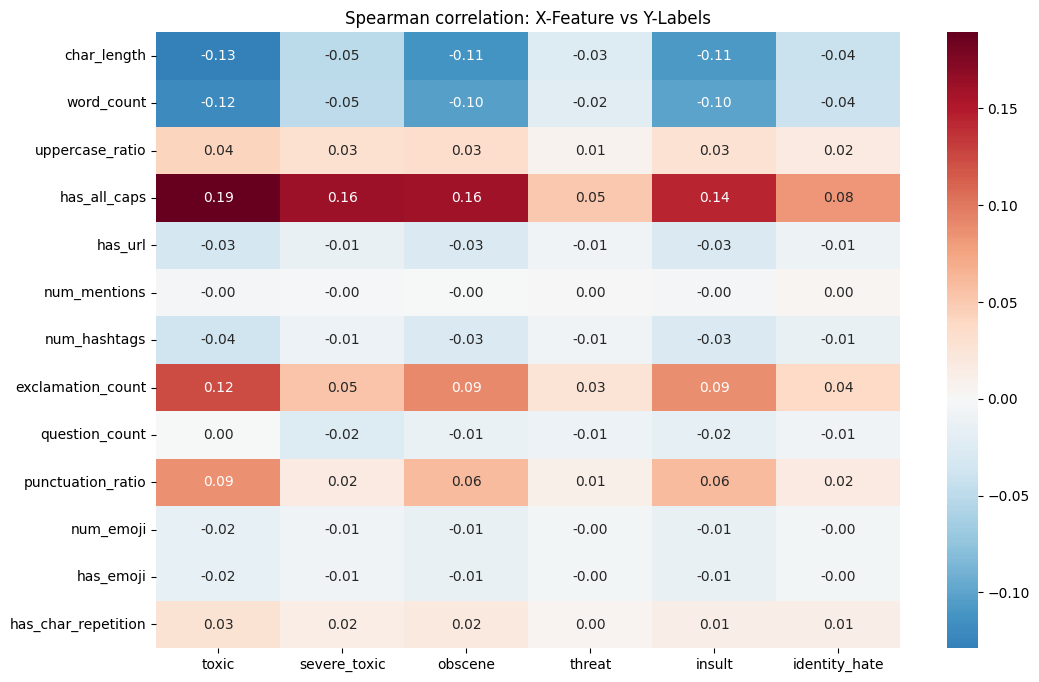

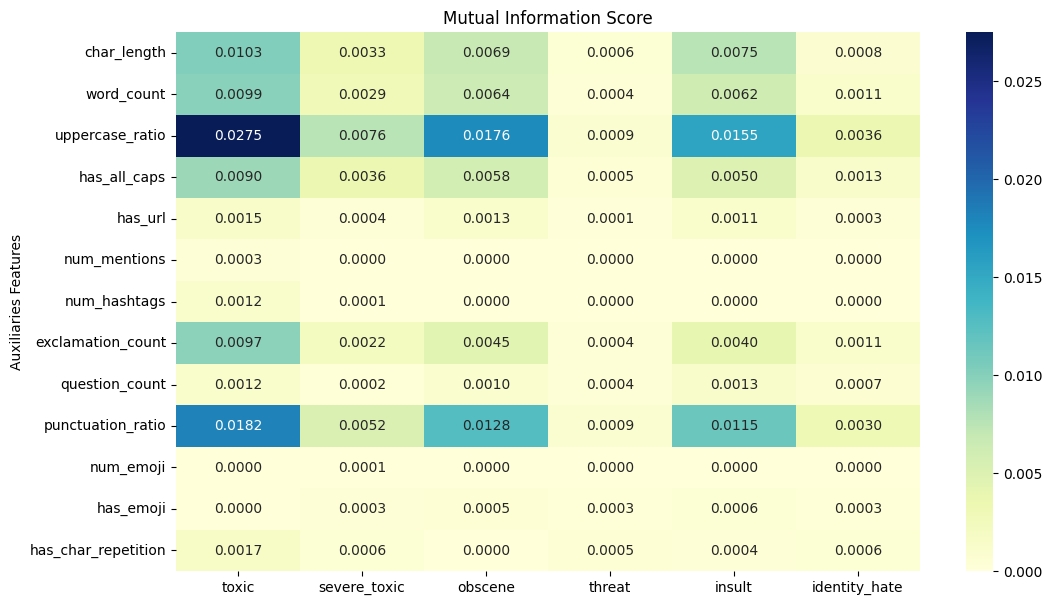

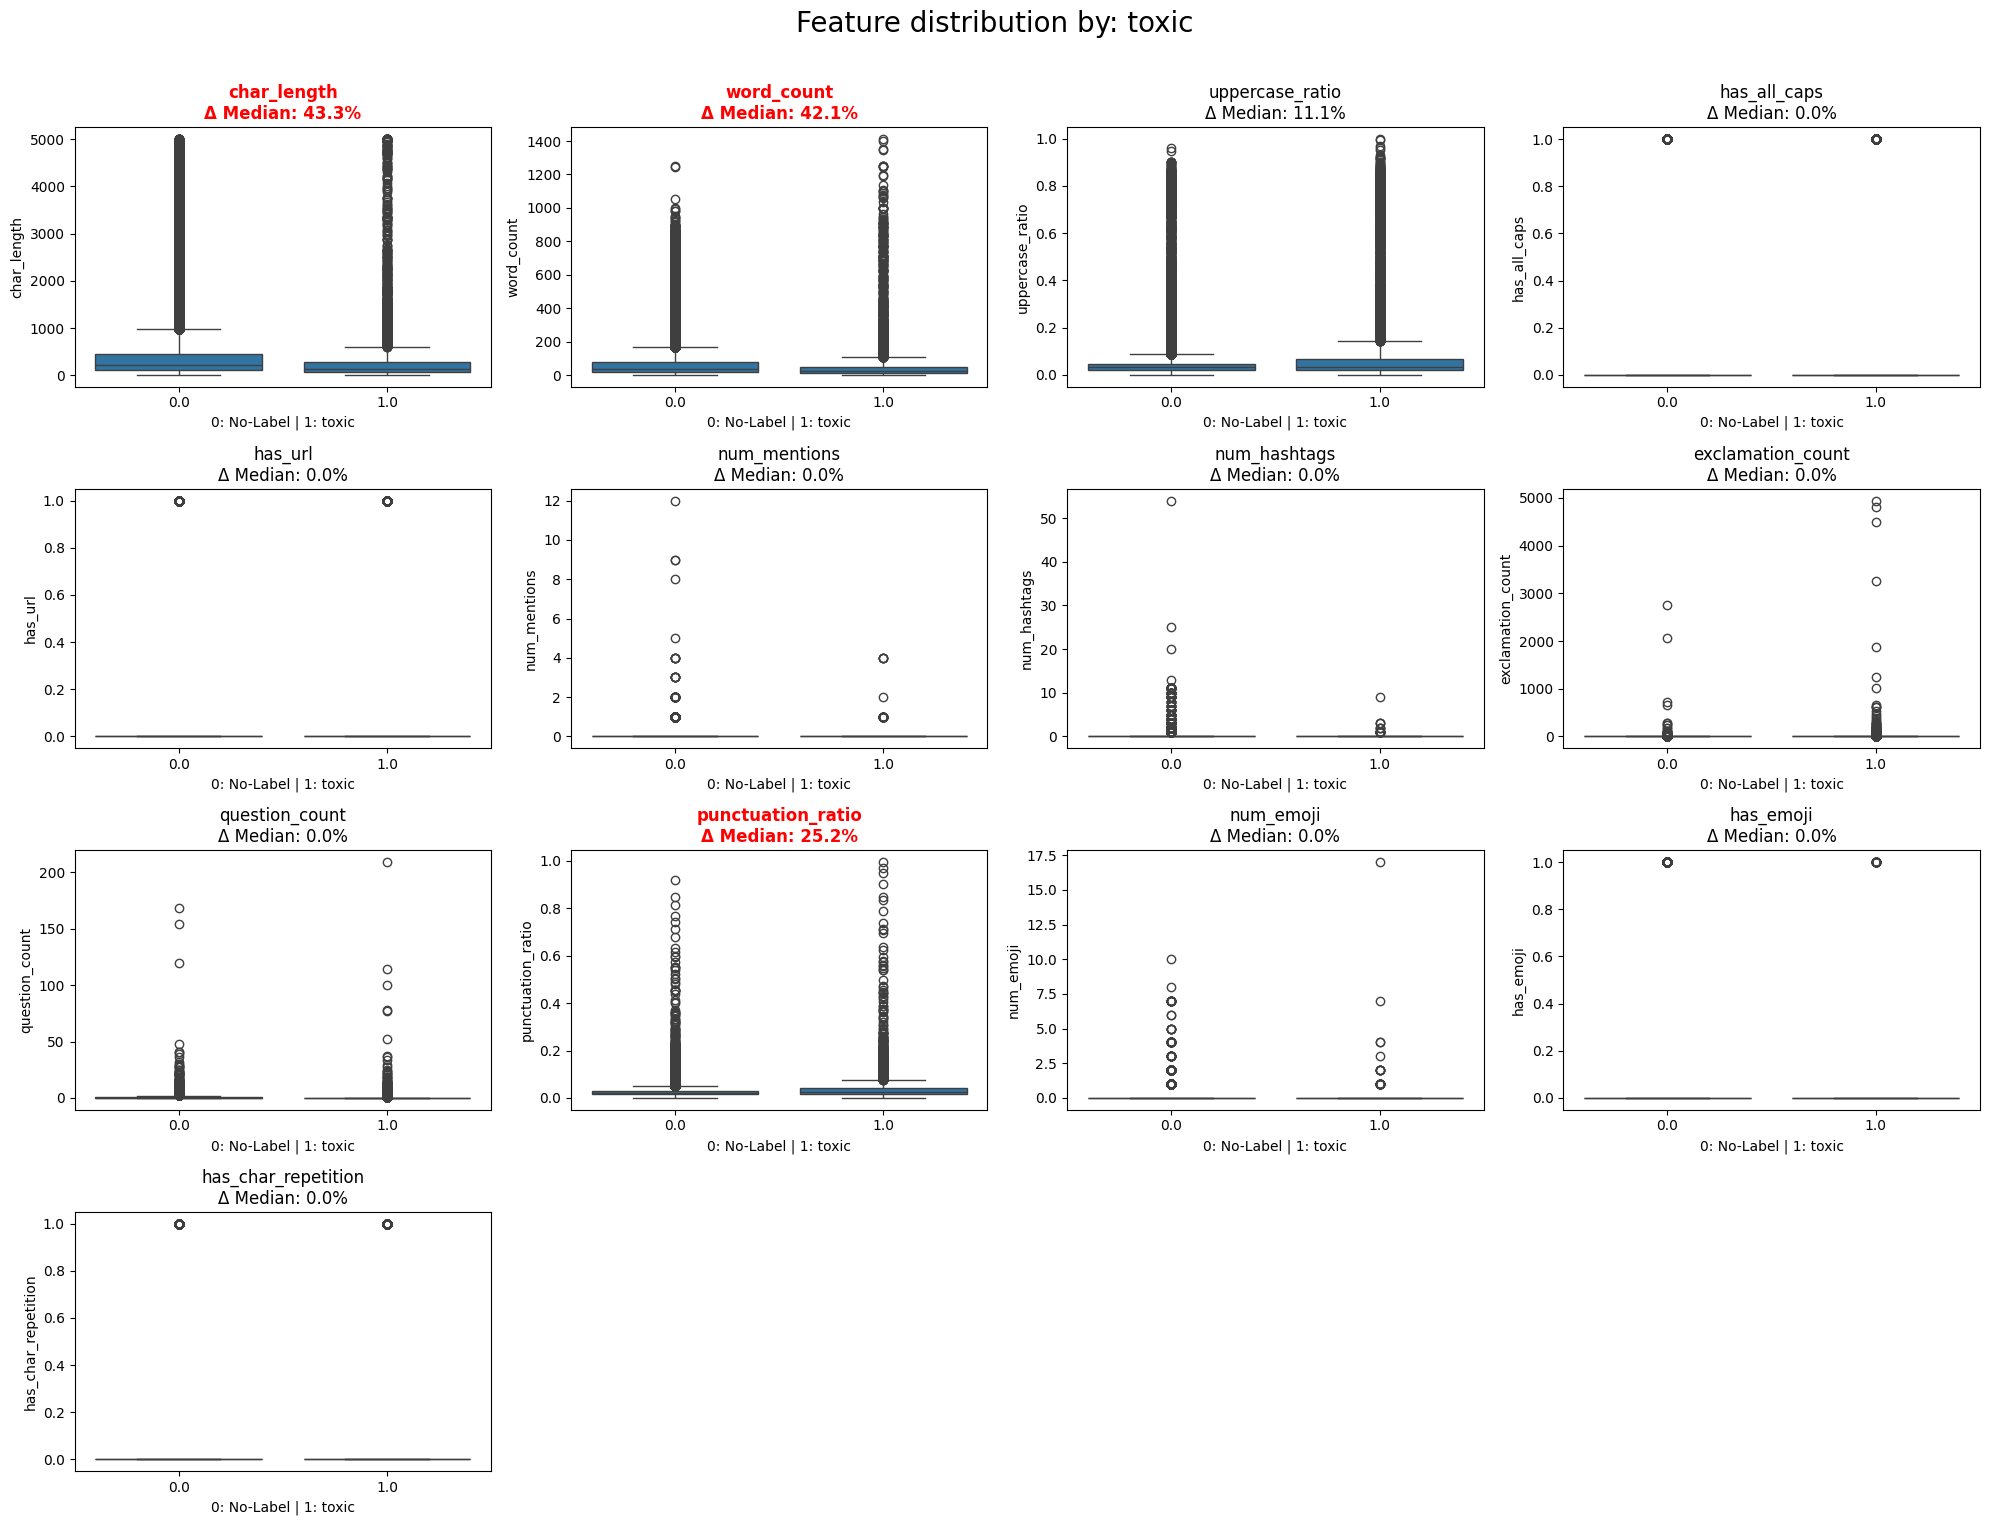

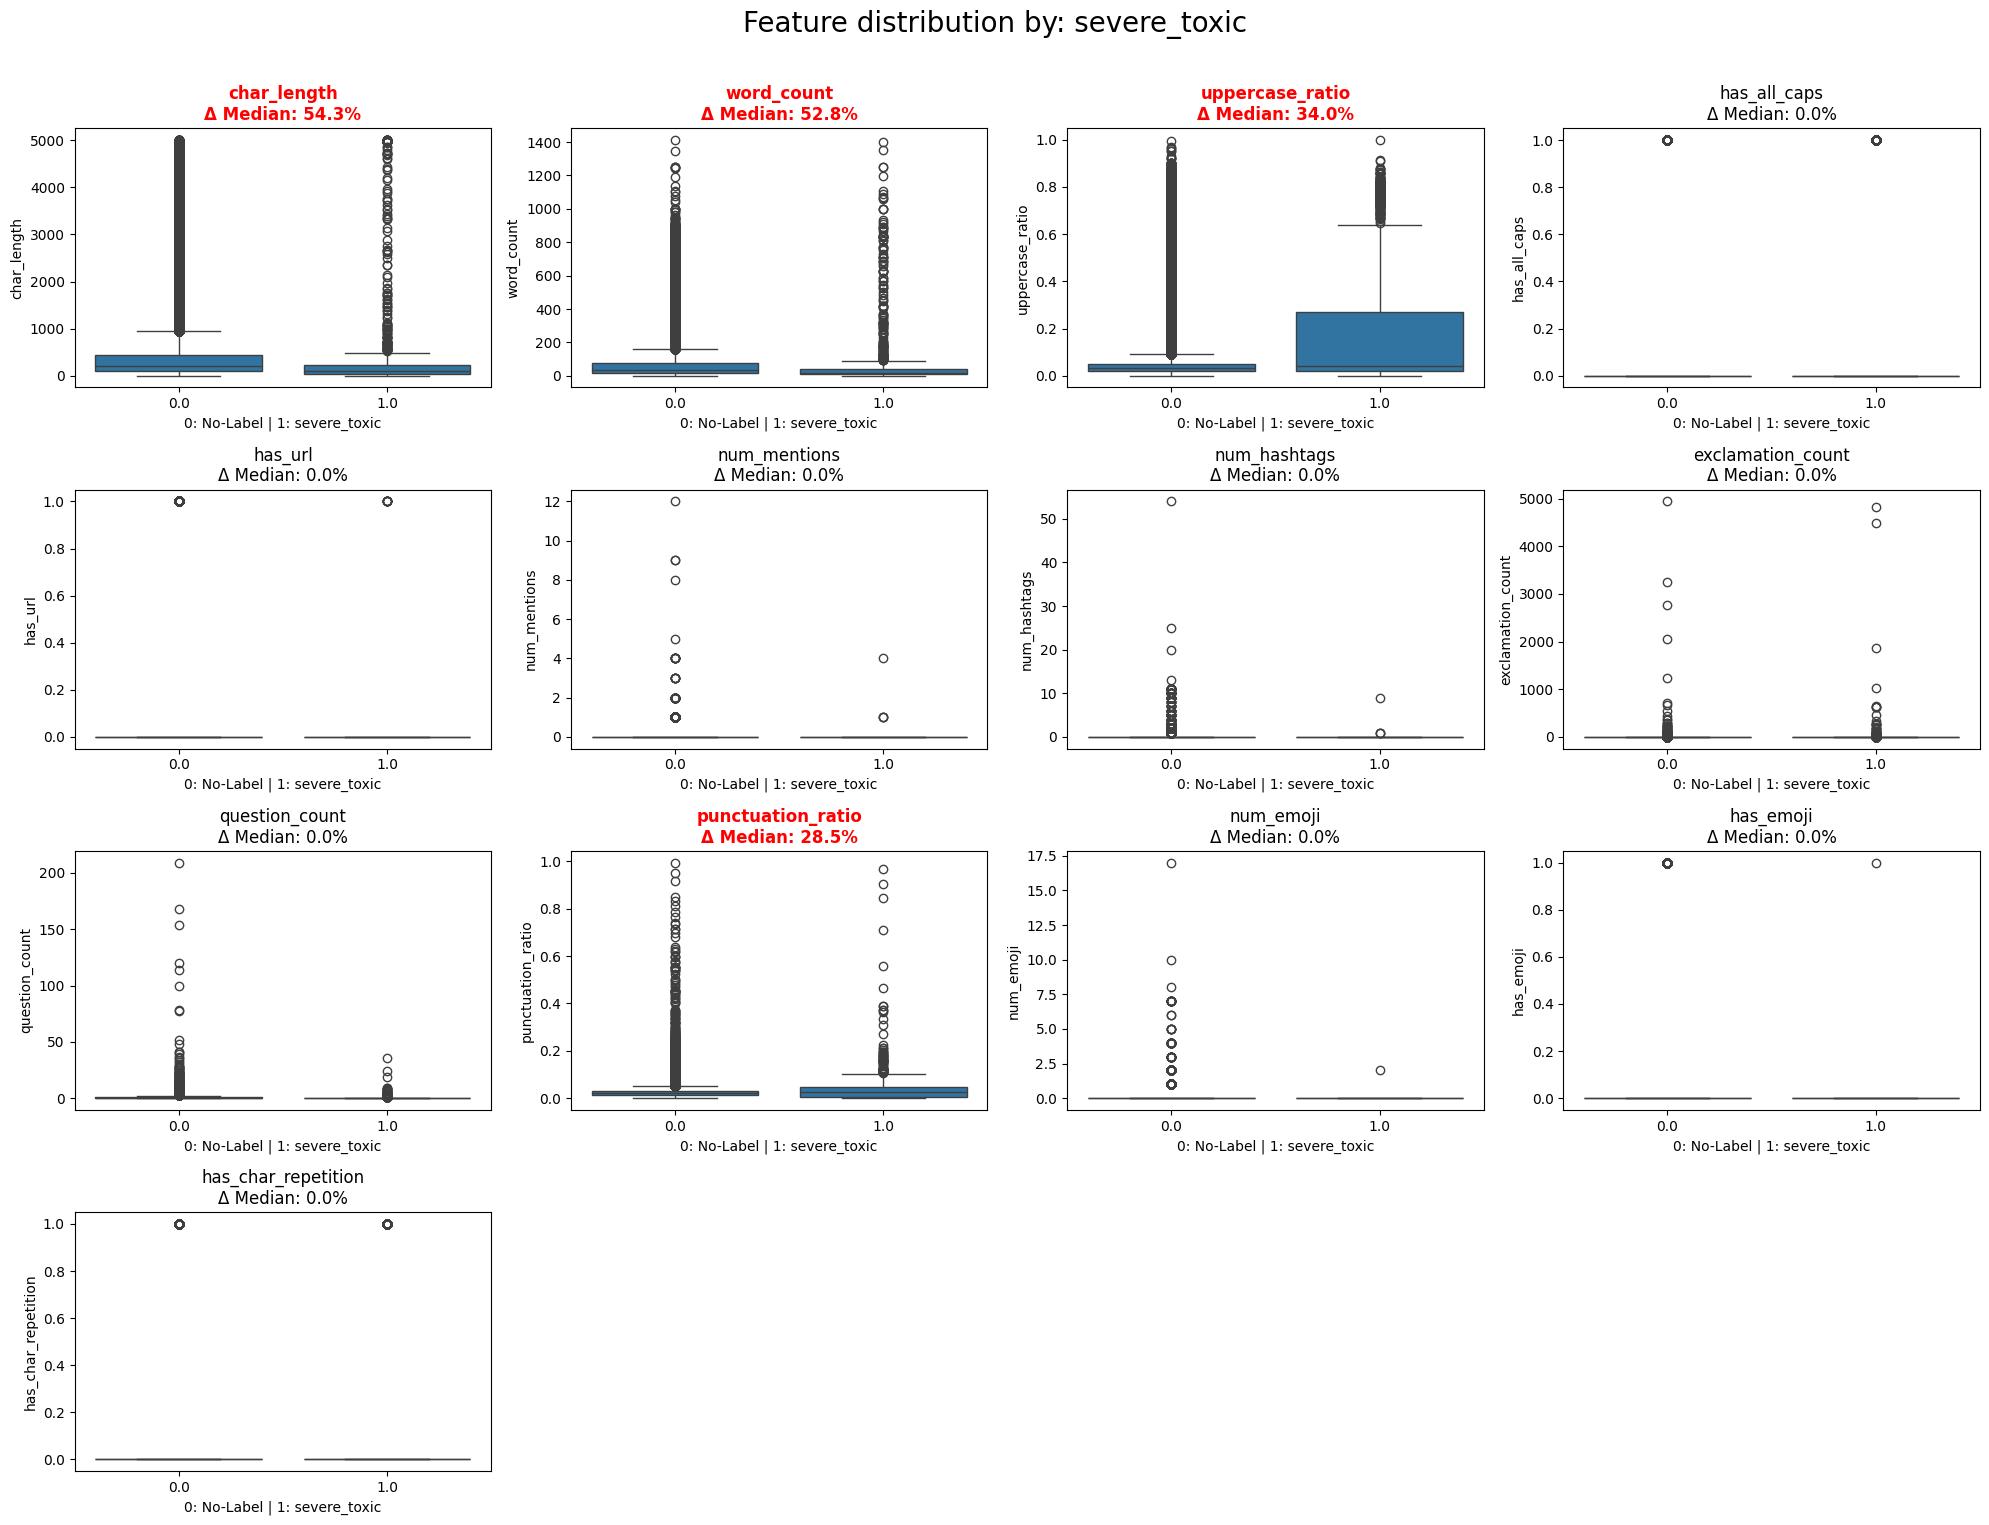

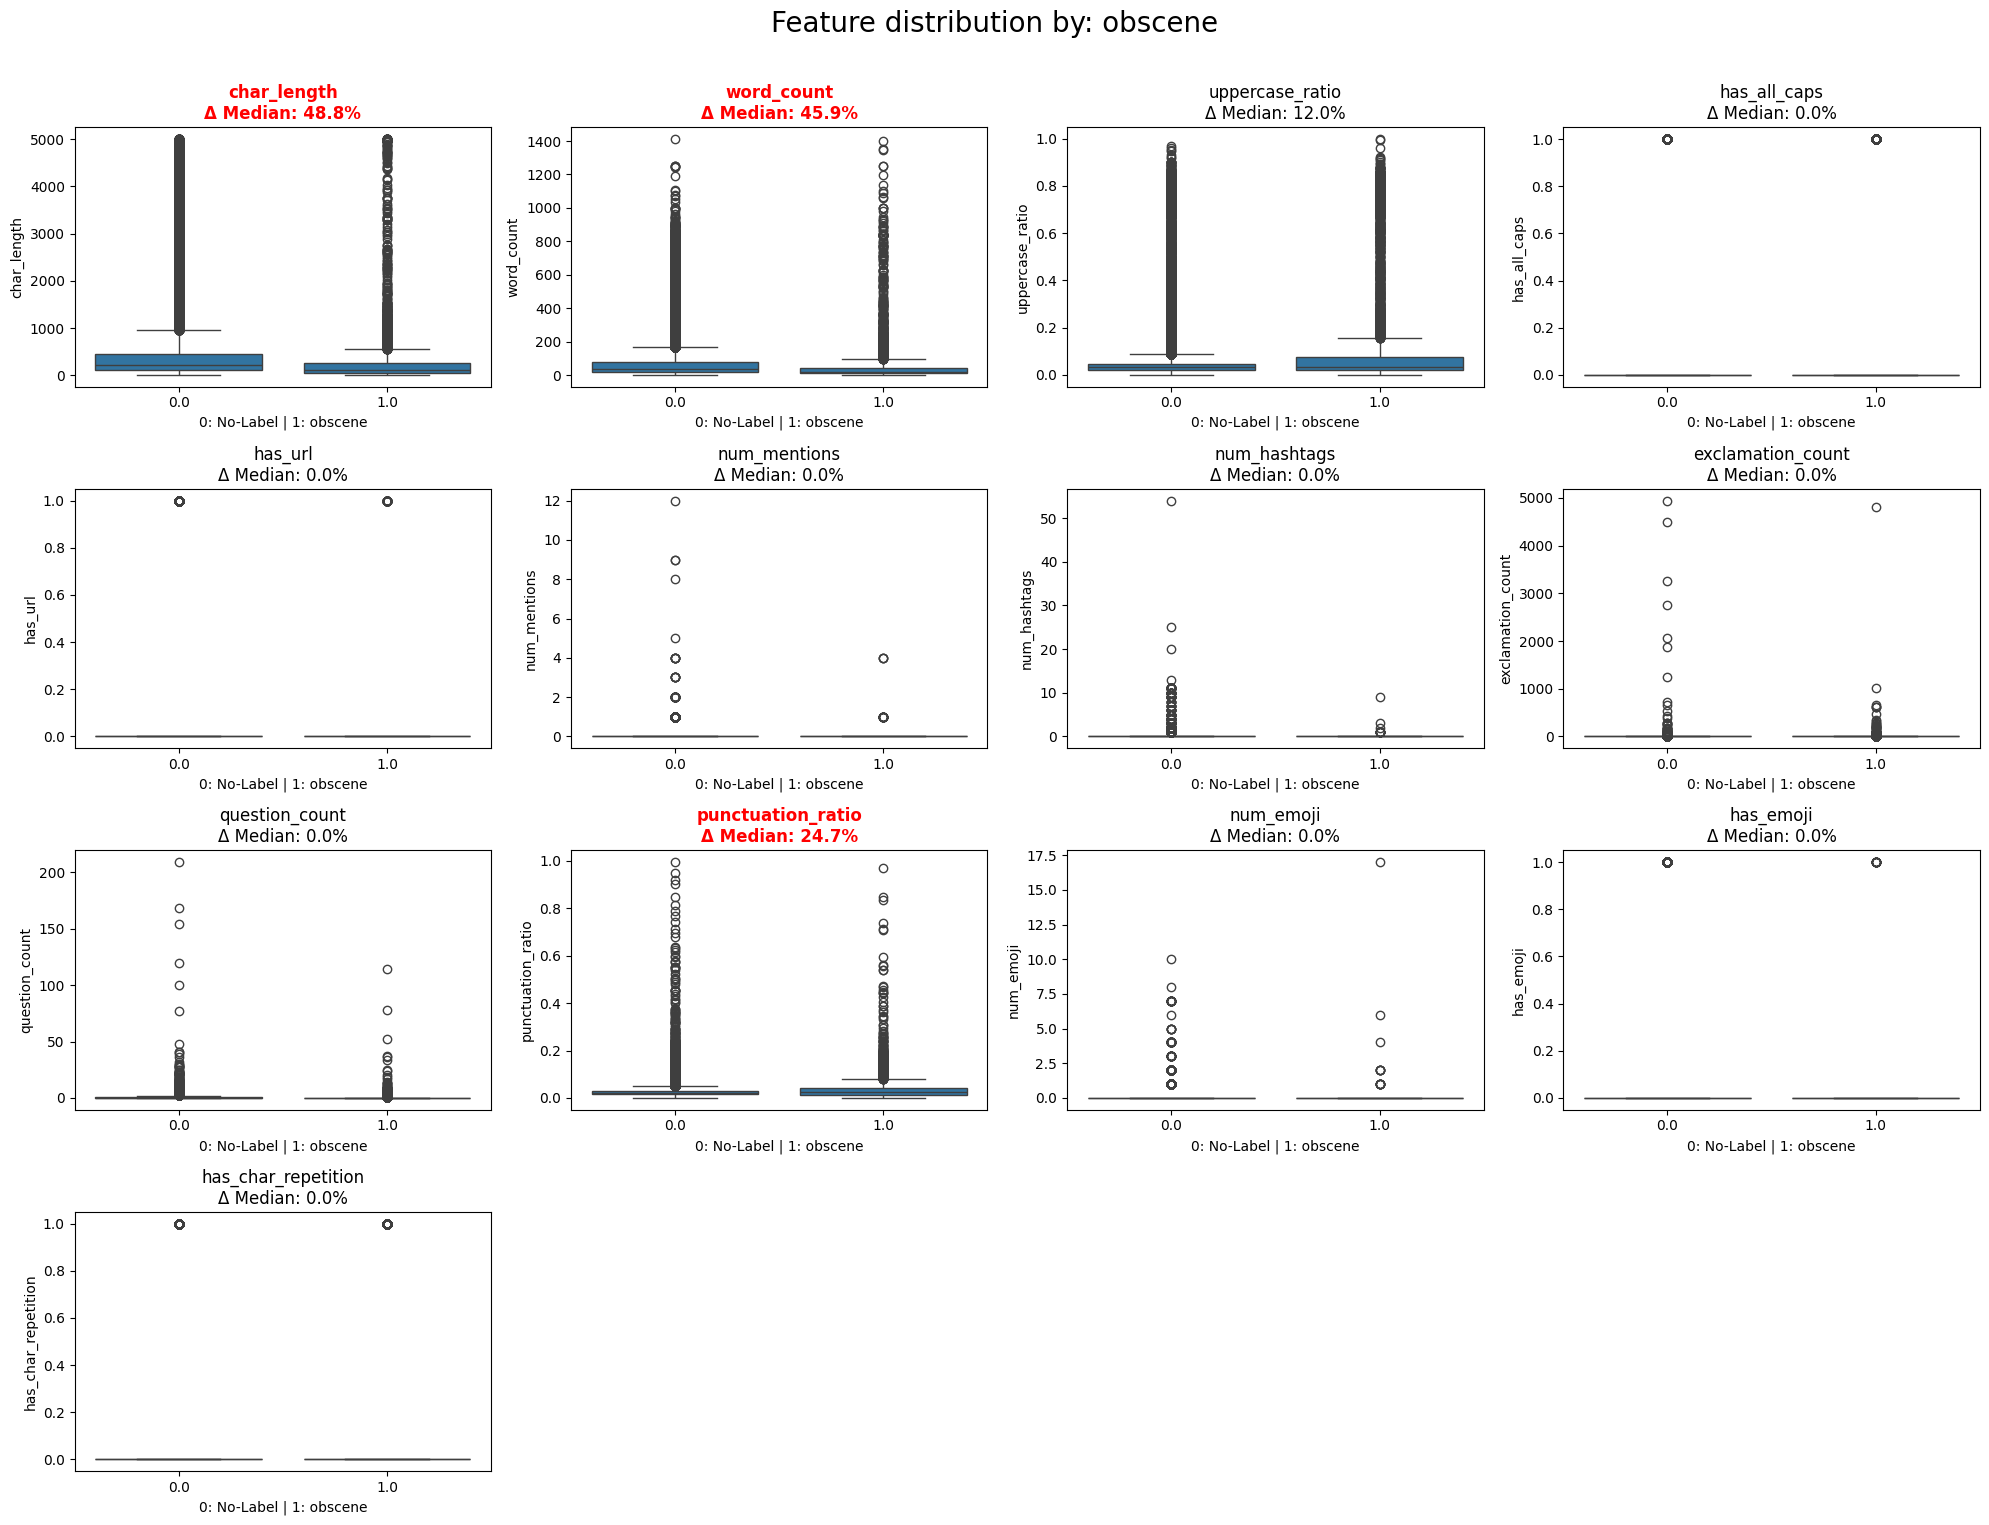

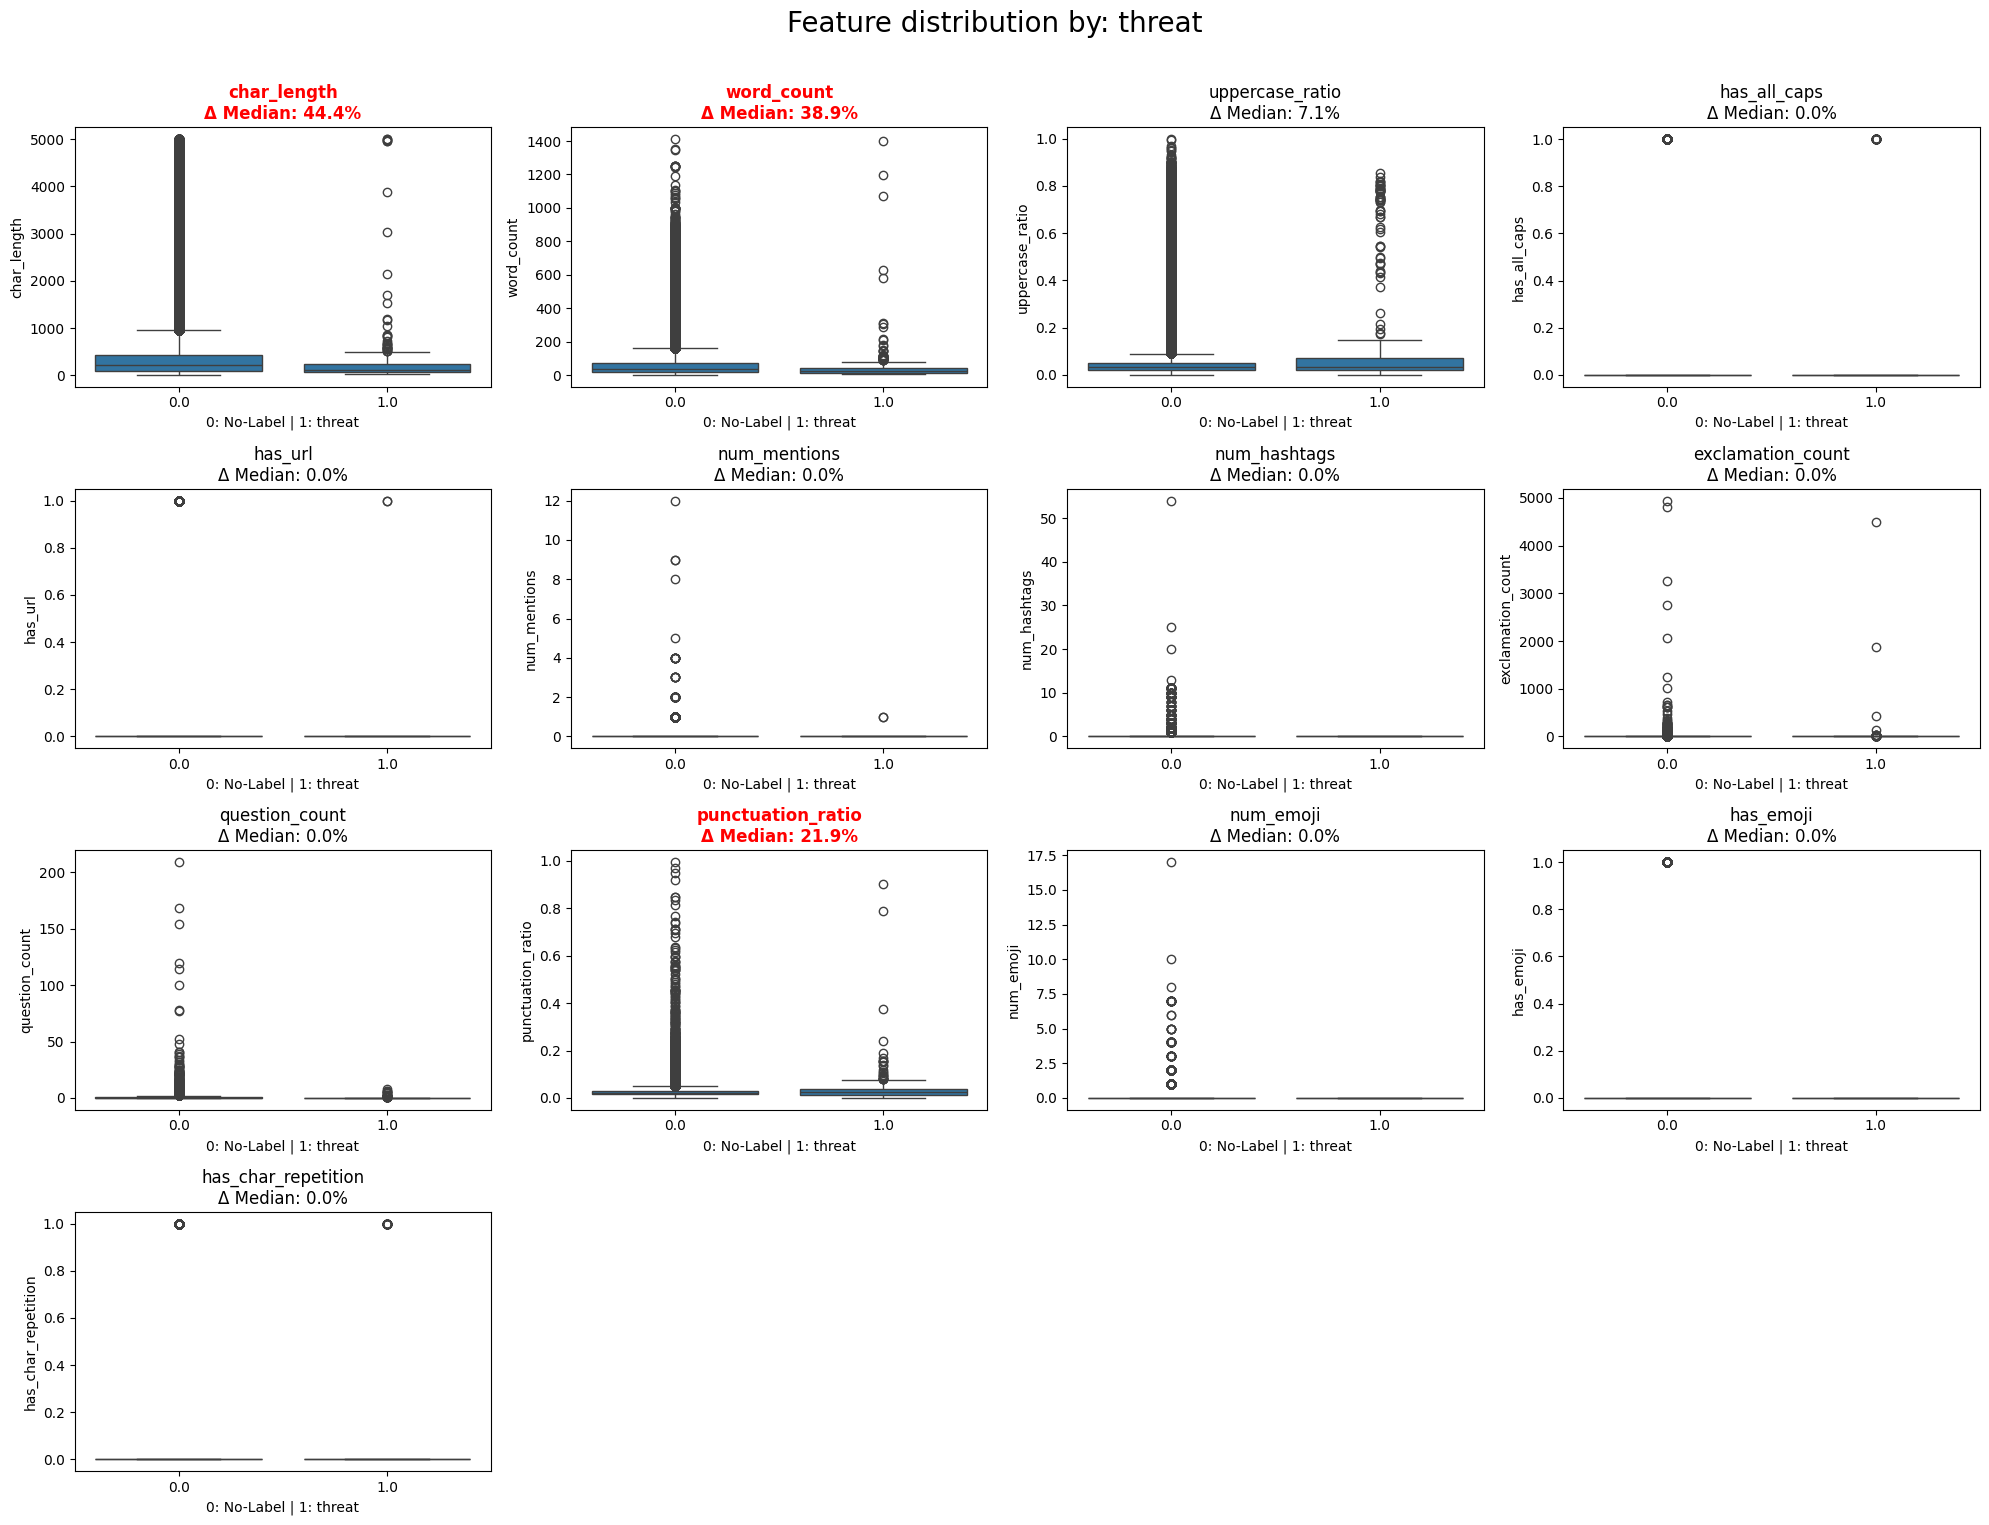

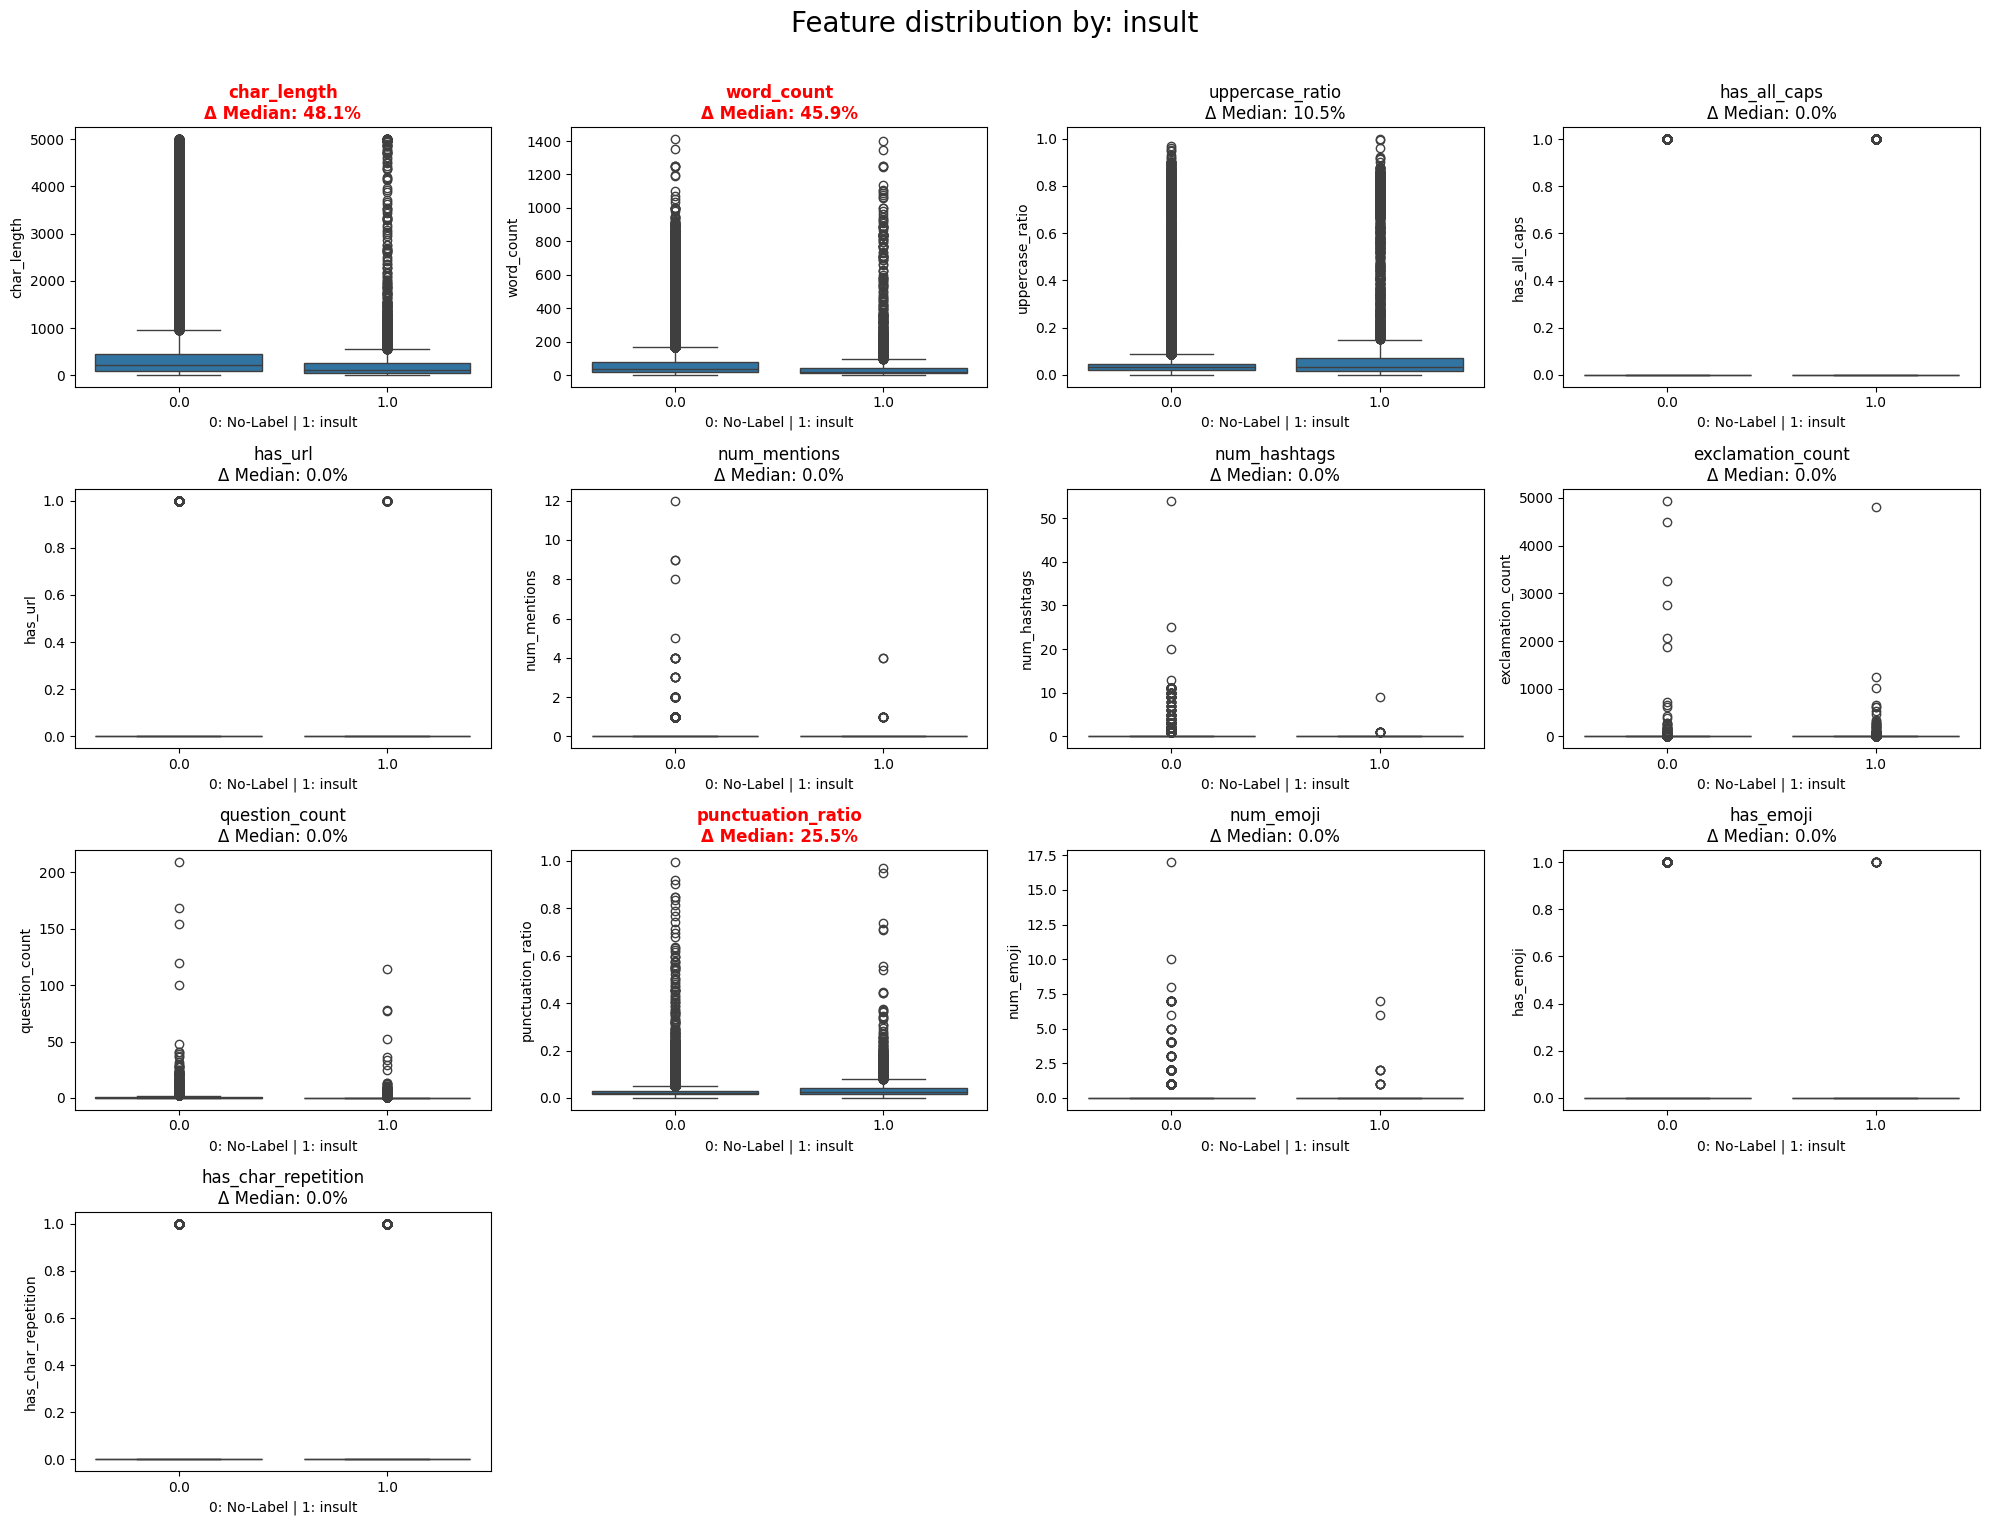

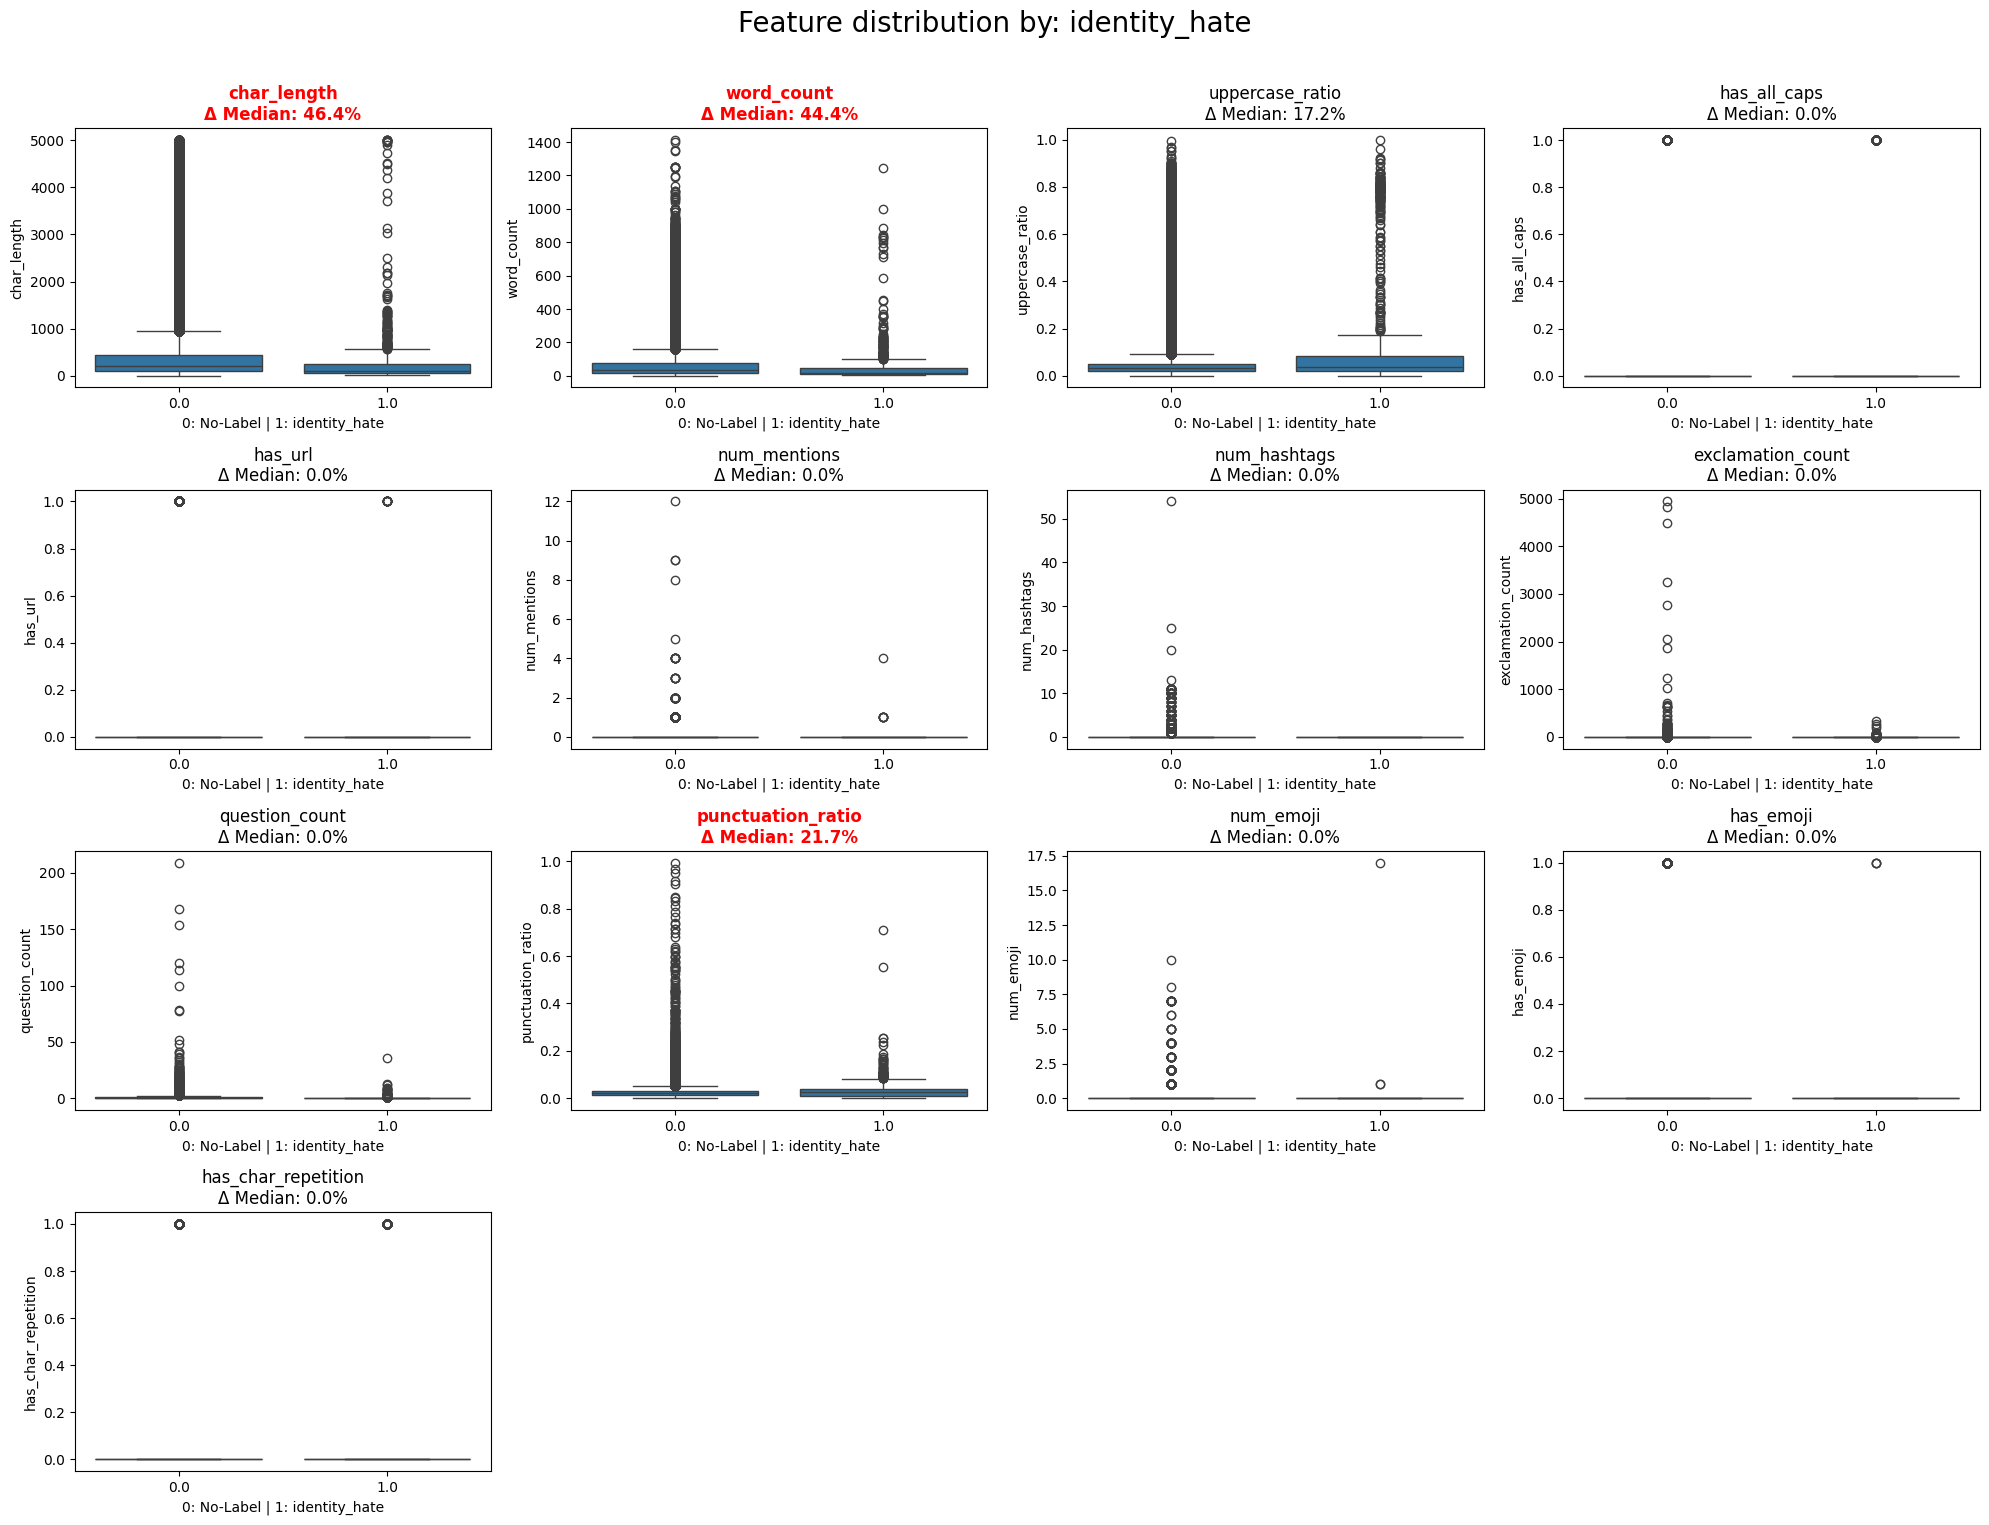

In [84]:
plot_feature_correlation(X_train_feat, y_train)
calculate_mutual_info(X_train_feat, y_train)
plot_distribution_comparison(X_train_feat, y_train)

💡 **Observation**

Auxiliary features could help in the classification of the rare labels. The EDA analysis between those features and target values showed that only frequent labels have a correlation with the new features. So those features will be take into account just in case the classification fails on the frequent labels, they haven't shown information on rare labels.


EXPERIMENT: Model_2.2_SimpleGRU_with_dropout



Model: "SimpleGRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 128)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 128, 100)  │  2,000,100 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 100)  │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_10        │ (None, 128)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     31,872 │ dropout_2[0][0],  │
│                     │                   │            │ not_equal_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 6)         │        390 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,032,362 (7.75 MB)

 Trainable params: 32,262 (126.02 KB)

 Non-trainable params: 2,000,100 (7.63 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 256s 144ms/step - accuracy: 0.8389 - auc: 0.8854 - loss: 0.0857 - val_accuracy: 0.9939 - val_auc: 0.9522 - val_loss: 0.0547 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 92s 53ms/step - accuracy: 0.9572 - auc: 0.9391 - loss: 0.0613 - val_accuracy: 0.9938 - val_auc: 0.9621 - val_loss: 0.0502 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 119s 68ms/step - accuracy: 0.9608 - auc: 0.9478 - loss: 0.0580 - val_accuracy: 0.9937 - val_auc: 0.9618 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 126s 72ms/step - accuracy: 0.9571 - auc: 0.9548 - loss: 0.0561 - val_accuracy: 0.9936 - val_auc: 0.9637 - val_loss: 0.0483 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 129s 74ms/step - accuracy: 0.9598 - auc: 0.9574 - loss: 0.0549 - val_accuracy: 0.9929 - val_auc: 0.9647 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 120s 69m

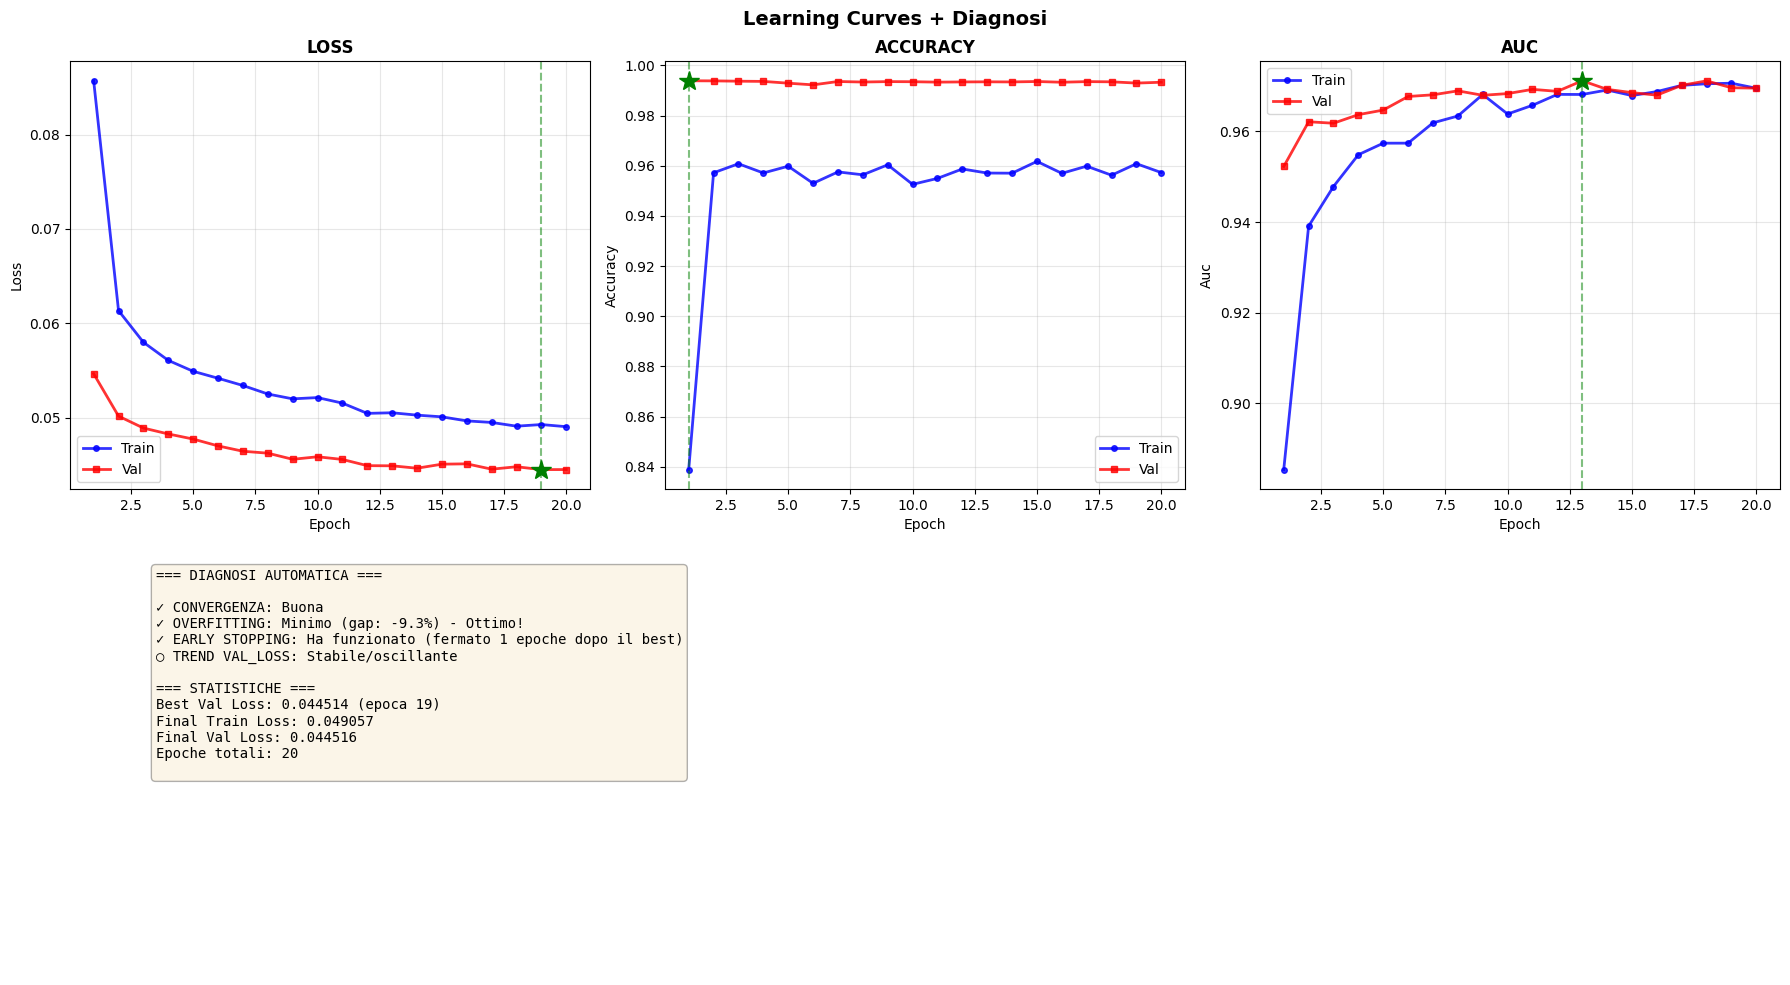


EVALUATION: Model_2.2_SimpleGRU_with_dropout



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.572095  0.756635       0.982965       0.986872      0.666966   

   PR_AUC_Micro  Hamming_Loss  
0      0.847538      0.016537

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.878804  0.730166  0.797619  0.977402  0.888665
1   severe_toxic   0.496183  0.270833  0.350404  0.989071  0.423221
2        obscene   0.849498  0.801894  0.825010  0.983635  0.892589
3         threat   0.583333  0.197183  0.294737  0.982595  0.462633
4         insult   0.751536  0.724196  0.737613  0.983317  0.810809
5  identity_hate   0.673469  0.312796  0.427184  0.981771  0.523882

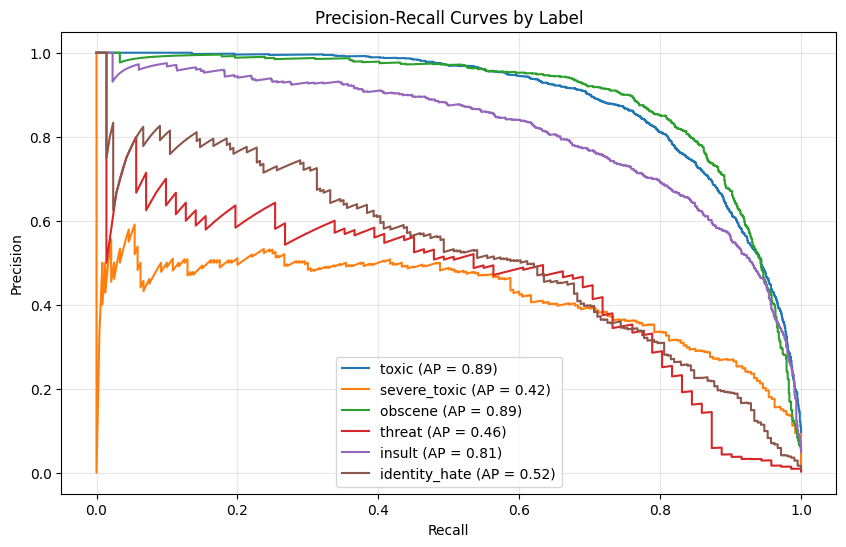

Model: Model_2.2_SimpleGRU_with_dropout
  F1 Macro: 0.5721
  F1 Micro: 0.7566
  ROC-AUC Macro: 0.9830
PR AUC Macro: 0.6670
  Training time (s): 2480.80


In [74]:
exp_prep_contr_GRU_drop = [
    {
        'name': 'Model_2.2_SimpleGRU_with_dropout',
        'builder': build_simple_gru_with_dropout(embedding_matrix=embedding_matrix, gru_units=UNITS, max_len=MAX_LEN, embedding_trainable=False),
        'params': {'units': UNITS, 'loss': 'BCE', 'embedding_trainable': False}
    }
]
all_results = run_experiments(exp_prep_contr_GRU_drop)

# Experiments

## Simple LSTM, GRU


EXPERIMENT: model_1_LSTM_simple



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     93,440 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,094,130 (23.25 MB)

 Trainable params: 93,830 (366.52 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9754 - auc: 0.8516 - loss: 0.1090

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 178s 101ms/step - accuracy: 0.9897 - auc: 0.9318 - loss: 0.0694 - val_accuracy: 0.9937 - val_auc: 0.9623 - val_loss: 0.0501 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9937 - auc: 0.9612 - loss: 0.0503

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - accuracy: 0.9921 - auc: 0.9668 - loss: 0.0490 - val_accuracy: 0.9926 - val_auc: 0.9720 - val_loss: 0.0480 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9916 - auc: 0.9725 - loss: 0.0452

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - accuracy: 0.9912 - auc: 0.9759 - loss: 0.0450 - val_accuracy: 0.9928 - val_auc: 0.9733 - val_loss: 0.0457 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9889 - auc: 0.9795 - loss: 0.0422

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - accuracy: 0.9872 - auc: 0.9785 - loss: 0.0424 - val_accuracy: 0.9903 - val_auc: 0.9743 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9811 - auc: 0.9824 - loss: 0.0400

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - accuracy: 0.9786 - auc: 0.9819 - loss: 0.0404 - val_accuracy: 0.9896 - val_auc: 0.9717 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9719 - auc: 0.9848 - loss: 0.0384

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9688 - auc: 0.9836 - loss: 0.0386 - val_accuracy: 0.9493 - val_auc: 0.9730 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9621 - auc: 0.9854 - loss: 0.0371 - val_accuracy: 0.9705 - val_auc: 0.9708 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9636 - auc: 0.9871 - loss: 0.0355
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 175s 100ms/step - accuracy: 0.9365 - auc: 0.9872 - loss: 0.0356 - val_accuracy: 0.9526 - val_auc: 0.9691 - val_loss: 0.0450 - learning_rate: 0.0010
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9519 - auc: 0.9886 - loss: 0.0329 - val_accuracy: 0.9408 - val_auc: 0.9680 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9501 - au

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_1_LSTM_simple_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


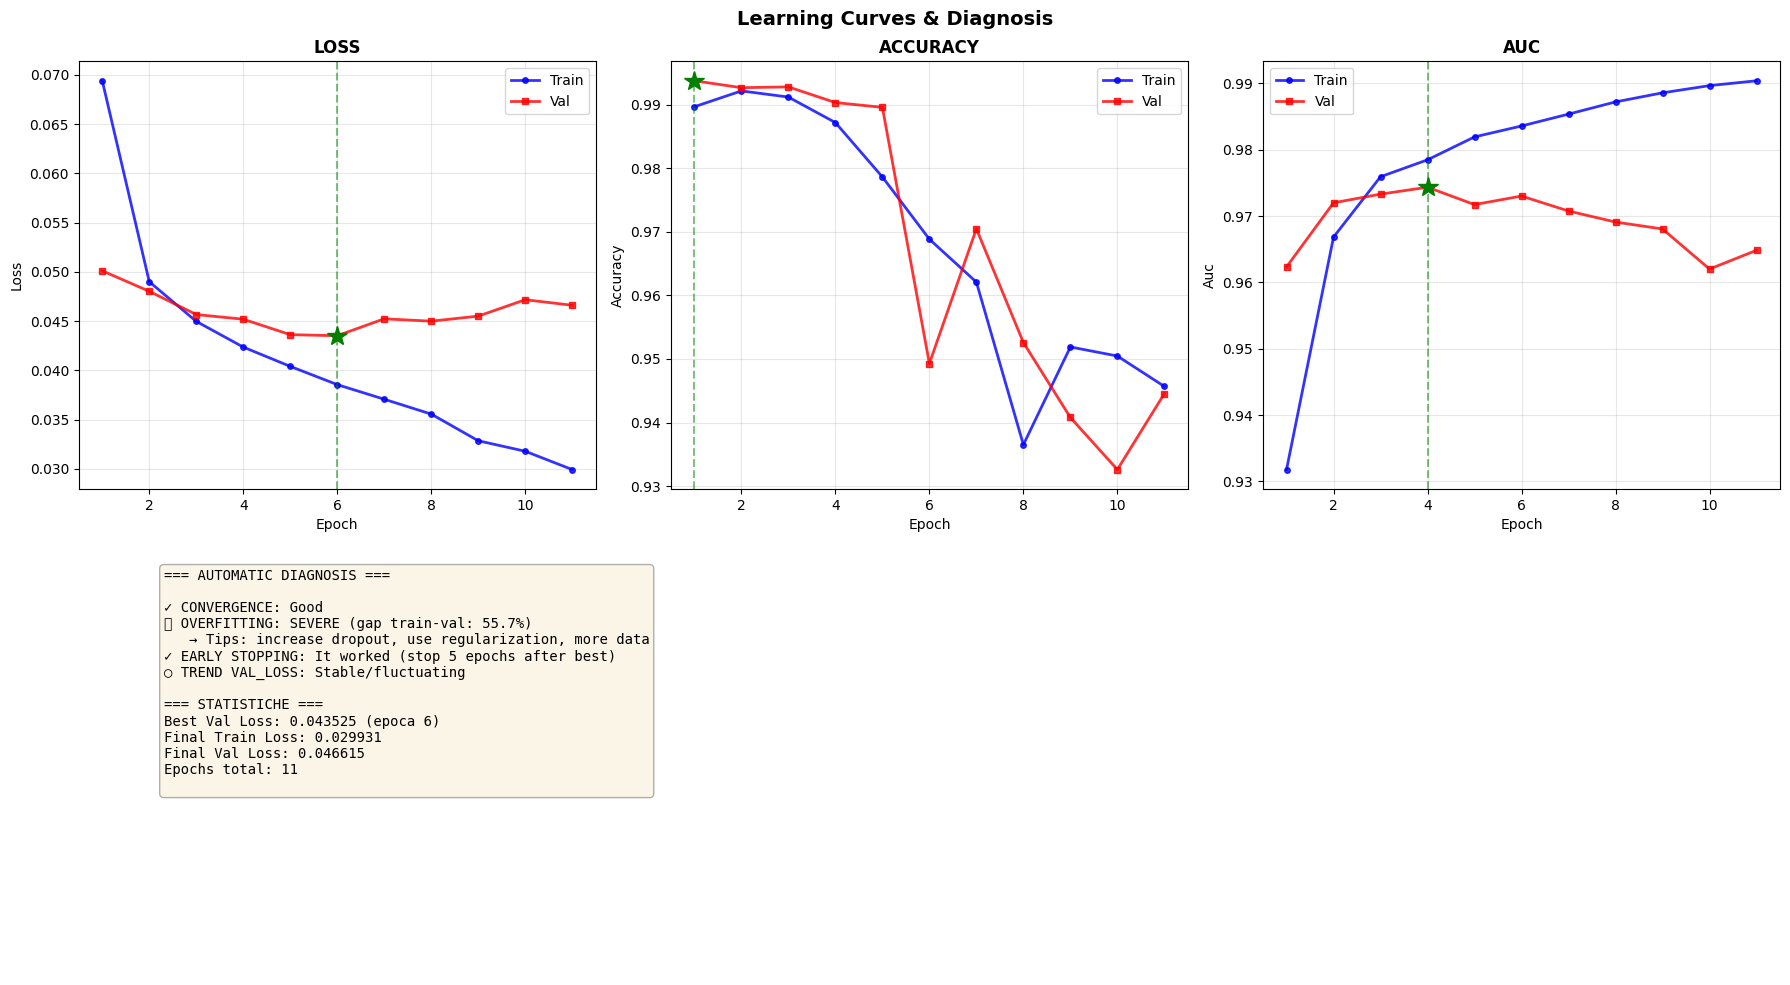


EVALUATION: model_1_LSTM_simple



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.589236  0.764099       0.983727        0.98807      0.660877   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.851347      0.016252         0.924423

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.847701  0.771578  0.807850  0.979485  0.893303
1   severe_toxic   0.460000  0.191667  0.270588  0.988022  0.400935
2        obscene   0.847500  0.802684  0.824483  0.986303  0.894240
3         threat   0.677419  0.295775  0.411765  0.981488  0.454589
4         insult   0.778493  0.716582  0.746256  0.984829  0.805901
5  identity_hate   0.647541  0.374408  0.474474  0.982237  0.516292

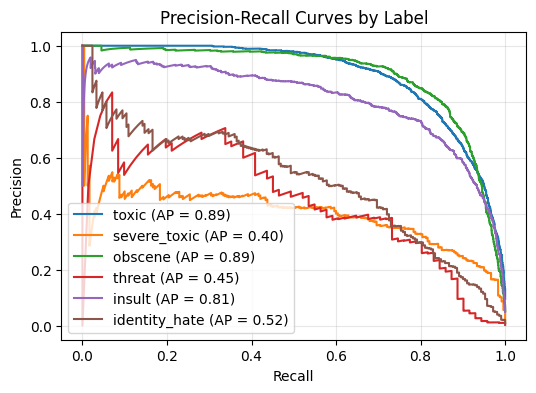

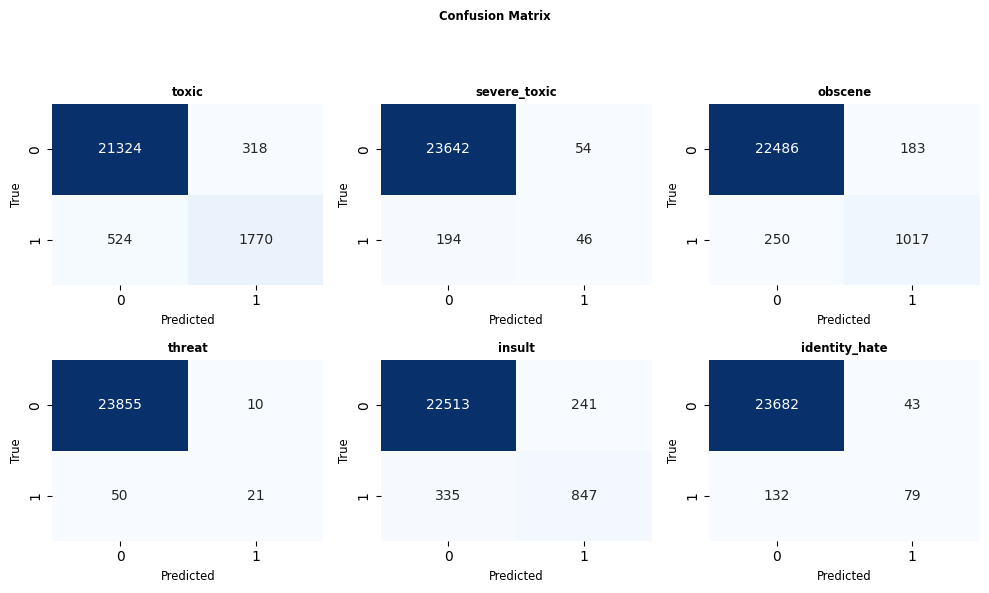

  Training time (s): 1925.81

EXPERIMENT: model_1_GRU_simple



Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     70,272 │ embedding[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ gru[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,070,962 (23.16 MB)

 Trainable params: 70,662 (276.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9112 - auc: 0.8738 - loss: 0.1070

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 171s 97ms/step - accuracy: 0.9766 - auc: 0.9465 - loss: 0.0643 - val_accuracy: 0.9821 - val_auc: 0.9658 - val_loss: 0.0479 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9882 - auc: 0.9730 - loss: 0.0453

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 168s 96ms/step - accuracy: 0.9813 - auc: 0.9760 - loss: 0.0449 - val_accuracy: 0.9837 - val_auc: 0.9701 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9752 - auc: 0.9800 - loss: 0.0418

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.9659 - auc: 0.9794 - loss: 0.0421 - val_accuracy: 0.9885 - val_auc: 0.9777 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 4/20
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9557 - auc: 0.9825 - loss: 0.0400

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 168s 96ms/step - accuracy: 0.9352 - auc: 0.9808 - loss: 0.0400 - val_accuracy: 0.9714 - val_auc: 0.9662 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9460 - auc: 0.9830 - loss: 0.0373

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 168s 96ms/step - accuracy: 0.9405 - auc: 0.9827 - loss: 0.0380 - val_accuracy: 0.8771 - val_auc: 0.9732 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.9144 - auc: 0.9845 - loss: 0.0362 - val_accuracy: 0.9610 - val_auc: 0.9732 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9159 - auc: 0.9867 - loss: 0.0342
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.9120 - auc: 0.9856 - loss: 0.0344 - val_accuracy: 0.8490 - val_auc: 0.9701 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.8730 - auc: 0.9889 - loss: 0.0314 - val_accuracy: 0.9554 - val_auc: 0.9678 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.8735 - auc: 0.

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_1_GRU_simple_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


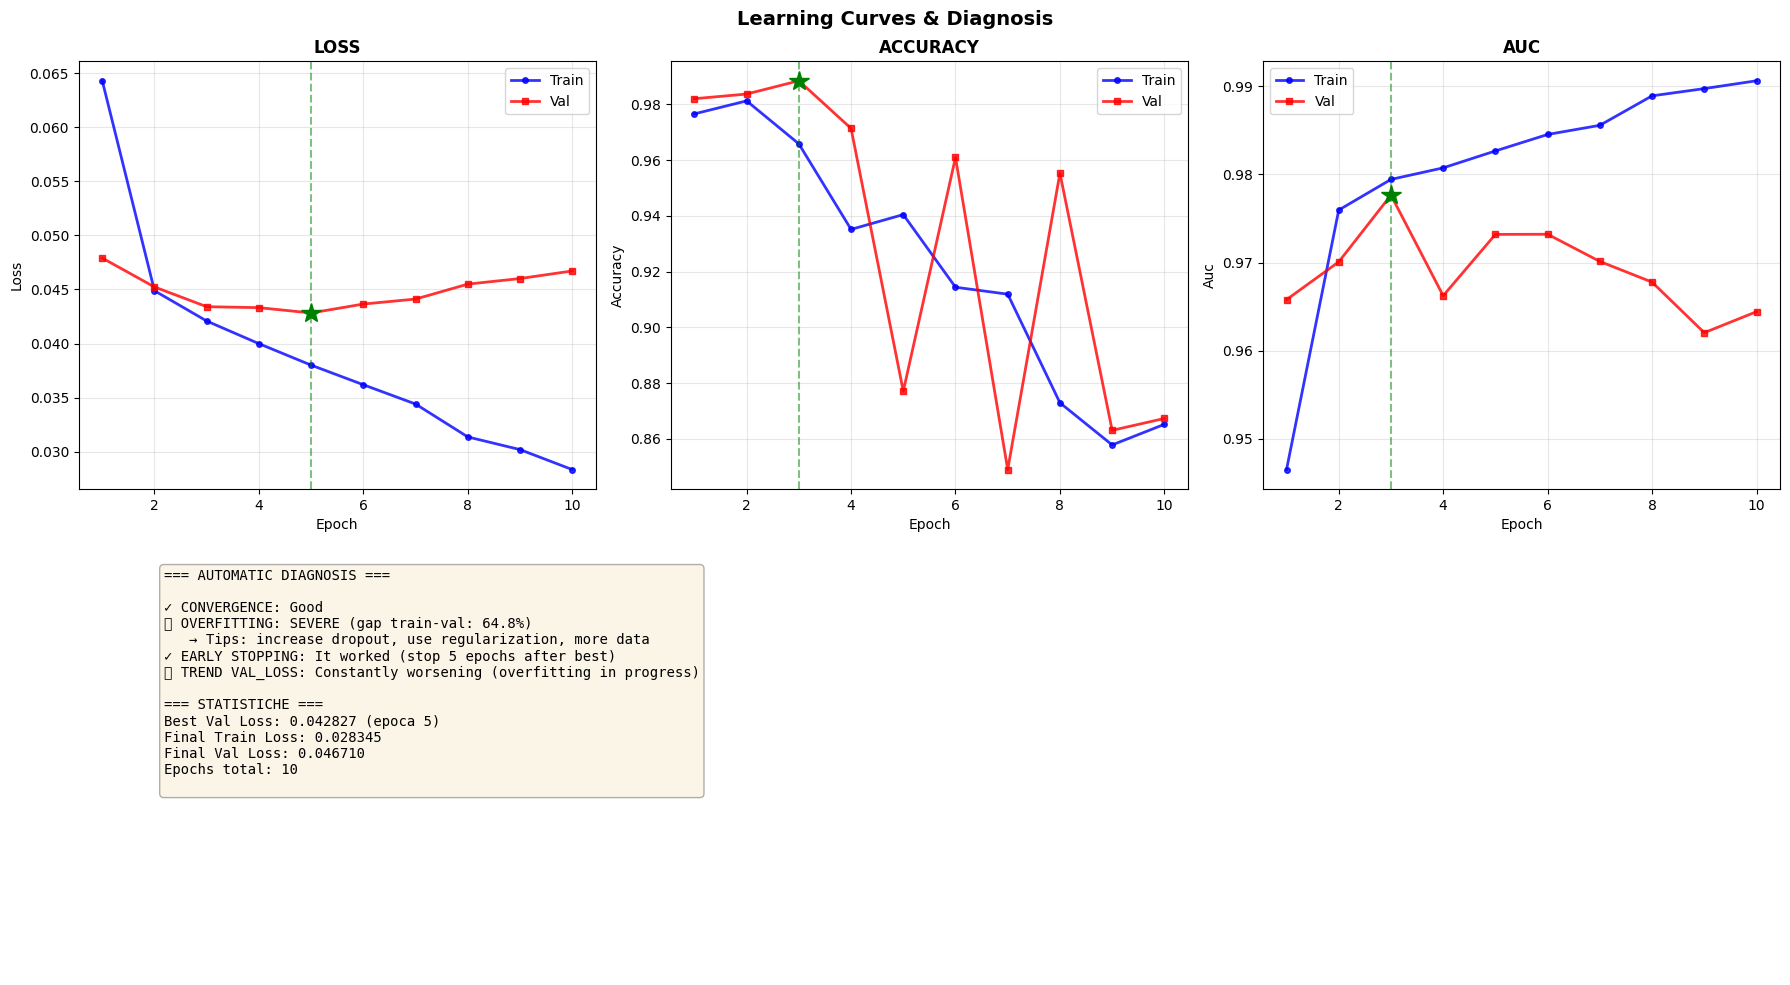


EVALUATION: model_1_GRU_simple



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.608867  0.768196       0.984663       0.988576      0.673267   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0       0.85539      0.016078         0.924716

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.838242  0.781604  0.808933  0.980359  0.896576
1   severe_toxic   0.528455  0.270833  0.358127  0.988825  0.445806
2        obscene   0.860544  0.798737  0.828490  0.986583  0.897906
3         threat   0.633333  0.267606  0.376238  0.980870  0.428118
4         insult   0.799615  0.702200  0.747748  0.985444  0.815789
5  identity_hate   0.563158  0.507109  0.533666  0.985897  0.555407

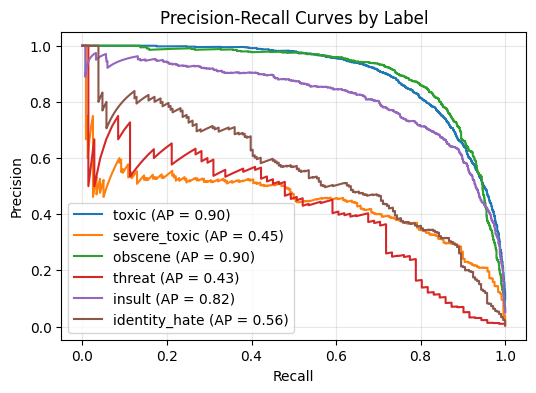

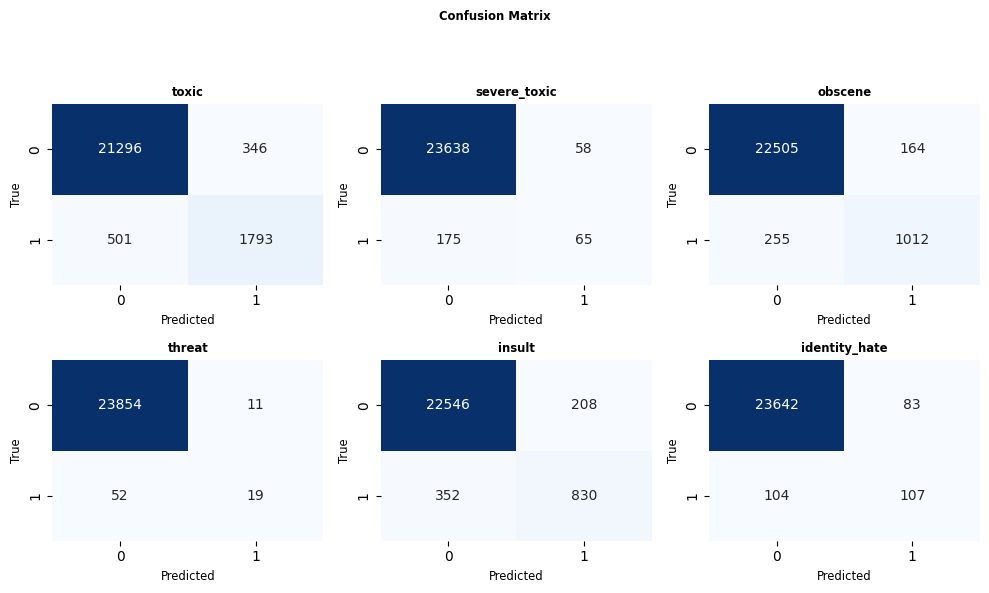

  Training time (s): 1689.39


In [ ]:
config_simple = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss_name': 'bce',
    'seed': SEED
}
experiments_1 = [
    {
        'name': 'model_1_LSTM_simple',
        'builder': build_lstm(config=config_simple, embedding_matrix=embedding_matrix),
        'params': config_simple
    }, 
    {
        'name': 'model_1_GRU_simple',
        'builder': build_gru(config=config_simple, embedding_matrix=embedding_matrix),
        'params': config_simple
    }
]
exp_res = run_experiments(experiments_1)
for res in exp_res: 
    all_results.append(res)

## Class weighted LSTM, GRU

toxic: pos=10706.0 (9.58%), weight_pos=3.07
severe_toxic: pos=1116.0 (1.00%), weight_pos=9.95
obscene: pos=5914.0 (5.29%), weight_pos=4.23
threat: pos=335.0 (0.30%), weight_pos=18.23
insult: pos=5514.0 (4.94%), weight_pos=4.39
identity_hate: pos=983.0 (0.88%), weight_pos=10.61

EXPERIMENT: model_2_LSTM_wloss



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     93,440 │ embedding[0][0],  │
│                     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ lstm[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,094,130 (23.25 MB)

 Trainable params: 93,830 (366.52 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9281 - auc: 0.9070 - loss: 0.2488

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 178s 101ms/step - accuracy: 0.9622 - auc: 0.9499 - loss: 0.1966 - val_accuracy: 0.9930 - val_auc: 0.9647 - val_loss: 0.1536 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9864 - auc: 0.9719 - loss: 0.1505

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9853 - auc: 0.9750 - loss: 0.1427 - val_accuracy: 0.9824 - val_auc: 0.9774 - val_loss: 0.1268 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9797 - auc: 0.9824 - loss: 0.1227

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 173s 99ms/step - accuracy: 0.9769 - auc: 0.9826 - loss: 0.1208 - val_accuracy: 0.9734 - val_auc: 0.9800 - val_loss: 0.1208 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9553 - auc: 0.9853 - loss: 0.1142

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 99ms/step - accuracy: 0.9576 - auc: 0.9856 - loss: 0.1123 - val_accuracy: 0.9752 - val_auc: 0.9781 - val_loss: 0.1175 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9651 - auc: 0.9869 - loss: 0.1054

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 190s 109ms/step - accuracy: 0.9578 - auc: 0.9874 - loss: 0.1051 - val_accuracy: 0.9724 - val_auc: 0.9812 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 173s 99ms/step - accuracy: 0.9381 - auc: 0.9885 - loss: 0.0991 - val_accuracy: 0.9472 - val_auc: 0.9789 - val_loss: 0.1170 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9155 - auc: 0.9887 - loss: 0.0926
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9175 - auc: 0.9893 - loss: 0.0972 - val_accuracy: 0.9746 - val_auc: 0.9785 - val_loss: 0.1186 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 174s 100ms/step - accuracy: 0.9509 - auc: 0.9910 - loss: 0.0897 - val_accuracy: 0.9426 - val_auc: 0.9772 - val_loss: 0.1189 - learning_rate: 5.0000e-04
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9207 - auc:

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_2_LSTM_wloss_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


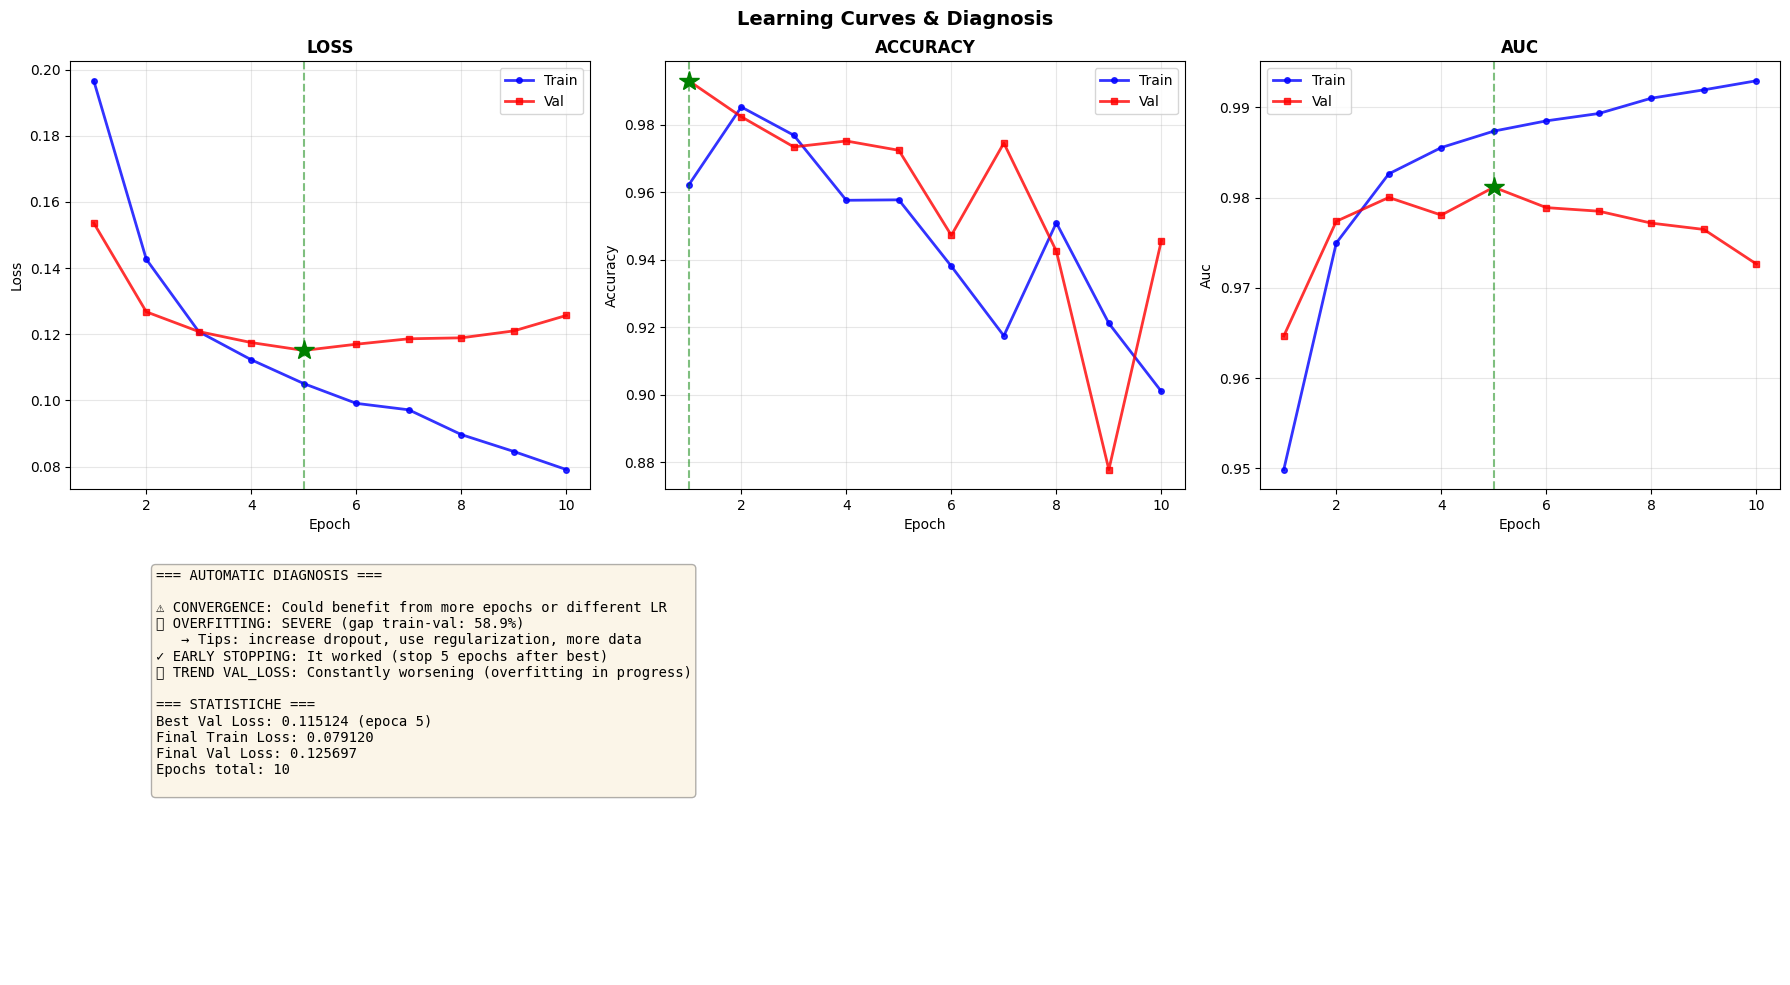


EVALUATION: model_2_LSTM_wloss



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.597642  0.712083        0.98422       0.987288      0.659744   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.835994      0.025749         0.897059

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.730726  0.846992  0.784575  0.977846  0.887523
1   severe_toxic   0.266497  0.875000  0.408560  0.988925  0.424798
2        obscene   0.695917  0.901342  0.785420  0.985886  0.890413
3         threat   0.284314  0.816901  0.421818  0.984699  0.460186
4         insult   0.588664  0.887479  0.707827  0.984328  0.793121
5  identity_hate   0.338614  0.810427  0.477654  0.983638  0.502424

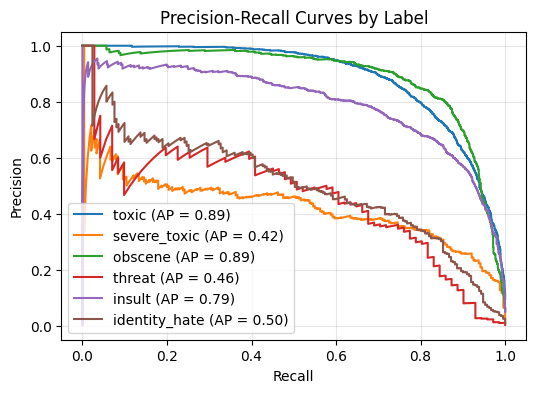

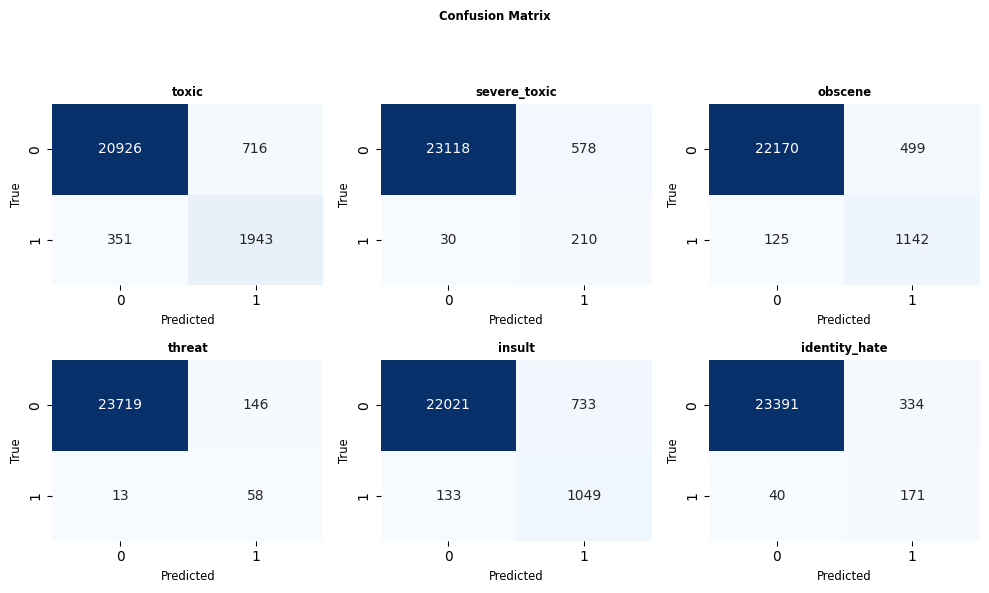

  Training time (s): 1759.31

EXPERIMENT: model_2_GRU_wloss



Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     70,272 │ embedding[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ gru[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,070,962 (23.16 MB)

 Trainable params: 70,662 (276.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8925 - auc: 0.9214 - loss: 0.2287

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 173s 98ms/step - accuracy: 0.9559 - auc: 0.9658 - loss: 0.1637 - val_accuracy: 0.9457 - val_auc: 0.9827 - val_loss: 0.1234 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9210 - auc: 0.9834 - loss: 0.1160

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 194s 93ms/step - accuracy: 0.9260 - auc: 0.9840 - loss: 0.1157 - val_accuracy: 0.9614 - val_auc: 0.9815 - val_loss: 0.1146 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9130 - auc: 0.9864 - loss: 0.1043

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 170s 97ms/step - accuracy: 0.9131 - auc: 0.9869 - loss: 0.1057 - val_accuracy: 0.7398 - val_auc: 0.9796 - val_loss: 0.1126 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 170s 97ms/step - accuracy: 0.8775 - auc: 0.9888 - loss: 0.0987 - val_accuracy: 0.9696 - val_auc: 0.9795 - val_loss: 0.1130 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.9142 - auc: 0.9905 - loss: 0.0914
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.8857 - auc: 0.9905 - loss: 0.0925 - val_accuracy: 0.8366 - val_auc: 0.9790 - val_loss: 0.1141 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 169s 97ms/step - accuracy: 0.8386 - auc: 0.9920 - loss: 0.0836 - val_accuracy: 0.8753 - val_auc: 0.9753 - val_loss: 0.1161 - learning_rate: 5.0000e-04
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8973 - auc: 0.

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_2_GRU_wloss_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


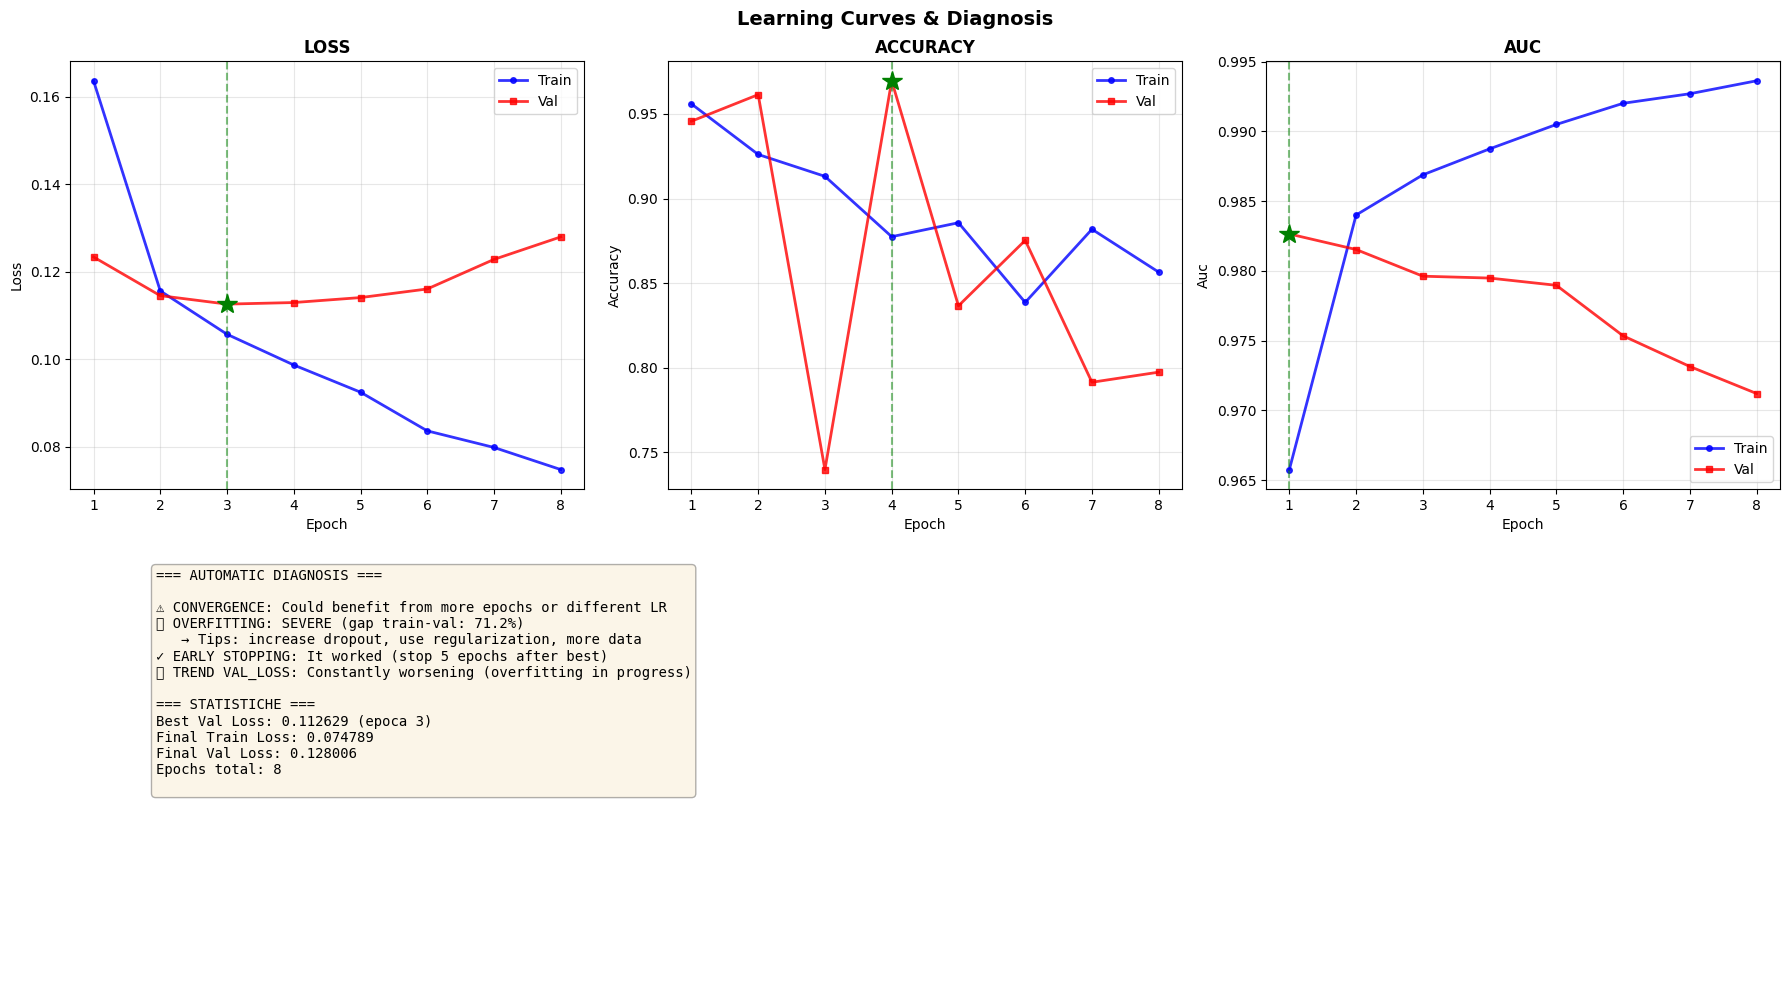


EVALUATION: model_2_GRU_wloss



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.622374  0.728545       0.984612        0.98749      0.674438   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.841799        0.0235         0.902699

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.758077  0.838710  0.796358  0.979716  0.894407
1   severe_toxic   0.294118  0.875000  0.440252  0.988818  0.432953
2        obscene   0.749496  0.880821  0.809869  0.986796  0.897519
3         threat   0.354839  0.774648  0.486726  0.981143  0.493151
4         insult   0.594104  0.886633  0.711473  0.985007  0.806502
5  identity_hate   0.346457  0.834123  0.489569  0.986193  0.522096

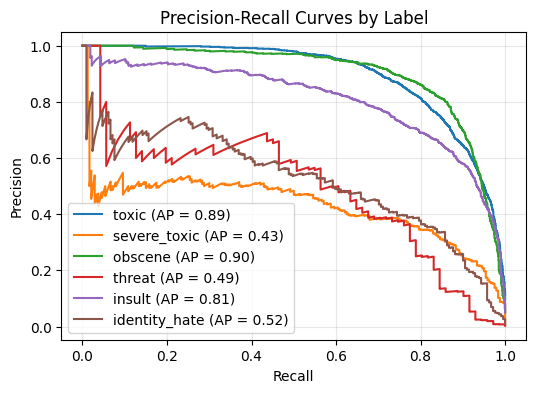

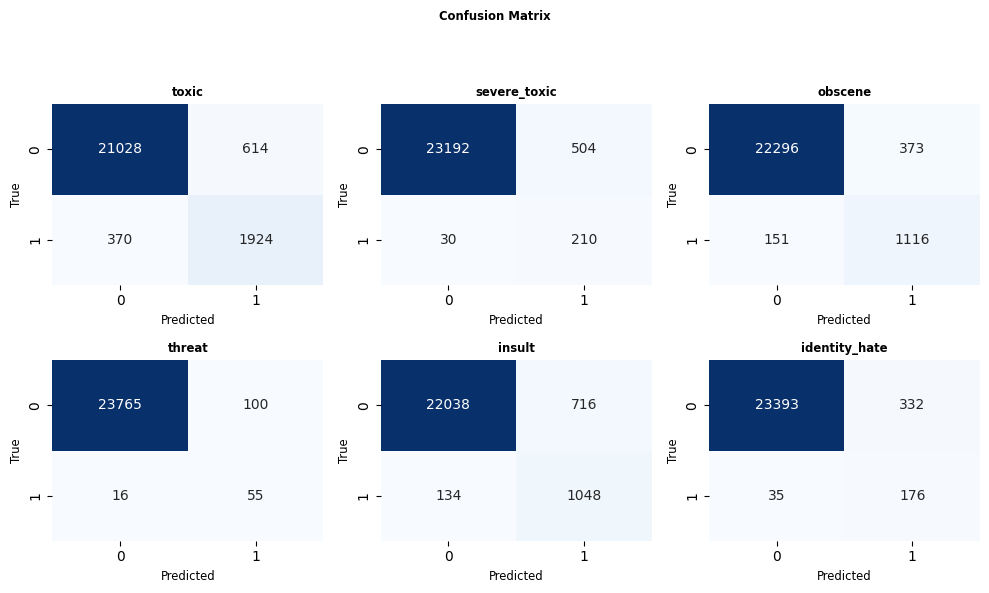

  Training time (s): 1386.15


In [ ]:
weights = compute_multilabel_class_weights_sqrt(y_train)
config_cw = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss': weighted_binary_crossentropy(weights),
    'loss_name': 'weighted_bce',
    'seed': SEED
}
experiments_2 = [
    {
        'name': 'model_2_LSTM_wloss',
        'builder': build_lstm(config=config_cw, embedding_matrix=embedding_matrix),
        'params': config_cw
    }, 
    {
        'name': 'model_2_GRU_wloss',
        'builder': build_gru(config=config_cw, embedding_matrix=embedding_matrix),
        'params': config_cw
    }
]
exp_res = run_experiments(experiments_2)
for res in exp_res: 
    all_results.append(res)

## Bidirectional LSTM, GRU


EXPERIMENT: model_3_BiLSTM



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 128)       │    186,880 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ bidirectional_ls… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,187,954 (23.61 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9130 - auc: 0.8763 - loss: 0.0953

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 269s 152ms/step - accuracy: 0.9743 - auc: 0.9370 - loss: 0.0660 - val_accuracy: 0.9936 - val_auc: 0.9592 - val_loss: 0.0497 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9914 - auc: 0.9617 - loss: 0.0499

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 265s 152ms/step - accuracy: 0.9882 - auc: 0.9656 - loss: 0.0489 - val_accuracy: 0.9930 - val_auc: 0.9666 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9835 - auc: 0.9739 - loss: 0.0457

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 264s 151ms/step - accuracy: 0.9835 - auc: 0.9747 - loss: 0.0449 - val_accuracy: 0.9828 - val_auc: 0.9726 - val_loss: 0.0453 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9812 - auc: 0.9788 - loss: 0.0417

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 265s 152ms/step - accuracy: 0.9788 - auc: 0.9792 - loss: 0.0420 - val_accuracy: 0.9888 - val_auc: 0.9719 - val_loss: 0.0436 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9794 - auc: 0.9819 - loss: 0.0398

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 263s 151ms/step - accuracy: 0.9763 - auc: 0.9826 - loss: 0.0401 - val_accuracy: 0.9721 - val_auc: 0.9731 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 264s 151ms/step - accuracy: 0.9623 - auc: 0.9862 - loss: 0.0381 - val_accuracy: 0.9719 - val_auc: 0.9728 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9665 - auc: 0.9850 - loss: 0.0365
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 266s 152ms/step - accuracy: 0.9612 - auc: 0.9864 - loss: 0.0363 - val_accuracy: 0.9300 - val_auc: 0.9689 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 263s 151ms/step - accuracy: 0.9350 - auc: 0.9896 - loss: 0.0328 - val_accuracy: 0.9461 - val_auc: 0.9689 - val_loss: 0.0440 - learning_rate: 5.0000e-04
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9165 - a

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_3_BiLSTM_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


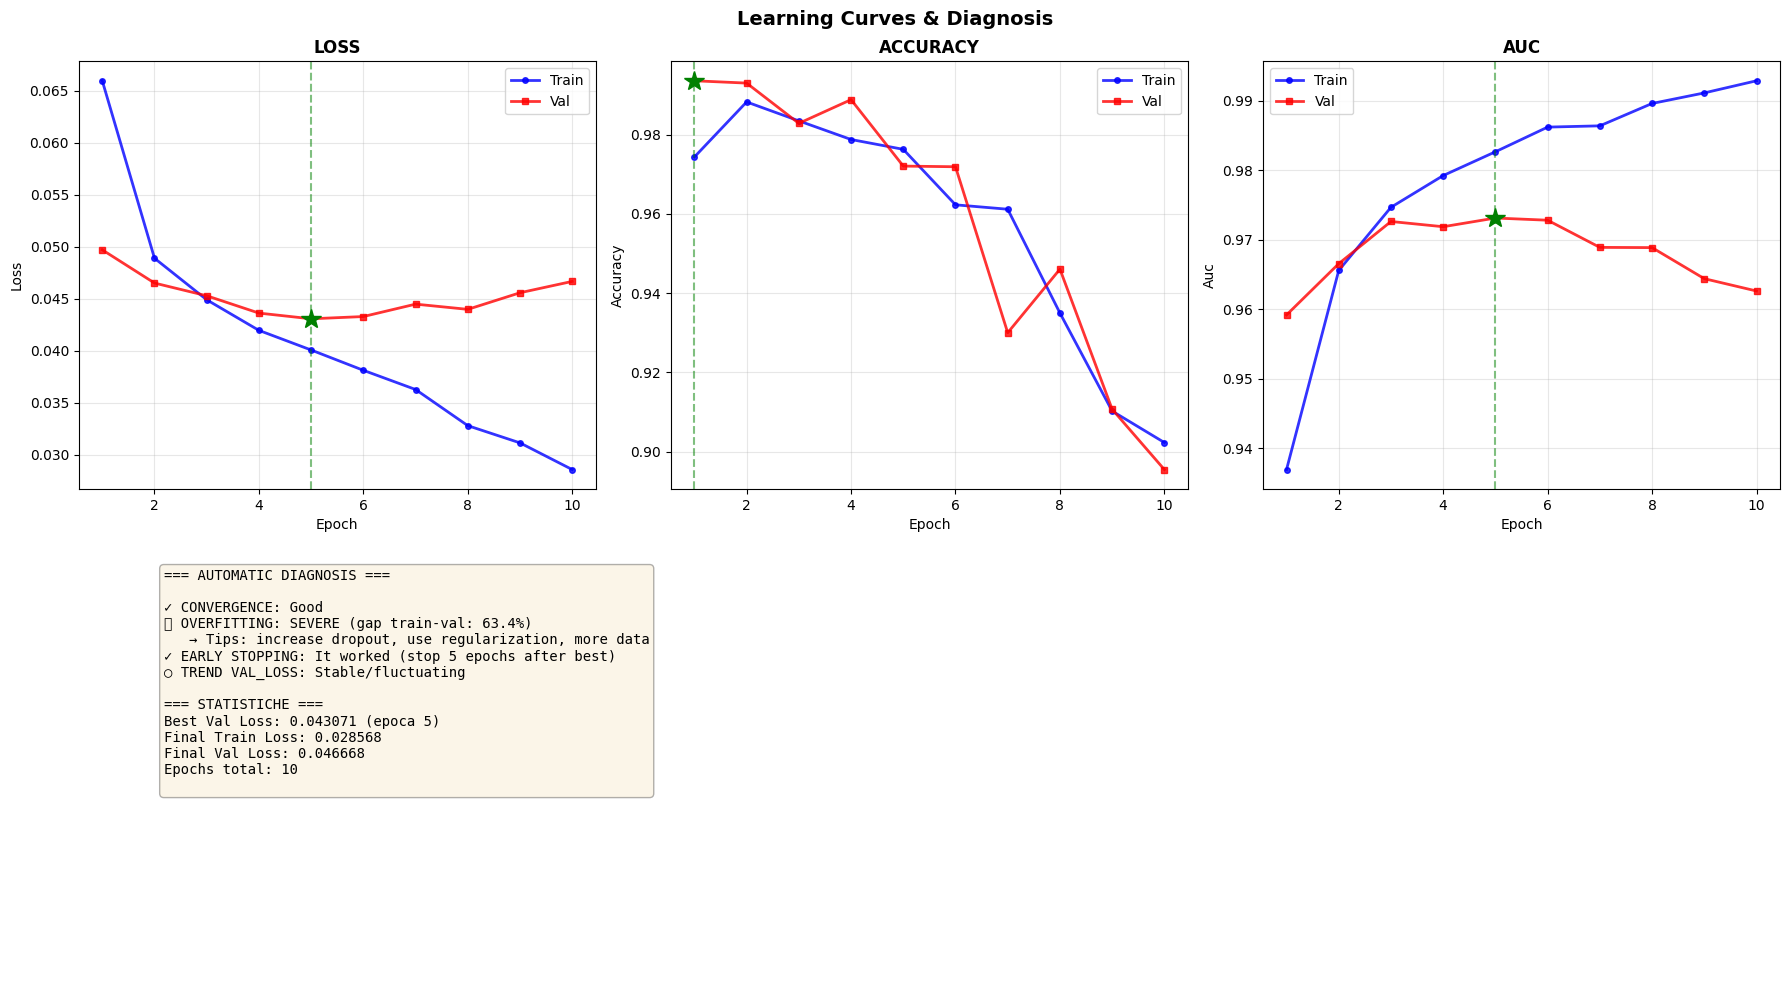


EVALUATION: model_3_BiLSTM



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0   0.62373  0.763226        0.98494       0.988453      0.673786   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.853844      0.015924         0.925886

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.882017  0.739756  0.804647  0.980045  0.894844
1   severe_toxic   0.500000  0.337500  0.402985  0.988822  0.436228
2        obscene   0.885662  0.770324  0.823976  0.986634  0.898032
3         threat   0.684211  0.366197  0.477064  0.985494  0.498371
4         insult   0.799024  0.692893  0.742184  0.985009  0.810850
5  identity_hate   0.608392  0.412322  0.491525  0.983638  0.504391

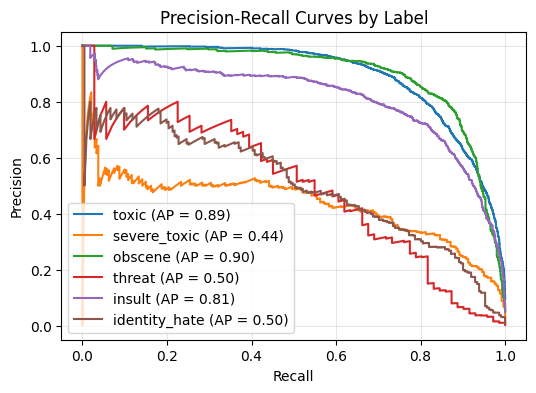

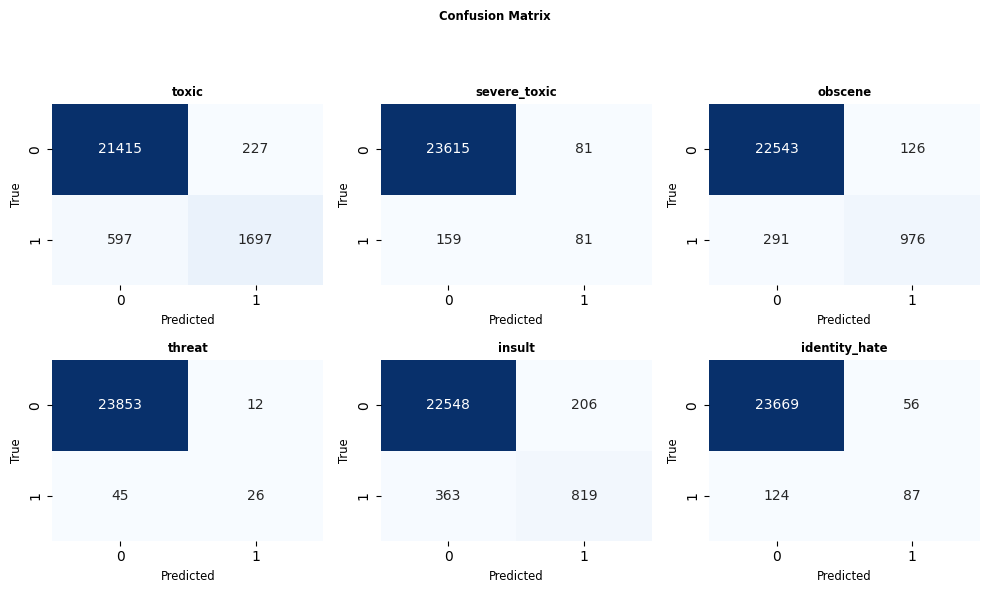

  Training time (s): 2664.73

EXPERIMENT: model_3_BiGRU



Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_5         │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_gru   │ (None, 128)       │    140,544 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ bidirectional_gr… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,141,618 (23.43 MB)

 Trainable params: 141,318 (552.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9011 - auc: 0.8976 - loss: 0.0902

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 247s 140ms/step - accuracy: 0.9604 - auc: 0.9533 - loss: 0.0585 - val_accuracy: 0.9799 - val_auc: 0.9784 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9655 - auc: 0.9782 - loss: 0.0443

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 258s 137ms/step - accuracy: 0.9645 - auc: 0.9769 - loss: 0.0436 - val_accuracy: 0.9635 - val_auc: 0.9754 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9222 - auc: 0.9808 - loss: 0.0402

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 243s 139ms/step - accuracy: 0.9368 - auc: 0.9824 - loss: 0.0407 - val_accuracy: 0.9283 - val_auc: 0.9726 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 244s 140ms/step - accuracy: 0.9268 - auc: 0.9843 - loss: 0.0384 - val_accuracy: 0.6563 - val_auc: 0.9718 - val_loss: 0.0440 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9207 - auc: 0.9863 - loss: 0.0357
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 243s 139ms/step - accuracy: 0.9128 - auc: 0.9865 - loss: 0.0360 - val_accuracy: 0.7734 - val_auc: 0.9674 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 242s 139ms/step - accuracy: 0.9088 - auc: 0.9901 - loss: 0.0323 - val_accuracy: 0.9207 - val_auc: 0.9629 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8491 - a

C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:140: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
C:\Users\Tia\AppData\Local\Temp\ipykernel_2660\687149832.py:143: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(save_path, dpi=300, bbox_inches='tight')


✓ Saved in: results/model_3_BiGRU_learning_curves.png


c:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\anti_hater_venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


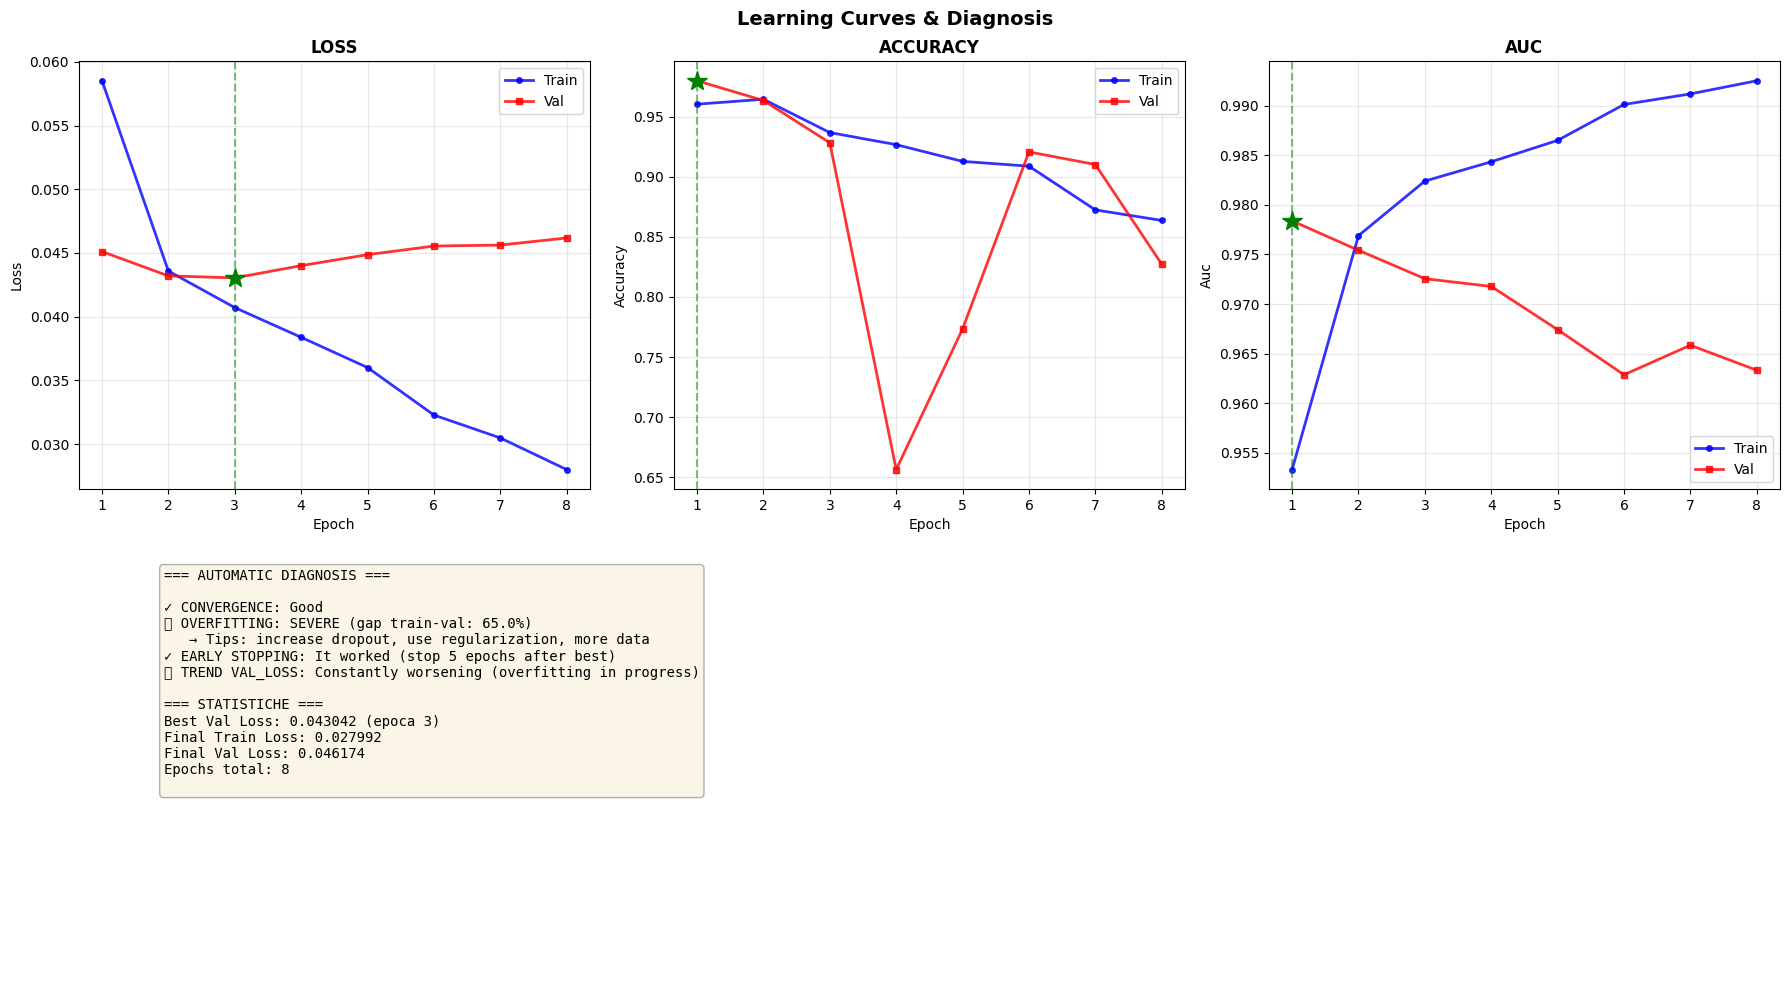


EVALUATION: model_3_BiGRU



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.595027  0.763879        0.98521        0.98851      0.677966   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.853813      0.016022         0.925343

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.885775  0.730166  0.800478  0.979970  0.894899
1   severe_toxic   0.514019  0.229167  0.317003  0.989293  0.441330
2        obscene   0.844644  0.815312  0.829719  0.986419  0.898160
3         threat   0.647059  0.309859  0.419048  0.986570  0.506303
4         insult   0.774396  0.731810  0.752501  0.985402  0.813810
5  identity_hate   0.666667  0.341232  0.451411  0.983605  0.513291

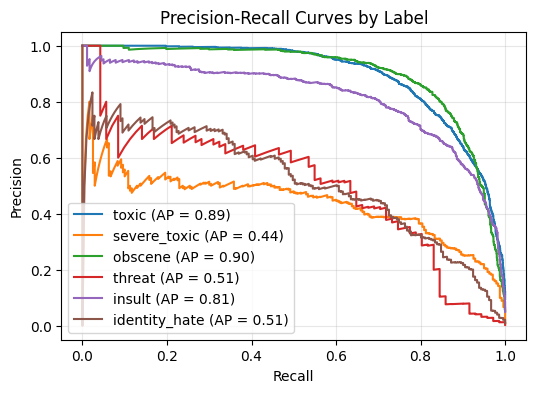

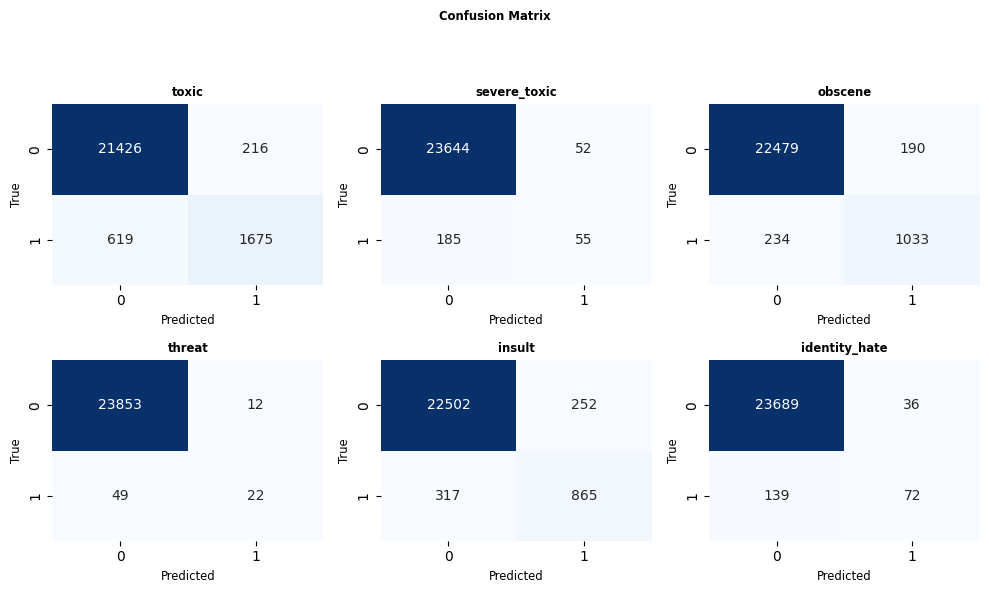

  Training time (s): 1963.38


In [ ]:
config_bidir = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss_name': 'bce',
    'bidirectional': True,
    'seed': SEED
}
experiments_3 = [
    {
        'name': 'model_3_BiLSTM',
        'builder': build_lstm(config=config_bidir, embedding_matrix=embedding_matrix),
        'params': config_bidir
    }, 
    {
        'name': 'model_3_BiGRU',
        'builder': build_gru(config=config_bidir, embedding_matrix=embedding_matrix),
        'params': config_bidir
    }
]
exp_res = run_experiments(experiments_3)
for res in exp_res: 
    all_results.append(res)

## Dropouts

To overcome the severe overfitting shown in the training I'm going to introduce a light dropout. The dropout is performed just on the best models based on F1 macro.

The models with weighted binary crossentropy have a significant increase in the hamming loss, so I'm going to esclude them.

- BiLSTM: will be trained with dropout and wit a narrow configuration (32 units) always with the aim of decreasing the overfitting and force the model to better generalize.
- GRU: insert the light dropout but aven a more complexity with 128 units.

In [126]:
config_bilstm_reg = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss_name': 'bce',
    'bidirectional': True,
    'emb_dr': 0.2,             
    'rnn_dr': 0.2,            
    'recurrent_dr': 0.0,       
    'pre_output_dr': 0.3,      
    'learning_rate': 0.001,
    'seed': 42
}

In [127]:

config_bilstm_32 = {
    'max_len': MAX_LEN,
    'rnn_units': 32,          
    'bidirectional': True, 
    'loss_name': 'bce',
    'emb_dr': 0.1,
    'rnn_dr': 0.1,
    'pre_output_dr': 0.2,
    'learning_rate': 0.001,
    'seed': 42
}

In [128]:

config_gru128 = {
    'max_len': MAX_LEN,
    'loss_name': 'bce',
    'rnn_units': 128,          
    'bidirectional': False,   
    'emb_dr': 0.2,
    'rnn_dr': 0.2,
    'pre_output_dr': 0.2,
    'learning_rate': 0.0005, 
    'seed': 42
}


EXPERIMENT: model_7_BiLSTM_Reg



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 200, 300)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_12        │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 128)       │    186,880 │ dropout_12[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_12[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ bidirectional_ls… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,187,954 (23.61 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7788 - auc: 0.8679 - loss: 0.0998

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 248s 140ms/step - accuracy: 0.8973 - auc: 0.9324 - loss: 0.0680 - val_accuracy: 0.9939 - val_auc: 0.9630 - val_loss: 0.0489 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9698 - auc: 0.9586 - loss: 0.0508

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 280s 160ms/step - accuracy: 0.9685 - auc: 0.9620 - loss: 0.0510 - val_accuracy: 0.9933 - val_auc: 0.9693 - val_loss: 0.0467 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9649 - auc: 0.9688 - loss: 0.0472

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 282s 161ms/step - accuracy: 0.9674 - auc: 0.9694 - loss: 0.0476 - val_accuracy: 0.9919 - val_auc: 0.9710 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.9757 - auc: 0.9746 - loss: 0.0457

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 282s 161ms/step - accuracy: 0.9658 - auc: 0.9745 - loss: 0.0454 - val_accuracy: 0.9888 - val_auc: 0.9720 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 282s 161ms/step - accuracy: 0.9480 - auc: 0.9778 - loss: 0.0438 - val_accuracy: 0.9904 - val_auc: 0.9694 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9607 - auc: 0.9785 - loss: 0.0419

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 283s 162ms/step - accuracy: 0.9513 - auc: 0.9777 - loss: 0.0428 - val_accuracy: 0.9868 - val_auc: 0.9708 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9390 - auc: 0.9800 - loss: 0.0412

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 284s 162ms/step - accuracy: 0.9418 - auc: 0.9814 - loss: 0.0414 - val_accuracy: 0.9887 - val_auc: 0.9729 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 284s 163ms/step - accuracy: 0.9387 - auc: 0.9809 - loss: 0.0404 - val_accuracy: 0.9606 - val_auc: 0.9760 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9123 - auc: 0.9830 - loss: 0.0389
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 284s 163ms/step - accuracy: 0.9070 - auc: 0.9819 - loss: 0.0393 - val_accuracy: 0.8950 - val_auc: 0.9739 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8833 - auc: 0.9858 - loss: 0.0373

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 284s 163ms/step - accuracy: 0.8956 - auc: 0.9852 - loss: 0.0374 - val_accuracy: 0.9631 - val_auc: 0.9745 - val_loss: 0.0428 - learning_rate: 5.0000e-04
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9148 - auc: 0.9855 - loss: 0.0358
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 285s 163ms/step - accuracy: 0.9118 - auc: 0.9850 - loss: 0.0366 - val_accuracy: 0.9733 - val_auc: 0.9718 - val_loss: 0.0434 - learning_rate: 5.0000e-04
Epoch 12/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 285s 163ms/step - accuracy: 0.9145 - auc: 0.9869 - loss: 0.0358 - val_accuracy: 0.9581 - val_auc: 0.9713 - val_loss: 0.0433 - learning_rate: 2.5000e-04
Epoch 13/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9107 - auc: 0.9870 - loss: 0.0348
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 283s 162ms/step - accuracy: 0.9110 - auc: 0.

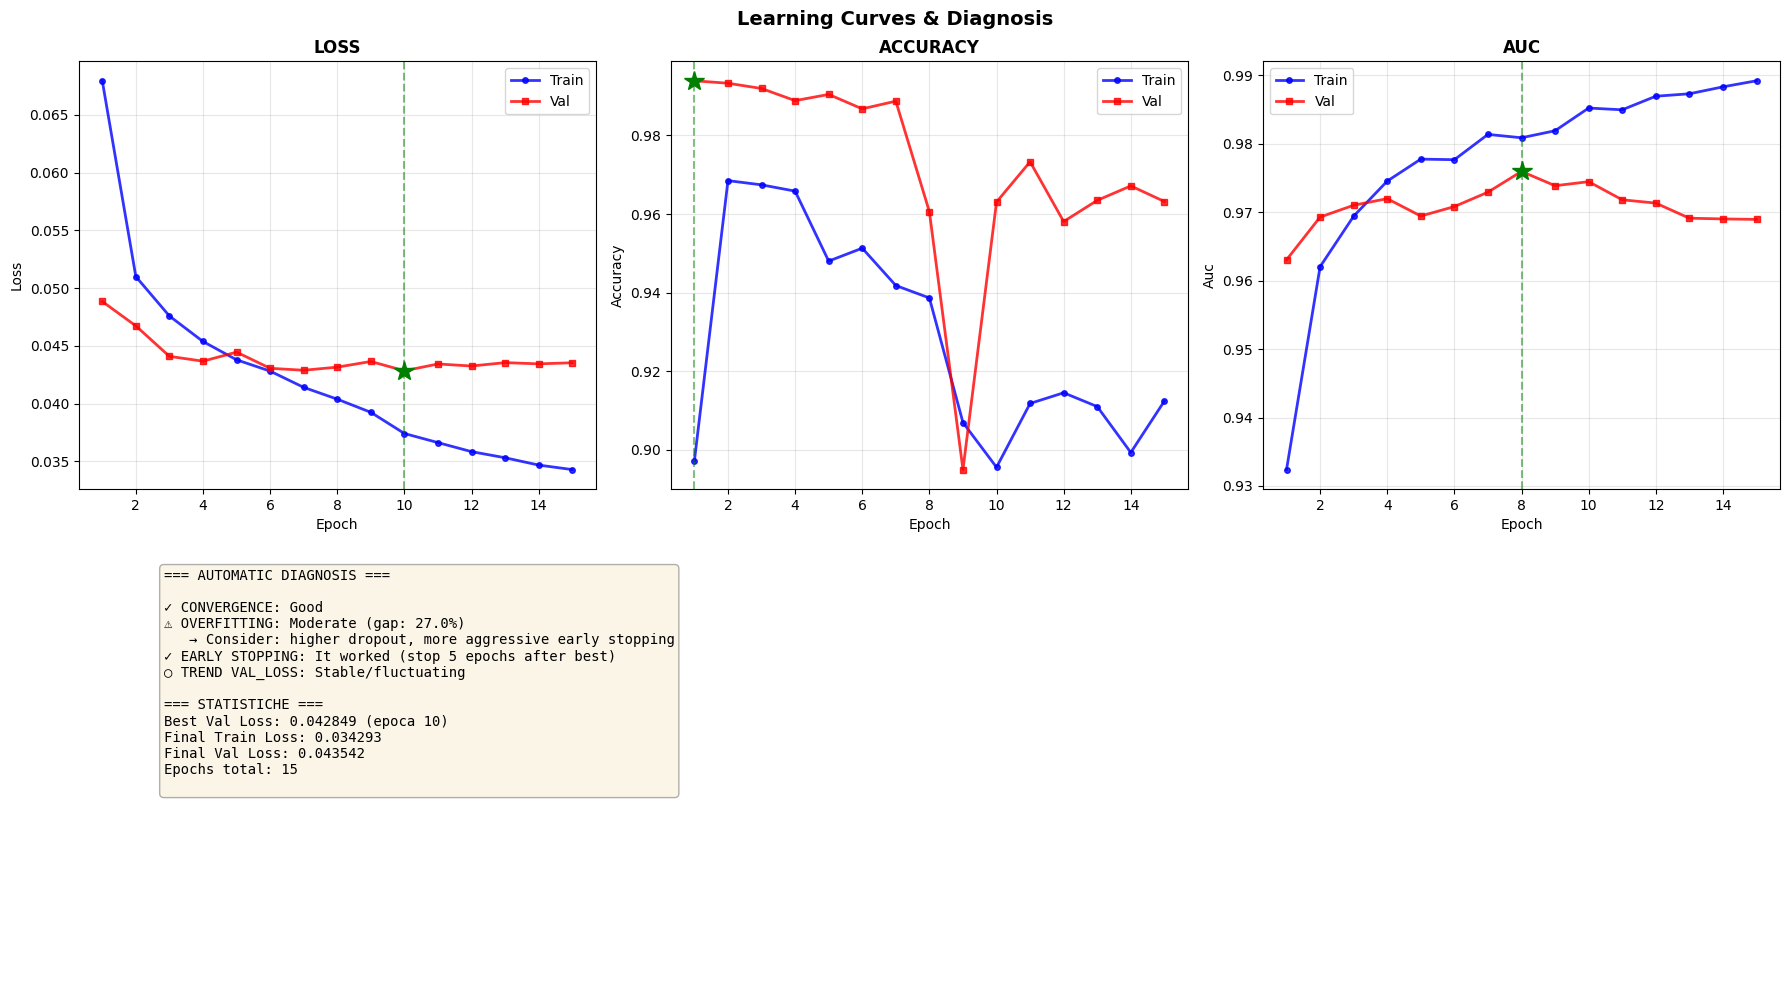


EVALUATION: model_7_BiLSTM_Reg



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.643882  0.771299       0.985609       0.989195      0.676254   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0        0.8558      0.016112         0.925468

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.858325  0.768527  0.810948  0.981271  0.898421
1   severe_toxic   0.479532  0.341667  0.399027  0.989355  0.431114
2        obscene   0.849789  0.794791  0.821370  0.987673  0.895086
3         threat   0.636364  0.492958  0.555556  0.984896  0.490680
4         insult   0.746959  0.779188  0.762733  0.985829  0.813643
5  identity_hate   0.606452  0.445498  0.513661  0.984631  0.528577

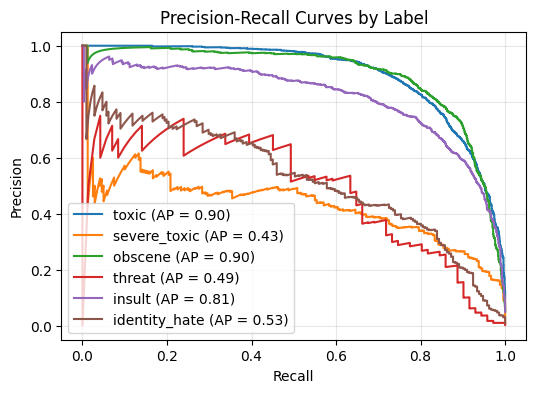

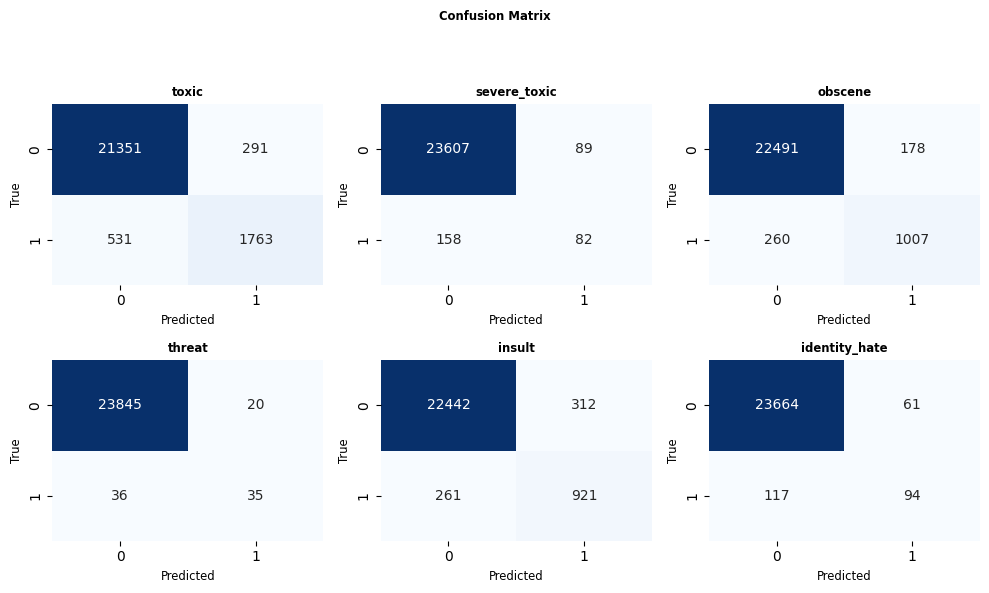

  Training time (s): 4212.93

EXPERIMENT: model_8_GRU_Simple128



Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 200, 300)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_13        │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 128)       │    165,120 │ dropout_14[0][0], │
│                     │                   │            │ not_equal_13[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ gru[0][0]         │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,166,194 (23.52 MB)

 Trainable params: 165,894 (648.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8111 - auc: 0.8531 - loss: 0.1120

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 331s 188ms/step - accuracy: 0.9069 - auc: 0.9274 - loss: 0.0707 - val_accuracy: 0.9924 - val_auc: 0.9613 - val_loss: 0.0501 - learning_rate: 5.0000e-04
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9271 - auc: 0.9622 - loss: 0.0522

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 323s 185ms/step - accuracy: 0.9310 - auc: 0.9650 - loss: 0.0510 - val_accuracy: 0.9906 - val_auc: 0.9668 - val_loss: 0.0455 - learning_rate: 5.0000e-04
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9273 - auc: 0.9684 - loss: 0.0486

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 186ms/step - accuracy: 0.9323 - auc: 0.9694 - loss: 0.0477 - val_accuracy: 0.9880 - val_auc: 0.9730 - val_loss: 0.0441 - learning_rate: 5.0000e-04
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9365 - auc: 0.9743 - loss: 0.0456

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 185ms/step - accuracy: 0.9370 - auc: 0.9757 - loss: 0.0458 - val_accuracy: 0.9927 - val_auc: 0.9715 - val_loss: 0.0435 - learning_rate: 5.0000e-04
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 186ms/step - accuracy: 0.9258 - auc: 0.9774 - loss: 0.0445 - val_accuracy: 0.9886 - val_auc: 0.9716 - val_loss: 0.0436 - learning_rate: 5.0000e-04
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9376 - auc: 0.9784 - loss: 0.0428

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 186ms/step - accuracy: 0.9280 - auc: 0.9784 - loss: 0.0431 - val_accuracy: 0.9754 - val_auc: 0.9748 - val_loss: 0.0425 - learning_rate: 5.0000e-04
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 326s 187ms/step - accuracy: 0.9259 - auc: 0.9793 - loss: 0.0420 - val_accuracy: 0.9433 - val_auc: 0.9699 - val_loss: 0.0440 - learning_rate: 5.0000e-04
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.9270 - auc: 0.9822 - loss: 0.0410
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 323s 185ms/step - accuracy: 0.9255 - auc: 0.9816 - loss: 0.0411 - val_accuracy: 0.9869 - val_auc: 0.9735 - val_loss: 0.0425 - learning_rate: 5.0000e-04
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9070 - auc: 0.9829 - loss: 0.0390

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 325s 186ms/step - accuracy: 0.9112 - auc: 0.9843 - loss: 0.0396 - val_accuracy: 0.9873 - val_auc: 0.9733 - val_loss: 0.0421 - learning_rate: 2.5000e-04
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 323s 185ms/step - accuracy: 0.9197 - auc: 0.9835 - loss: 0.0389 - val_accuracy: 0.9769 - val_auc: 0.9710 - val_loss: 0.0424 - learning_rate: 2.5000e-04
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.8906 - auc: 0.9812 - loss: 0.0390
Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 186ms/step - accuracy: 0.8999 - auc: 0.9840 - loss: 0.0385 - val_accuracy: 0.9883 - val_auc: 0.9724 - val_loss: 0.0421 - learning_rate: 2.5000e-04
Epoch 12/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 324s 186ms/step - accuracy: 0.9315 - auc: 0.9854 - loss: 0.0375 - val_accuracy: 0.9808 - val_auc: 0.9705 - val_loss: 0.0425 - learning_rate: 1.2500e-04
Epoch 13/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - acc

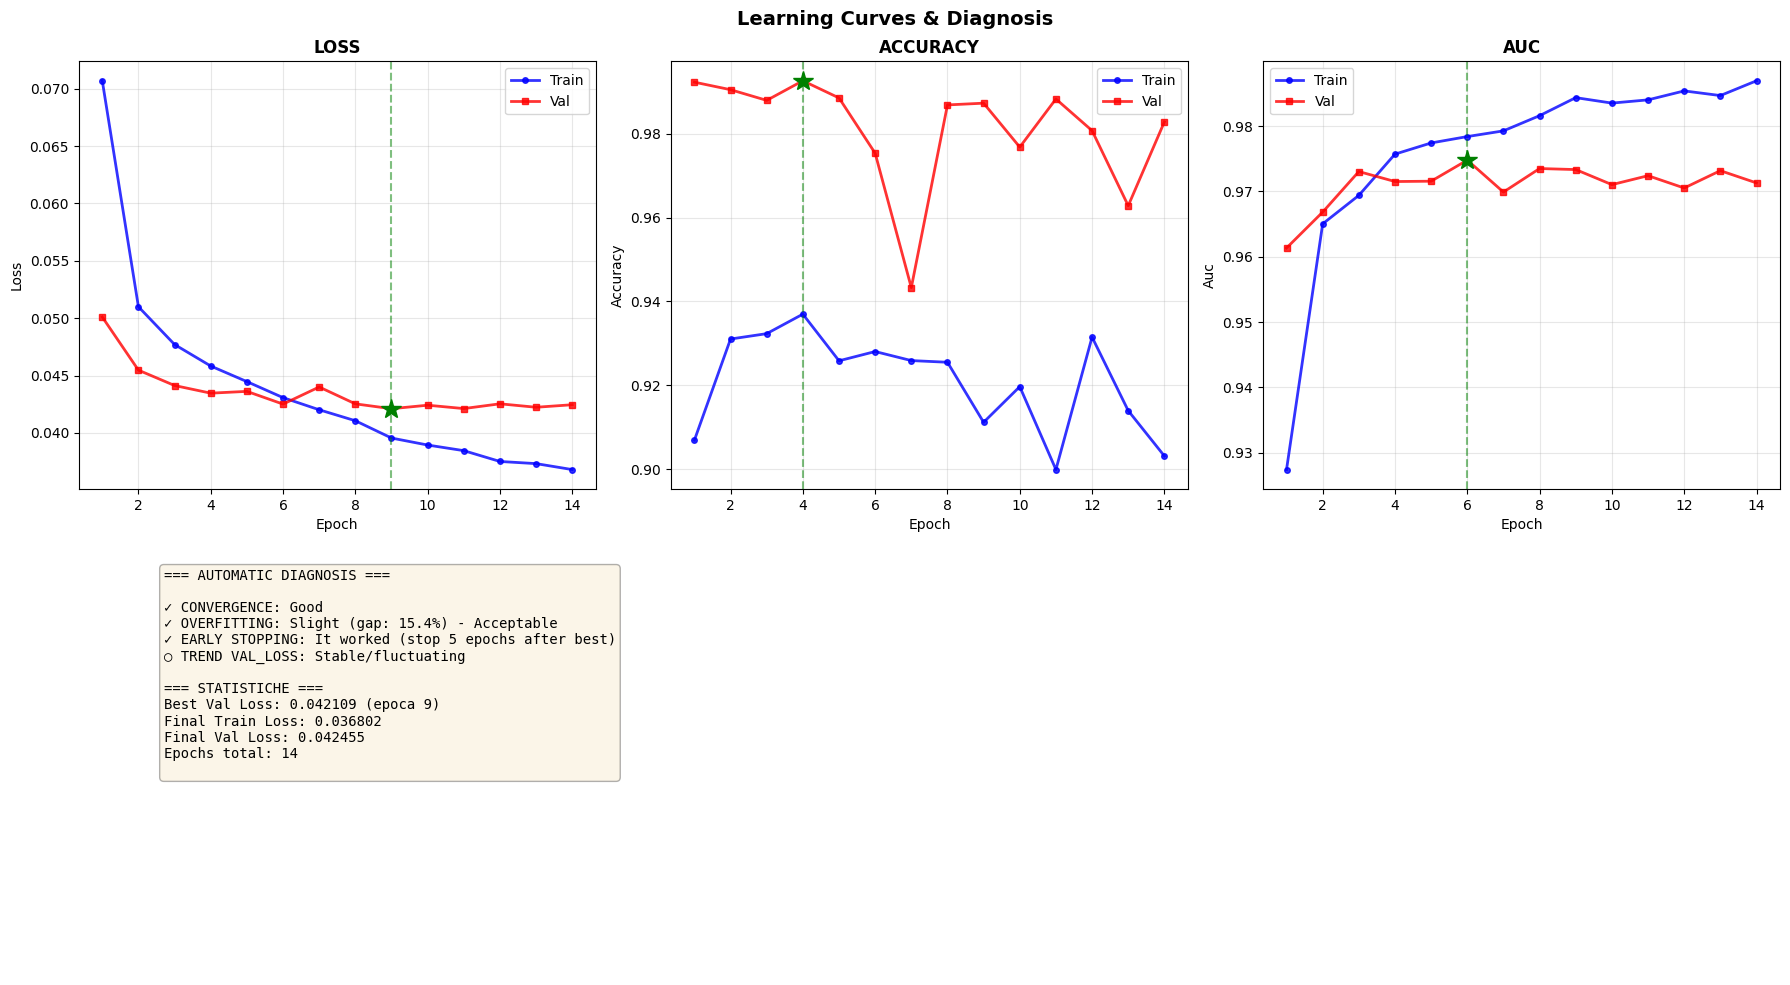


EVALUATION: model_8_GRU_Simple128



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.598826  0.769324       0.985246       0.988992      0.678683   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.858886      0.015959          0.92576

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.849165  0.775501  0.810663  0.981554  0.900488
1   severe_toxic   0.487395  0.241667  0.323120  0.988592  0.424169
2        obscene   0.853333  0.808208  0.830158  0.987319  0.900199
3         threat   0.636364  0.295775  0.403846  0.982776  0.489533
4         insult   0.783439  0.728426  0.754932  0.985973  0.818864
5  identity_hate   0.632000  0.374408  0.470238  0.985259  0.538847

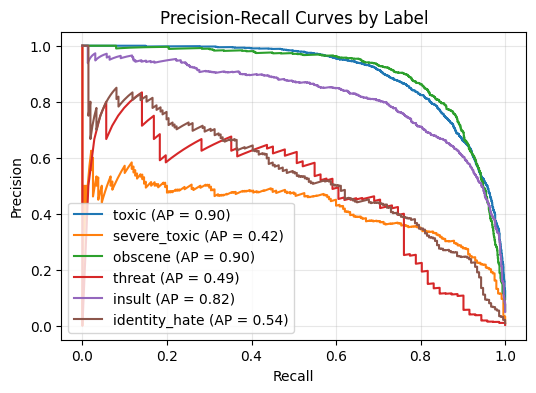

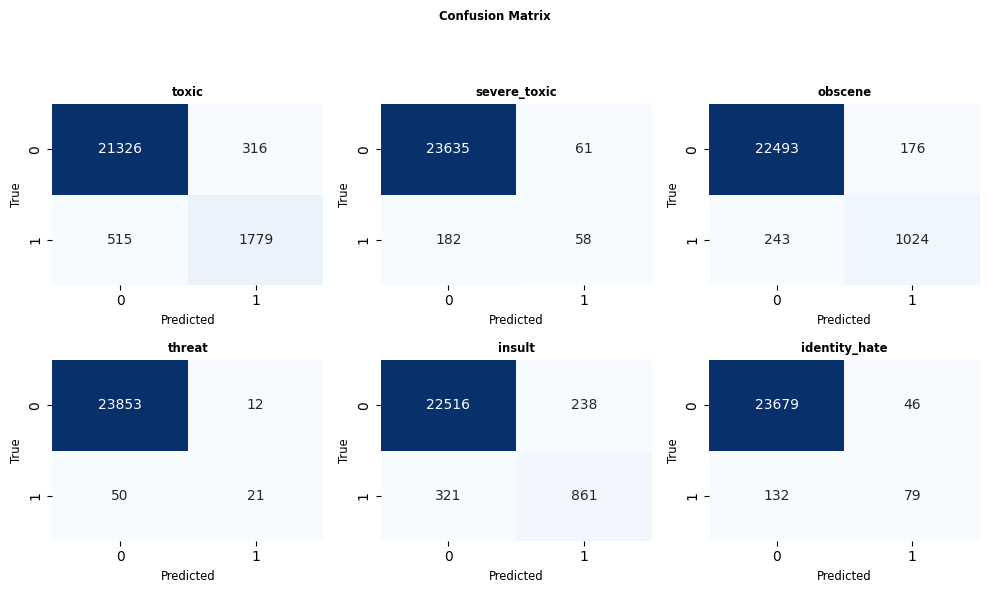

  Training time (s): 4537.34

EXPERIMENT: model_9_BiLSTM_32



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 200, 300)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_14        │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 64)        │     85,248 │ dropout_16[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_14[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 64)        │          0 │ bidirectional_ls… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        390 │ dropout_17[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,085,938 (23.22 MB)

 Trainable params: 85,638 (334.52 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.7046 - auc: 0.8555 - loss: 0.1146

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 181s 102ms/step - accuracy: 0.8552 - auc: 0.9175 - loss: 0.0761 - val_accuracy: 0.9938 - val_auc: 0.9556 - val_loss: 0.0551 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9650 - auc: 0.9477 - loss: 0.0549

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 179s 102ms/step - accuracy: 0.9668 - auc: 0.9532 - loss: 0.0538 - val_accuracy: 0.9938 - val_auc: 0.9677 - val_loss: 0.0491 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9738 - auc: 0.9691 - loss: 0.0500

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 178s 102ms/step - accuracy: 0.9602 - auc: 0.9668 - loss: 0.0503 - val_accuracy: 0.9933 - val_auc: 0.9713 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9444 - auc: 0.9704 - loss: 0.0469

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 177s 101ms/step - accuracy: 0.9558 - auc: 0.9713 - loss: 0.0472 - val_accuracy: 0.9927 - val_auc: 0.9689 - val_loss: 0.0455 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9595 - auc: 0.9723 - loss: 0.0453

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 180s 103ms/step - accuracy: 0.9530 - auc: 0.9723 - loss: 0.0455 - val_accuracy: 0.9921 - val_auc: 0.9744 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 186s 107ms/step - accuracy: 0.9499 - auc: 0.9767 - loss: 0.0441 - val_accuracy: 0.9858 - val_auc: 0.9698 - val_loss: 0.0446 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9467 - auc: 0.9768 - loss: 0.0428

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 209s 120ms/step - accuracy: 0.9539 - auc: 0.9781 - loss: 0.0428 - val_accuracy: 0.9854 - val_auc: 0.9749 - val_loss: 0.0428 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 185s 106ms/step - accuracy: 0.9401 - auc: 0.9793 - loss: 0.0415 - val_accuracy: 0.9878 - val_auc: 0.9745 - val_loss: 0.0432 - learning_rate: 0.0010
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9369 - auc: 0.9846 - loss: 0.0405
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 193s 111ms/step - accuracy: 0.9442 - auc: 0.9834 - loss: 0.0405 - val_accuracy: 0.9850 - val_auc: 0.9776 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 197s 113ms/step - accuracy: 0.9469 - auc: 0.9846 - loss: 0.0387 - val_accuracy: 0.9812 - val_auc: 0.9713 - val_loss: 0.0431 - learning_rate: 5.0000e-04
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9421 -

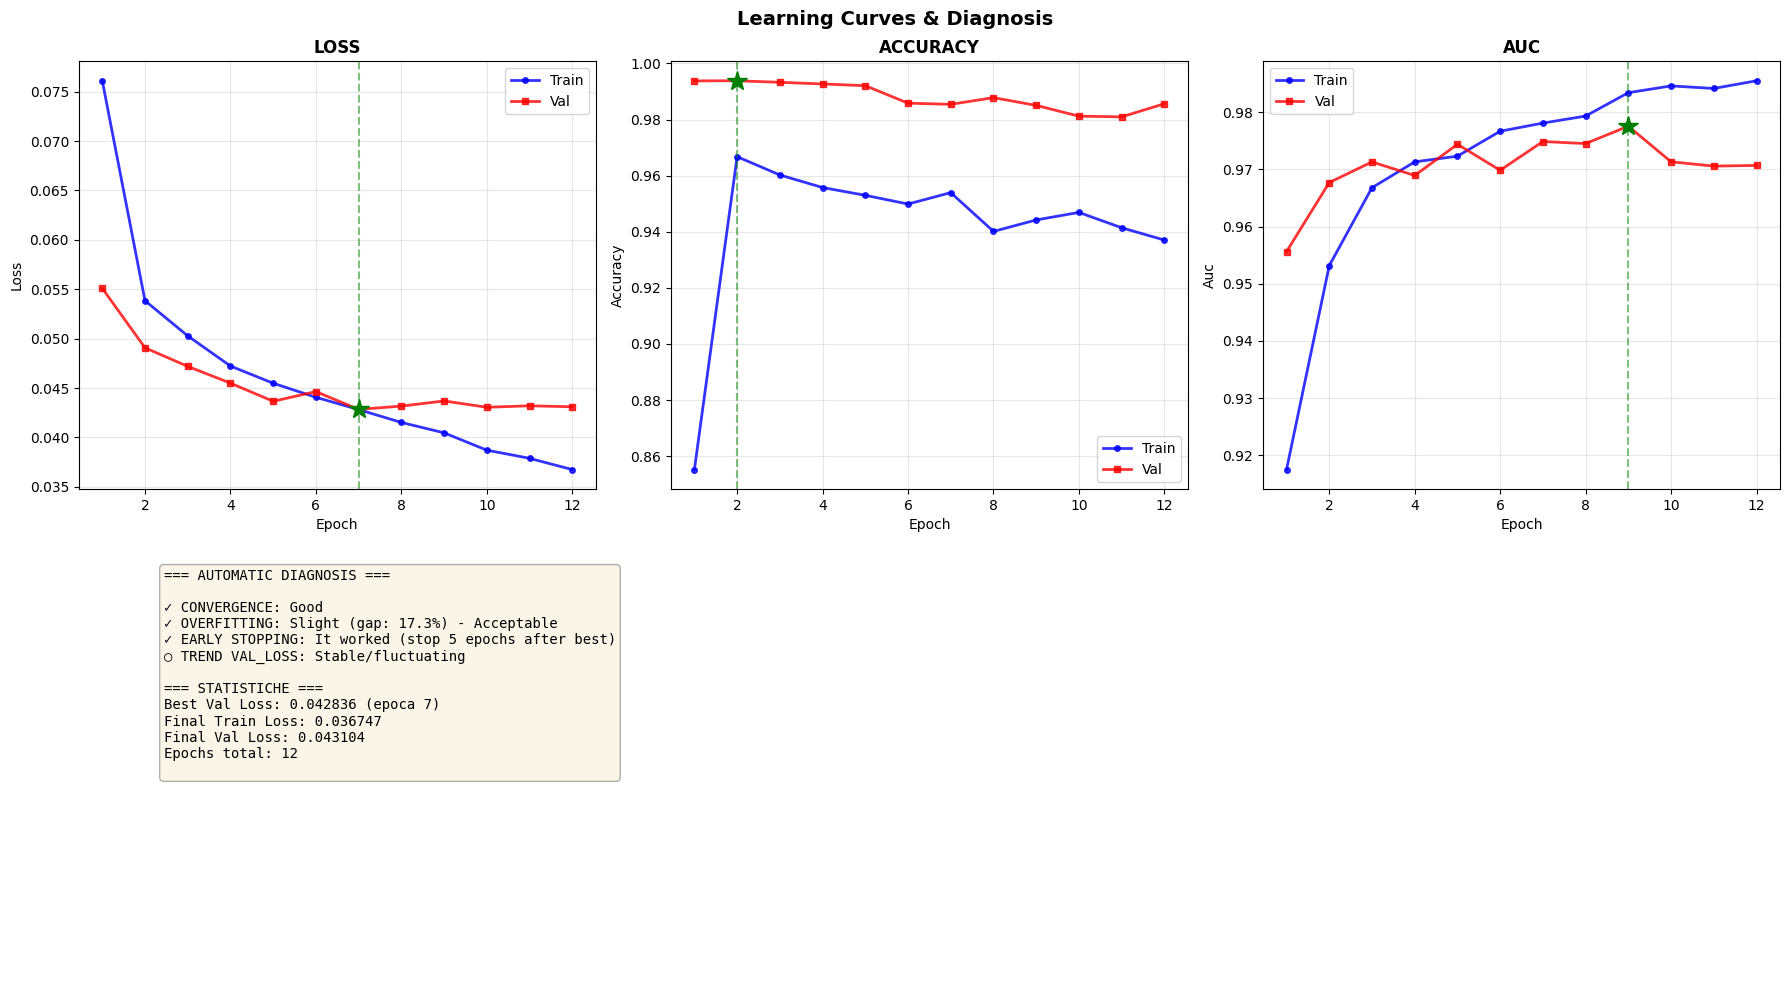


EVALUATION: model_9_BiLSTM_32



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0   0.61662  0.765871       0.985176       0.988618       0.67958   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.854514      0.015973         0.925886

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.872544  0.755013  0.809535  0.980216  0.896151
1   severe_toxic   0.522876  0.333333  0.407125  0.989309  0.461476
2        obscene   0.853470  0.786109  0.818406  0.986586  0.895727
3         threat   0.650000  0.366197  0.468468  0.987390  0.499029
4         insult   0.780129  0.717428  0.747466  0.985428  0.805604
5  identity_hate   0.693069  0.331754  0.448718  0.982126  0.519493

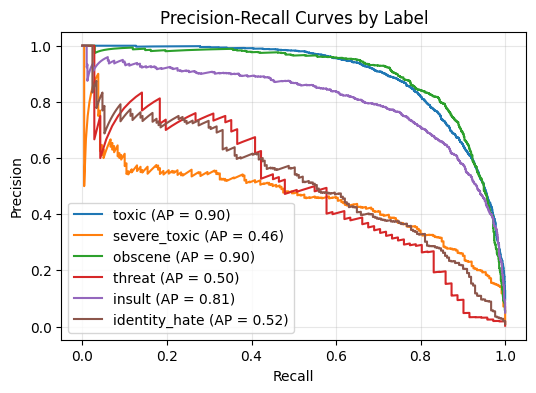

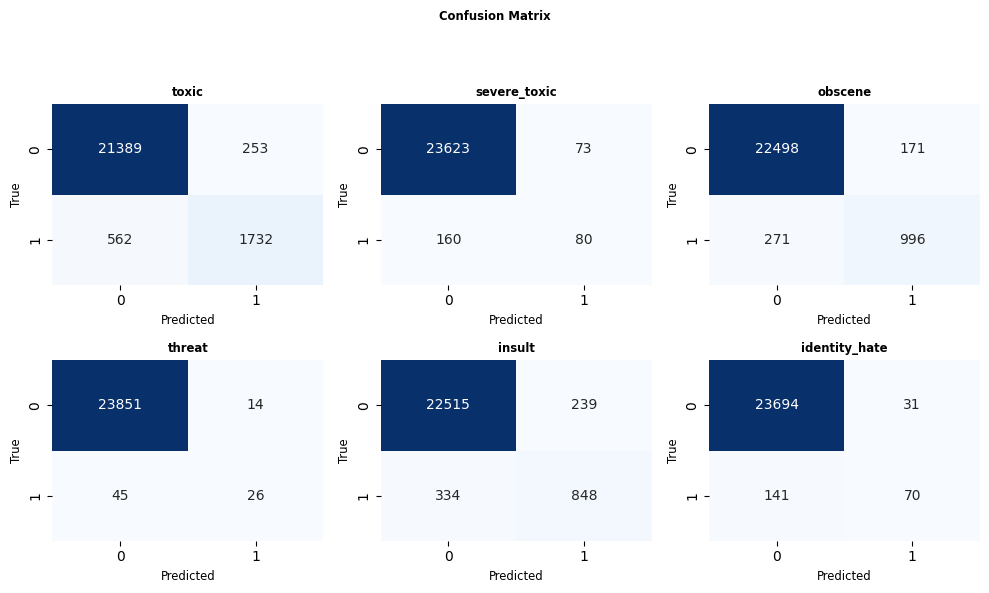

  Training time (s): 2270.49


In [129]:
experiments_4 = [
    {
        'name': 'model_7_BiLSTM_Reg',
        'builder': build_lstm(config=config_bilstm_reg, embedding_matrix=embedding_matrix),
        'params': config_bilstm_reg
    },
    {
        'name': 'model_8_GRU_Simple128',
        'builder': build_gru(config=config_gru128, embedding_matrix=embedding_matrix),
        'params': config_gru128
    },     
    {
        'name': 'model_9_BiLSTM_32',
        'builder': build_lstm(config=config_bilstm_32, embedding_matrix=embedding_matrix),
        'params': config_bilstm_32
    }
]
exp_res = run_experiments(experiments_4)
for res in exp_res: 
    all_results.append(res)

## Dropout 2

We test the same configuration of BiLSTM in the BiGRU model to see if perform better with a light dropout.

Usually the bottleneck for the overfitting is before the output layer so we test an increased pre_output_dr to 0.5.

In [155]:
config_bilstm_drop2 = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss_name': 'bce',
    'bidirectional': True,
    'emb_dr': 0.2,             
    'rnn_dr': 0.2,            
    'recurrent_dr': 0.0,       
    'pre_output_dr': 0.5,      
    'learning_rate': 0.001,
    'seed': 42
}


EXPERIMENT: model_10_BiGRU_Reg



Model: "GRU"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 200, 300)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_15        │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_gru   │ (None, 128)       │    140,544 │ dropout_18[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_19          │ (None, 128)       │          0 │ bidirectional_gr… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_19[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,141,618 (23.43 MB)

 Trainable params: 141,318 (552.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7741 - auc: 0.8703 - loss: 0.0988

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 263s 148ms/step - accuracy: 0.8741 - auc: 0.9358 - loss: 0.0650 - val_accuracy: 0.9901 - val_auc: 0.9645 - val_loss: 0.0471 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9239 - auc: 0.9662 - loss: 0.0490

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 311s 178ms/step - accuracy: 0.9075 - auc: 0.9693 - loss: 0.0486 - val_accuracy: 0.9886 - val_auc: 0.9732 - val_loss: 0.0441 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9012 - auc: 0.9747 - loss: 0.0456

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 303s 173ms/step - accuracy: 0.8979 - auc: 0.9741 - loss: 0.0463 - val_accuracy: 0.9885 - val_auc: 0.9732 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9072 - auc: 0.9764 - loss: 0.0437

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 318s 182ms/step - accuracy: 0.9078 - auc: 0.9762 - loss: 0.0444 - val_accuracy: 0.9907 - val_auc: 0.9699 - val_loss: 0.0429 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - accuracy: 0.8941 - auc: 0.9793 - loss: 0.0422

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 332s 190ms/step - accuracy: 0.9054 - auc: 0.9776 - loss: 0.0429 - val_accuracy: 0.9876 - val_auc: 0.9715 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.9224 - auc: 0.9814 - loss: 0.0418

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 339s 165ms/step - accuracy: 0.9114 - auc: 0.9807 - loss: 0.0417 - val_accuracy: 0.9807 - val_auc: 0.9723 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8979 - auc: 0.9818 - loss: 0.0400
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 291s 166ms/step - accuracy: 0.8891 - auc: 0.9808 - loss: 0.0407 - val_accuracy: 0.9455 - val_auc: 0.9692 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9046 - auc: 0.9839 - loss: 0.0384

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 298s 171ms/step - accuracy: 0.8955 - auc: 0.9837 - loss: 0.0389 - val_accuracy: 0.9205 - val_auc: 0.9715 - val_loss: 0.0424 - learning_rate: 5.0000e-04
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 309s 163ms/step - accuracy: 0.8663 - auc: 0.9858 - loss: 0.0379 - val_accuracy: 0.9685 - val_auc: 0.9712 - val_loss: 0.0430 - learning_rate: 5.0000e-04
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.8771 - auc: 0.9839 - loss: 0.0370
Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 296s 169ms/step - accuracy: 0.8766 - auc: 0.9856 - loss: 0.0373 - val_accuracy: 0.9703 - val_auc: 0.9702 - val_loss: 0.0425 - learning_rate: 5.0000e-04
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 305s 160ms/step - accuracy: 0.8920 - auc: 0.9869 - loss: 0.0362 - val_accuracy: 0.9612 - val_auc: 0.9729 - val_loss: 0.0428 - learning_rate: 2.5000e-04
Epoch 12/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accu

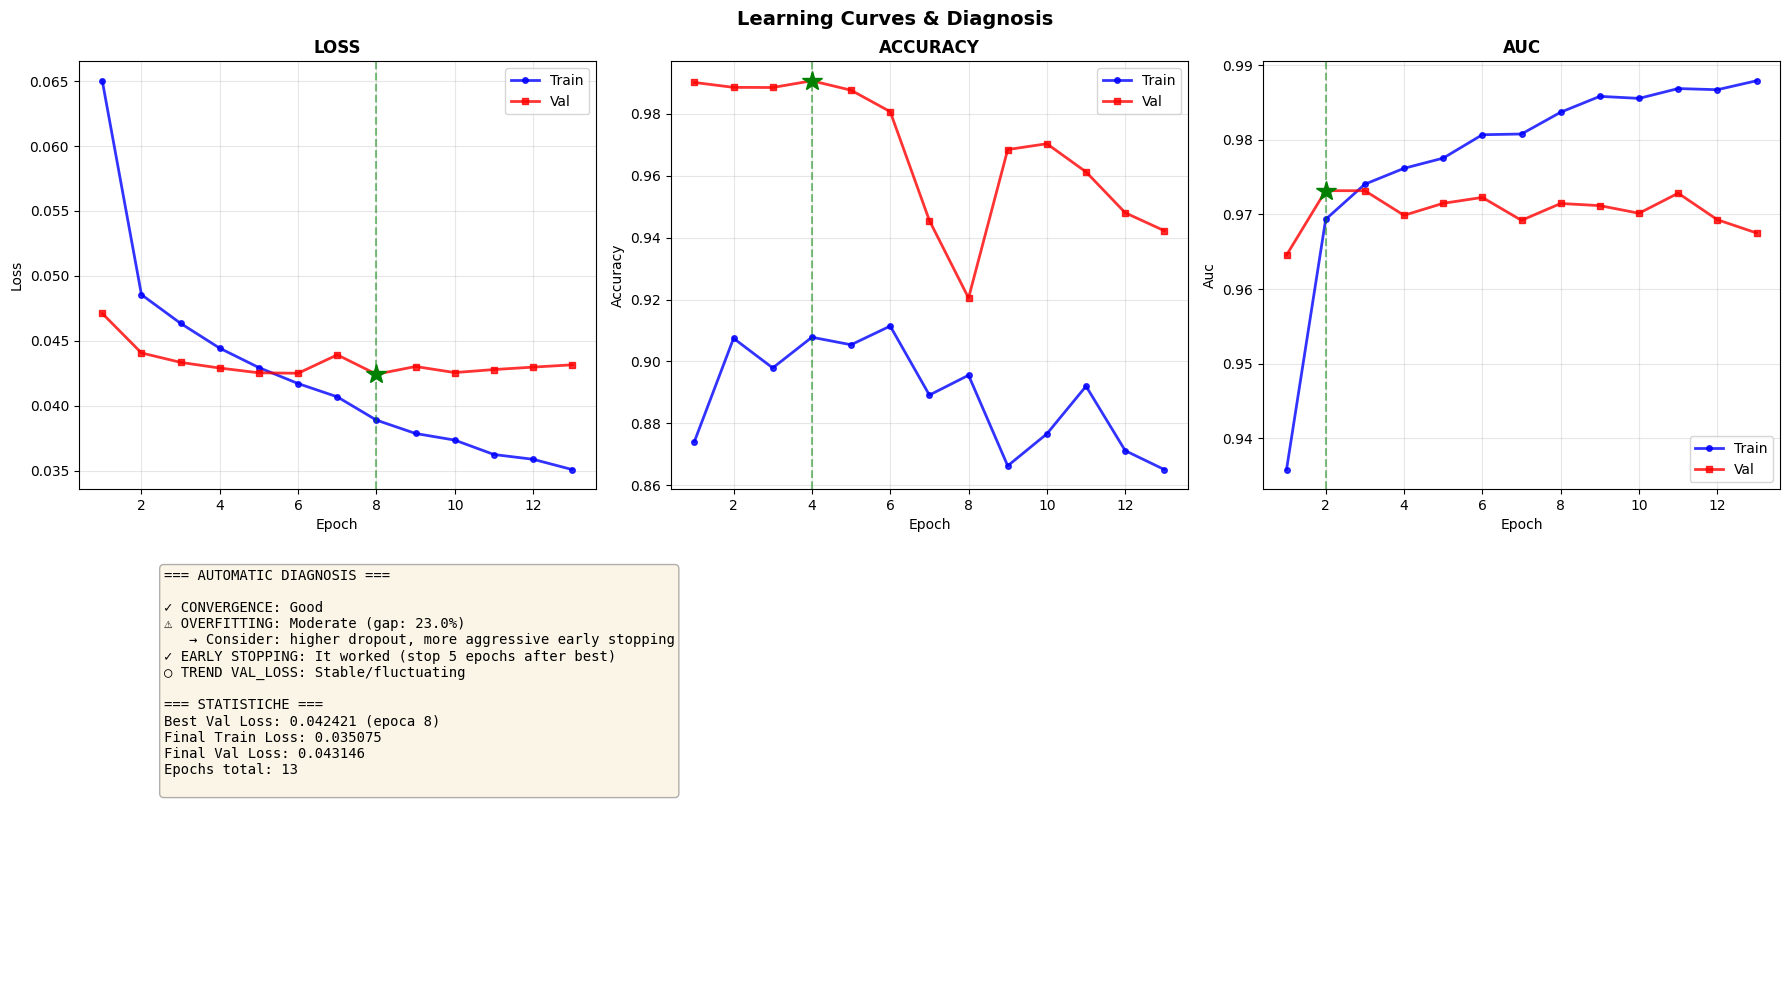


EVALUATION: model_10_BiGRU_Reg



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.628366  0.769138       0.985002       0.989005      0.688124   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0       0.85898      0.015938         0.925886

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.870435  0.758500  0.810622  0.981160  0.899913
1   severe_toxic   0.470199  0.295833  0.363171  0.988903  0.423280
2        obscene   0.849706  0.798737  0.823434  0.987159  0.899405
3         threat   0.622642  0.464789  0.532258  0.982775  0.534537
4         insult   0.773852  0.741117  0.757131  0.986262  0.818939
5  identity_hate   0.653226  0.383886  0.483582  0.983756  0.552667

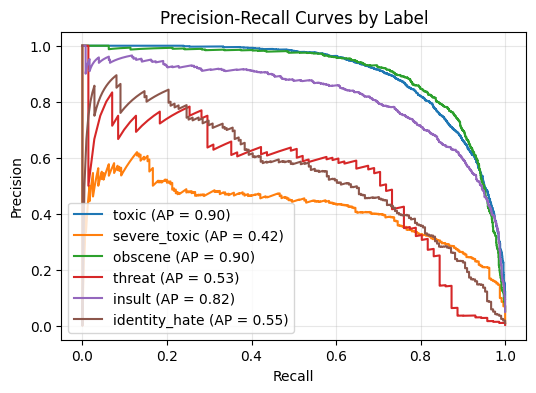

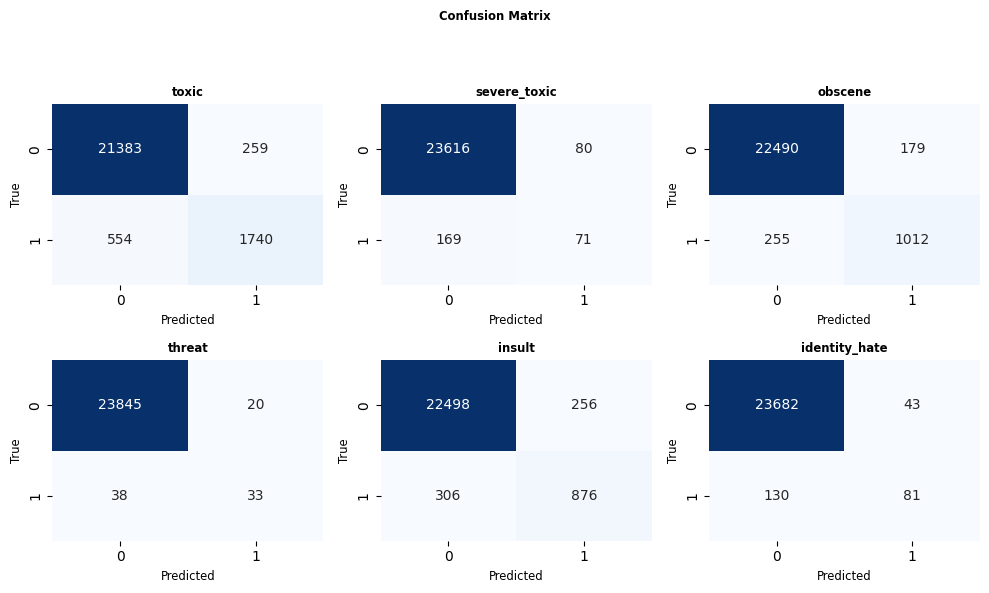

  Training time (s): 3926.58

EXPERIMENT: model_11_BiLSTM_drop2



Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 300)  │  6,000,300 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 200, 300)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_16        │ (None, 200)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_lstm  │ (None, 128)       │    186,880 │ dropout_20[0][0], │
│ (Bidirectional)     │                   │            │ not_equal_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_21          │ (None, 128)       │          0 │ bidirectional_ls… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 6)         │        774 │ dropout_21[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,187,954 (23.61 MB)

 Trainable params: 187,654 (733.02 KB)

 Non-trainable params: 6,000,300 (22.89 MB)

None
Epoch 1/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7256 - auc: 0.8520 - loss: 0.1063

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 293s 166ms/step - accuracy: 0.8596 - auc: 0.9241 - loss: 0.0721 - val_accuracy: 0.9939 - val_auc: 0.9598 - val_loss: 0.0514 - learning_rate: 0.0010
Epoch 2/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9548 - auc: 0.9557 - loss: 0.0532

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 291s 167ms/step - accuracy: 0.9583 - auc: 0.9580 - loss: 0.0528 - val_accuracy: 0.9939 - val_auc: 0.9648 - val_loss: 0.0477 - learning_rate: 0.0010
Epoch 3/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9526 - auc: 0.9607 - loss: 0.0501

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 291s 166ms/step - accuracy: 0.9538 - auc: 0.9642 - loss: 0.0494 - val_accuracy: 0.9933 - val_auc: 0.9720 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 4/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9251 - auc: 0.9633 - loss: 0.0483

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 289s 166ms/step - accuracy: 0.9435 - auc: 0.9684 - loss: 0.0477 - val_accuracy: 0.9938 - val_auc: 0.9709 - val_loss: 0.0445 - learning_rate: 0.0010
Epoch 5/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 289s 166ms/step - accuracy: 0.9442 - auc: 0.9718 - loss: 0.0459 - val_accuracy: 0.9916 - val_auc: 0.9733 - val_loss: 0.0452 - learning_rate: 0.0010
Epoch 6/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9448 - auc: 0.9756 - loss: 0.0446

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 289s 166ms/step - accuracy: 0.9465 - auc: 0.9737 - loss: 0.0442 - val_accuracy: 0.9933 - val_auc: 0.9716 - val_loss: 0.0435 - learning_rate: 0.0010
Epoch 7/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9366 - auc: 0.9730 - loss: 0.0430

1746/1746 ━━━━━━━━━━━━━━━━━━━━ 317s 163ms/step - accuracy: 0.9394 - auc: 0.9735 - loss: 0.0433 - val_accuracy: 0.9937 - val_auc: 0.9719 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 8/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 290s 166ms/step - accuracy: 0.9332 - auc: 0.9770 - loss: 0.0425 - val_accuracy: 0.9928 - val_auc: 0.9726 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 9/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9258 - auc: 0.9786 - loss: 0.0410
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 287s 164ms/step - accuracy: 0.9312 - auc: 0.9792 - loss: 0.0414 - val_accuracy: 0.9935 - val_auc: 0.9730 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 10/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 290s 166ms/step - accuracy: 0.9401 - auc: 0.9812 - loss: 0.0396 - val_accuracy: 0.9926 - val_auc: 0.9699 - val_loss: 0.0437 - learning_rate: 5.0000e-04
Epoch 11/20
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.9319 -

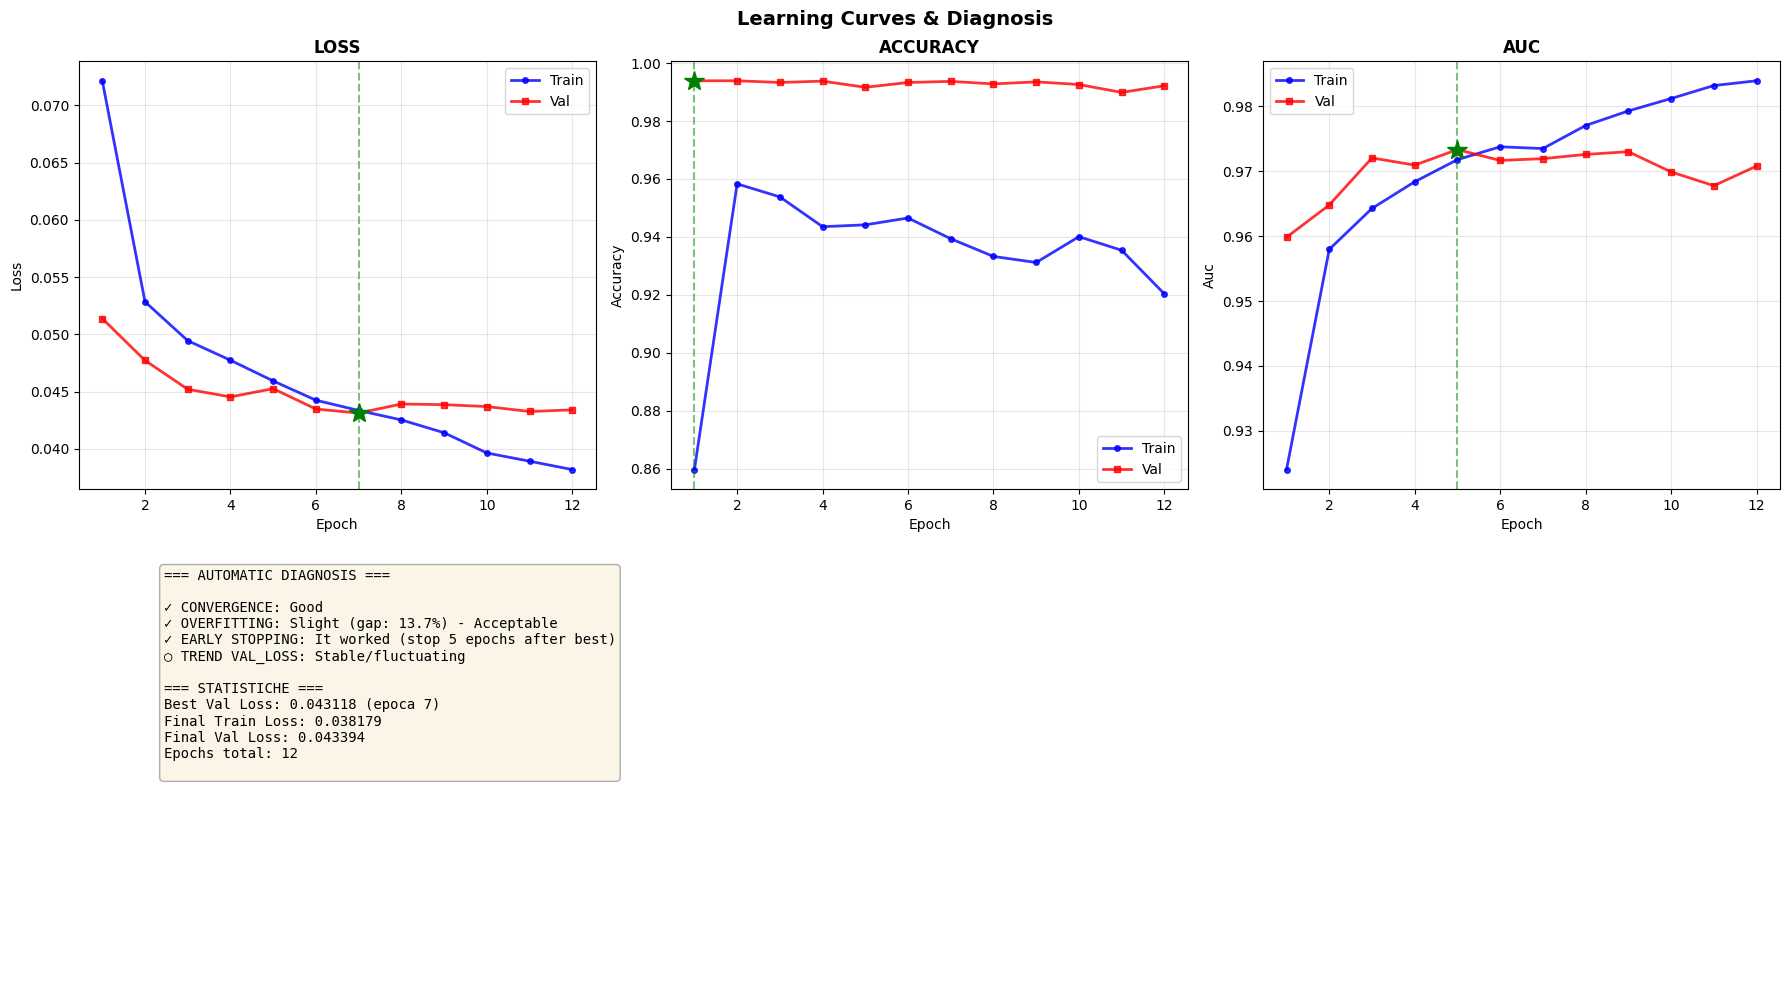


EVALUATION: model_11_BiLSTM_drop2



F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.608182  0.762239       0.983532       0.988166       0.66387   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.853751      0.016029          0.92622

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.883587  0.734525  0.802190  0.980306  0.896524
1   severe_toxic   0.514970  0.358333  0.422604  0.988842  0.438287
2        obscene   0.884718  0.781373  0.829841  0.986741  0.897496
3         threat   0.666667  0.253521  0.367347  0.977991  0.435876
4         insult   0.790183  0.694585  0.739307  0.984855  0.805348
5  identity_hate   0.569620  0.426540  0.487805  0.982455  0.509689

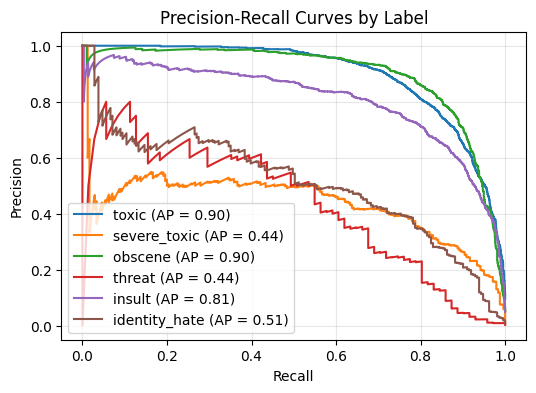

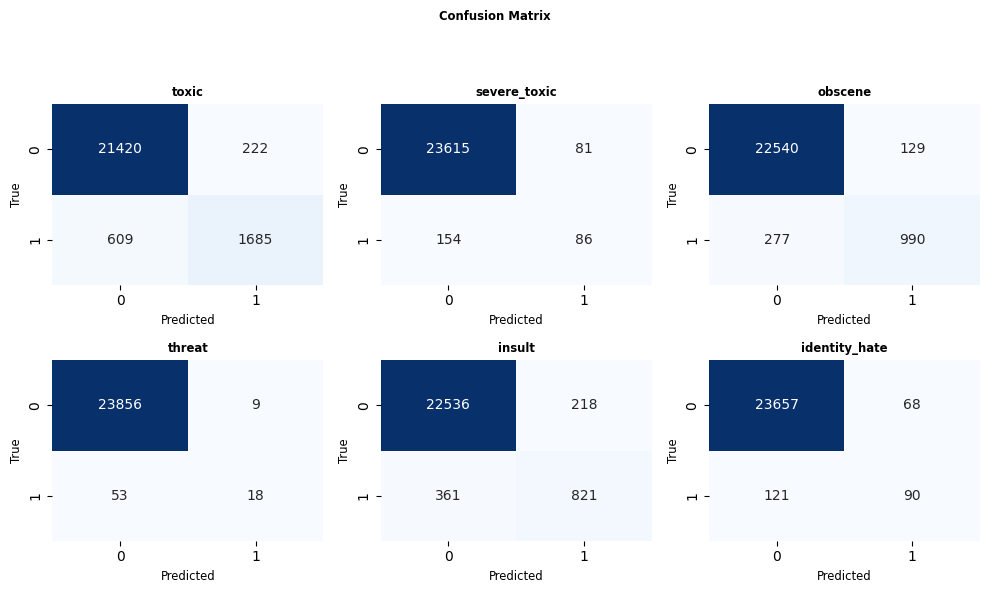

  Training time (s): 3506.26


In [156]:
experiments_5 = [
    {
        'name': 'model_10_BiGRU_Reg',
        'builder': build_gru(config=config_bilstm_reg, embedding_matrix=embedding_matrix),
        'params': config_bilstm_reg
    },
    {
        'name': 'model_11_BiLSTM_drop2',
        'builder': build_lstm(config=config_bilstm_drop2, embedding_matrix=embedding_matrix),
        'params': config_bilstm_drop2
    }
]
exp_res = run_experiments(experiments_5)
for res in exp_res: 
    all_results.append(res)

## Prepare results

Save the dict in the results list as a pd.Dataframe

In [157]:
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'F1_Macro': r['f1_macro'],
        'F1_Micro': r['f1_micro'],
        'ROC_AUC': r['roc_auc_macro'],
        'PR_AUC': r['pr_auc_macro'],
        'Hamming_Loss': r['hamming_loss'],
        'Subset_Accuracy': r['subset_accuracy'],
        'Overfitting': r['overfitting'],
        'Time(min)': r['training_time_seconds']/60,
        'Params': r['total_params'],
        'Epochs': r['epochs_trained'],
        'Loss': r['loss_function'],
        'Embedding_Trainable': r['embedding_trainable'],
        'RNN_units': r['units'] if 'units' in r else None,
        'Dropout' : r['dropout'] if 'dropout' in r else None
    }
    for r in all_results
])

per_label_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Label': label,
        'F1': r['f1_per_label'][i],
        'Precision': r['precision_per_label'][i],
        'Recall': r['recall_per_label'][i],
        'ROC-AUC': r['roc_auc_per_label'][i],
        'PR-AUC': r['pr_auc_per_label'][i],
    }
    for r in all_results
    for i, label in enumerate(LABEL_NAMES)
])

In [ ]:
# concatenate results with baseline
total_resume_df = pd.concat([total_resume_df, comparison_df], ignore_index=True)
per_label_resume_df = pd.concat([per_label_resume_df, per_label_df], ignore_index=True)

In [182]:
total_resume_df.sort_values('F1_Macro', ascending=False)

Model  F1_Macro  F1_Micro   ROC_AUC    PR_AUC  \
7      model_7_BiLSTM_Reg  0.643882  0.771299  0.985609  0.676254   
10     model_10_BiGRU_Reg  0.628366  0.769138  0.985002  0.688124   
5          model_3_BiLSTM  0.623730  0.763226  0.984940  0.673786   
4       model_2_GRU_wloss  0.622374  0.728545  0.984612  0.674438   
9       model_9_BiLSTM_32  0.616620  0.765871  0.985176  0.679580   
2      model_1_GRU_simple  0.608867  0.768196  0.984663  0.673267   
11  model_11_BiLSTM_drop2  0.608182  0.762239  0.983532  0.663870   
8   model_8_GRU_Simple128  0.598826  0.769324  0.985246  0.678683   
3      model_2_LSTM_wloss  0.597642  0.712083  0.984220  0.659744   
6           model_3_BiGRU  0.595027  0.763879  0.985210  0.677966   
1     model_1_LSTM_simple  0.589236  0.764099  0.983727  0.660877   
0       Baseline_LR_TFIDF  0.565567  0.680816  0.981397  0.649908   

    Hamming_Loss  Subset_Accuracy  Overfitting  Time(min)     Params  Epochs  \
7       0.016112         0.925468    26.968508  70.215455  6187954.0    15.0   
10      0.015938         0.925886    23.007922  65.443007  6141618.0    13.0   
5       0.015924         0.925886    63.355616  44.412199  6187954.0    10.0   
4       0.023500         0.902699    71.156531  23.102534  6070962.0     8.0   
9       0.015973         0.925886    17.299426  37.841555  6085938.0    12.0   
2       0.016078         0.924716    64.790048  28.156511  6070962.0    10.0   
11      0.016029         0.926220    13.660436  58.437731  6187954.0    12.0   
8       0.015959         0.925760    15.363023  75.622333  6166194.0    14.0   
3       0.025749         0.897059    58.868485  29.321862  6094130.0    10.0   
6       0.016022         0.925343    64.951351  32.723024  6141618.0     8.0   
1       0.016252         0.924423    55.742628  32.096788  6094130.0    11.0   
0       0.029530         0.879888          NaN        NaN        NaN     NaN   

            Loss Embedding_Trainable  RNN_units  \
7            bce               False       64.0   
10           bce               False       64.0   
5            bce               False       64.0   
4   weighted_bce               False       64.0   
9            bce               False       32.0   
2            bce               False       64.0   
11           bce               False       64.0   
8            bce               False      128.0   
3   weighted_bce               False       64.0   
6            bce               False       64.0   
1            bce               False       64.0   
0            NaN                 NaN        NaN   

                                              Dropout  
7   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
10  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
5                                                None  
4                                                None  
9   {'emb_dr': 0.1, 'rnn_dr': 0.1, 'pre_output_dr'...  
2                                                None  
11  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
8   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
3                                                None  
6                                                None  
1                                                None  
0                                                 NaN

In [183]:
total_resume_df.sort_values('F1_Macro', ascending=False)[:5]

Model  F1_Macro  F1_Micro   ROC_AUC    PR_AUC  Hamming_Loss  \
7   model_7_BiLSTM_Reg  0.643882  0.771299  0.985609  0.676254      0.016112   
10  model_10_BiGRU_Reg  0.628366  0.769138  0.985002  0.688124      0.015938   
5       model_3_BiLSTM  0.623730  0.763226  0.984940  0.673786      0.015924   
4    model_2_GRU_wloss  0.622374  0.728545  0.984612  0.674438      0.023500   
9    model_9_BiLSTM_32  0.616620  0.765871  0.985176  0.679580      0.015973   

    Subset_Accuracy  Overfitting  Time(min)     Params  Epochs          Loss  \
7          0.925468    26.968508  70.215455  6187954.0    15.0           bce   
10         0.925886    23.007922  65.443007  6141618.0    13.0           bce   
5          0.925886    63.355616  44.412199  6187954.0    10.0           bce   
4          0.902699    71.156531  23.102534  6070962.0     8.0  weighted_bce   
9          0.925886    17.299426  37.841555  6085938.0    12.0           bce   

   Embedding_Trainable  RNN_units  \
7                False       64.0   
10               False       64.0   
5                False       64.0   
4                False       64.0   
9                False       32.0   

                                              Dropout  
7   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
10  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
5                                                None  
4                                                None  
9   {'emb_dr': 0.1, 'rnn_dr': 0.1, 'pre_output_dr'...

In [184]:
total_resume_df.sort_values('Hamming_Loss', ascending=True)[:5]

Model  F1_Macro  F1_Micro   ROC_AUC    PR_AUC  \
5          model_3_BiLSTM  0.623730  0.763226  0.984940  0.673786   
10     model_10_BiGRU_Reg  0.628366  0.769138  0.985002  0.688124   
8   model_8_GRU_Simple128  0.598826  0.769324  0.985246  0.678683   
9       model_9_BiLSTM_32  0.616620  0.765871  0.985176  0.679580   
6           model_3_BiGRU  0.595027  0.763879  0.985210  0.677966   

    Hamming_Loss  Subset_Accuracy  Overfitting  Time(min)     Params  Epochs  \
5       0.015924         0.925886    63.355616  44.412199  6187954.0    10.0   
10      0.015938         0.925886    23.007922  65.443007  6141618.0    13.0   
8       0.015959         0.925760    15.363023  75.622333  6166194.0    14.0   
9       0.015973         0.925886    17.299426  37.841555  6085938.0    12.0   
6       0.016022         0.925343    64.951351  32.723024  6141618.0     8.0   

   Loss Embedding_Trainable  RNN_units  \
5   bce               False       64.0   
10  bce               False       64.0   
8   bce               False      128.0   
9   bce               False       32.0   
6   bce               False       64.0   

                                              Dropout  
5                                                None  
10  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
8   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
9   {'emb_dr': 0.1, 'rnn_dr': 0.1, 'pre_output_dr'...  
6                                                None

In [185]:
total_resume_df.sort_values('Overfitting', ascending=True)[:5]

Model  F1_Macro  F1_Micro   ROC_AUC    PR_AUC  \
11  model_11_BiLSTM_drop2  0.608182  0.762239  0.983532  0.663870   
8   model_8_GRU_Simple128  0.598826  0.769324  0.985246  0.678683   
9       model_9_BiLSTM_32  0.616620  0.765871  0.985176  0.679580   
10     model_10_BiGRU_Reg  0.628366  0.769138  0.985002  0.688124   
7      model_7_BiLSTM_Reg  0.643882  0.771299  0.985609  0.676254   

    Hamming_Loss  Subset_Accuracy  Overfitting  Time(min)     Params  Epochs  \
11      0.016029         0.926220    13.660436  58.437731  6187954.0    12.0   
8       0.015959         0.925760    15.363023  75.622333  6166194.0    14.0   
9       0.015973         0.925886    17.299426  37.841555  6085938.0    12.0   
10      0.015938         0.925886    23.007922  65.443007  6141618.0    13.0   
7       0.016112         0.925468    26.968508  70.215455  6187954.0    15.0   

   Loss Embedding_Trainable  RNN_units  \
11  bce               False       64.0   
8   bce               False      128.0   
9   bce               False       32.0   
10  bce               False       64.0   
7   bce               False       64.0   

                                              Dropout  
11  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
8   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
9   {'emb_dr': 0.1, 'rnn_dr': 0.1, 'pre_output_dr'...  
10  {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...  
7   {'emb_dr': 0.2, 'rnn_dr': 0.2, 'pre_output_dr'...

In [186]:
model_to_compare=['model_7_BiLSTM_Reg', 'model_10_BiGRU_Reg']
per_label_resume_df[per_label_resume_df['Model'].isin(model_to_compare)]

Model          Label  Precision    Recall  F1-Score  \
42  model_7_BiLSTM_Reg          toxic   0.858325  0.768527       NaN   
43  model_7_BiLSTM_Reg   severe_toxic   0.479532  0.341667       NaN   
44  model_7_BiLSTM_Reg        obscene   0.849789  0.794791       NaN   
45  model_7_BiLSTM_Reg         threat   0.636364  0.492958       NaN   
46  model_7_BiLSTM_Reg         insult   0.746959  0.779188       NaN   
47  model_7_BiLSTM_Reg  identity_hate   0.606452  0.445498       NaN   
60  model_10_BiGRU_Reg          toxic   0.870435  0.758500       NaN   
61  model_10_BiGRU_Reg   severe_toxic   0.470199  0.295833       NaN   
62  model_10_BiGRU_Reg        obscene   0.849706  0.798737       NaN   
63  model_10_BiGRU_Reg         threat   0.622642  0.464789       NaN   
64  model_10_BiGRU_Reg         insult   0.773852  0.741117       NaN   
65  model_10_BiGRU_Reg  identity_hate   0.653226  0.383886       NaN   

     ROC-AUC    PR-AUC        F1  
42  0.981271  0.898421  0.810948  
43  0.989355  0.431114  0.399027  
44  0.987673  0.895086  0.821370  
45  0.984896  0.490680  0.555556  
46  0.985829  0.813643  0.762733  
47  0.984631  0.528577  0.513661  
60  0.981160  0.899913  0.810622  
61  0.988903  0.423280  0.363171  
62  0.987159  0.899405  0.823434  
63  0.982775  0.534537  0.532258  
64  0.986262  0.818939  0.757131  
65  0.983756  0.552667  0.483582

💡 **Observation**

Having a stronlgy imbalance dataset with some labels very rare the first metrics to evaluate a model is F1 score, after that other metrics useful are:
- hamming loss: the errors made on the overall predictions on every single label (to minimize)
- subset accuracy: percentage of correct record profile predicted, considered right when all the 6 labels are predicted correctly (to maximize)

To enhance the model I tried to reduce overfitting inserting dropout.

All the models with RNN perform better than the baseline Logistic Regression model.

Based on those observations the 2 best models are: *model_7_BiLSTM_Reg*, *model_10_BiGRU_Reg*.

An important analysis to conduct is the comparison of false negative in the confusion matrix, but just for the rare labels (the most difficult to predict). The moderation wants to be less permissive, so we accept to allert some more false negatives but we try to catch the most positives we can.

This could be done analysing the thresholds for each label for the binarization of the prediction.


### Save Results

In [209]:
total_resume_df.to_csv('results/phase1_comparison_global.csv', index=False)
per_label_resume_df.to_csv('results/phase1_comparison_per_label.csv', index=False)

## Threshold Optimization


THRESHOLD ANALYSIS: model_7_BiLSTM_Reg

toxic: threshold=0.45, F1=0.812
severe_toxic: threshold=0.25, F1=0.498
obscene: threshold=0.60, F1=0.824
threat: threshold=0.30, F1=0.581
insult: threshold=0.50, F1=0.763
identity_hate: threshold=0.25, F1=0.534
F1-Macro = 0.6690000295639038


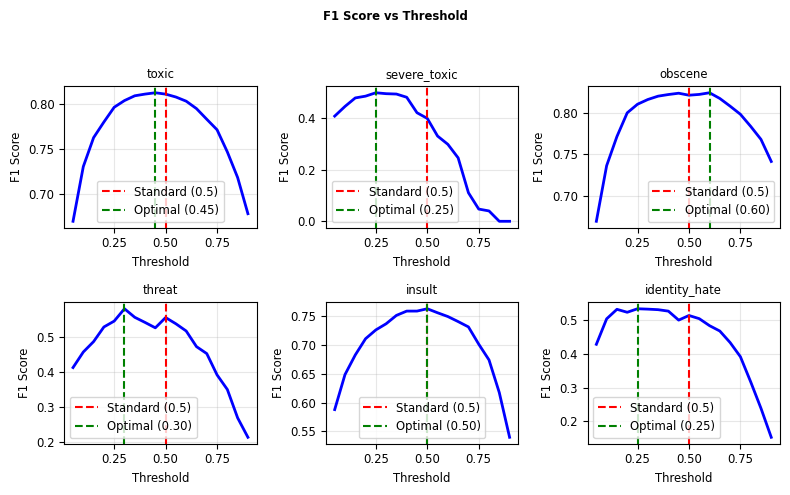


Total Thresholding


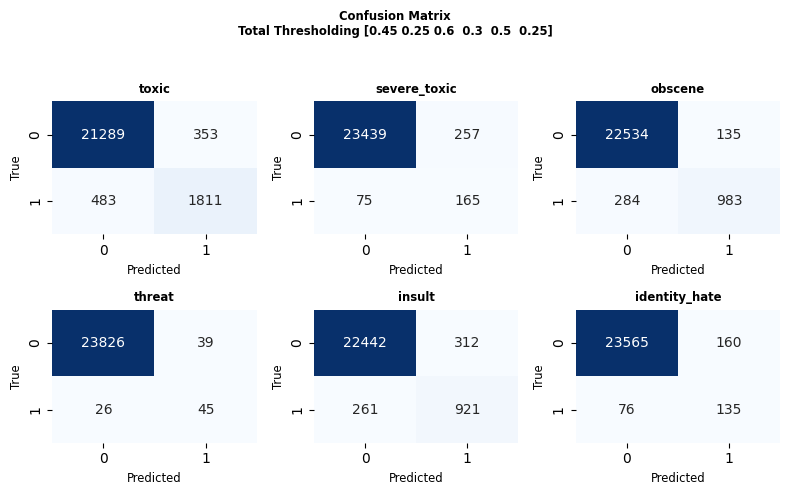

F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
thresh  0.668709  0.767413       0.985609       0.989195      0.676254   
std     0.643882  0.771299       0.985609       0.989195      0.676254   

        PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
thresh        0.8558      0.017136         0.921959  
std           0.8558      0.016112         0.925468

Label  Precision  Precision_std    Recall  Recall_std  F1-Score  \
0          toxic   0.836876       0.858325  0.789451    0.768527  0.812472   
1   severe_toxic   0.390995       0.479532  0.687500    0.341667  0.498489   
2        obscene   0.879249       0.849789  0.775848    0.794791  0.824319   
3         threat   0.535714       0.636364  0.633803    0.492958  0.580645   
4         insult   0.746959       0.746959  0.779188    0.779188  0.762733   
5  identity_hate   0.457627       0.606452  0.639810    0.445498  0.533597   

   F1-Score_std   ROC-AUC  ROC-AUC_std    PR-AUC  PR-AUC_std  
0      0.810948  0.981271     0.981271  0.898421    0.898421  
1      0.399027  0.989355     0.989355  0.431114    0.431114  
2      0.821370  0.987673     0.987673  0.895086    0.895086  
3      0.555556  0.984896     0.984896  0.490680    0.490680  
4      0.762733  0.985829     0.985829  0.813643    0.813643  
5      0.513661  0.984631     0.984631  0.528577    0.528577


Selective Thresholding


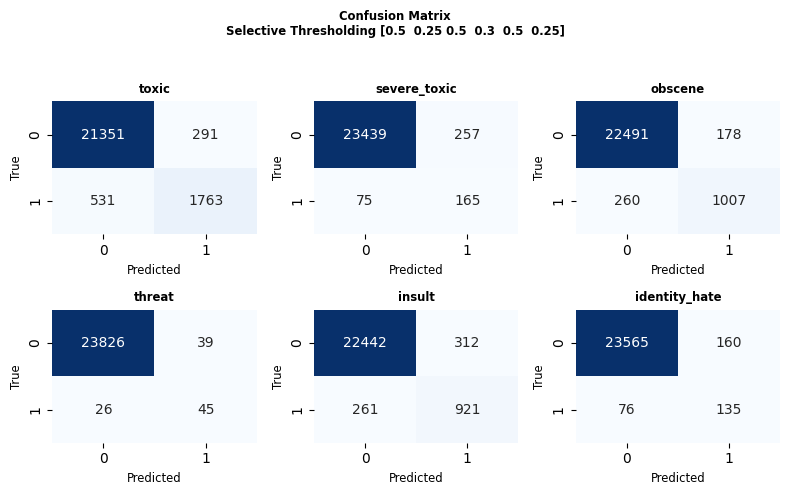

F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
thresh  0.667964  0.765990       0.985609       0.989195      0.676254   
std     0.643882  0.771299       0.985609       0.989195      0.676254   

        PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
thresh        0.8558      0.017171         0.922376  
std           0.8558      0.016112         0.925468

Label  Precision  Precision_std    Recall  Recall_std  F1-Score  \
0          toxic   0.858325       0.858325  0.768527    0.768527  0.810948   
1   severe_toxic   0.390995       0.479532  0.687500    0.341667  0.498489   
2        obscene   0.849789       0.849789  0.794791    0.794791  0.821370   
3         threat   0.535714       0.636364  0.633803    0.492958  0.580645   
4         insult   0.746959       0.746959  0.779188    0.779188  0.762733   
5  identity_hate   0.457627       0.606452  0.639810    0.445498  0.533597   

   F1-Score_std   ROC-AUC  ROC-AUC_std    PR-AUC  PR-AUC_std  
0      0.810948  0.981271     0.981271  0.898421    0.898421  
1      0.399027  0.989355     0.989355  0.431114    0.431114  
2      0.821370  0.987673     0.987673  0.895086    0.895086  
3      0.555556  0.984896     0.984896  0.490680    0.490680  
4      0.762733  0.985829     0.985829  0.813643    0.813643  
5      0.513661  0.984631     0.984631  0.528577    0.528577

(array([0.45, 0.25, 0.6 , 0.3 , 0.5 , 0.25]),
 array([0.5 , 0.25, 0.5 , 0.3 , 0.5 , 0.25]))

In [191]:
mod_7_bilstm_reg = [el for el in all_results if el['model_name']=='model_7_BiLSTM_Reg']
threshold_analysis(mod_7_bilstm_reg[0])


THRESHOLD ANALYSIS: model_10_BiGRU_Reg

toxic: threshold=0.50, F1=0.811
severe_toxic: threshold=0.25, F1=0.509
obscene: threshold=0.45, F1=0.824
threat: threshold=0.30, F1=0.617
insult: threshold=0.45, F1=0.757
identity_hate: threshold=0.15, F1=0.561
F1-Macro = 0.6800000071525574


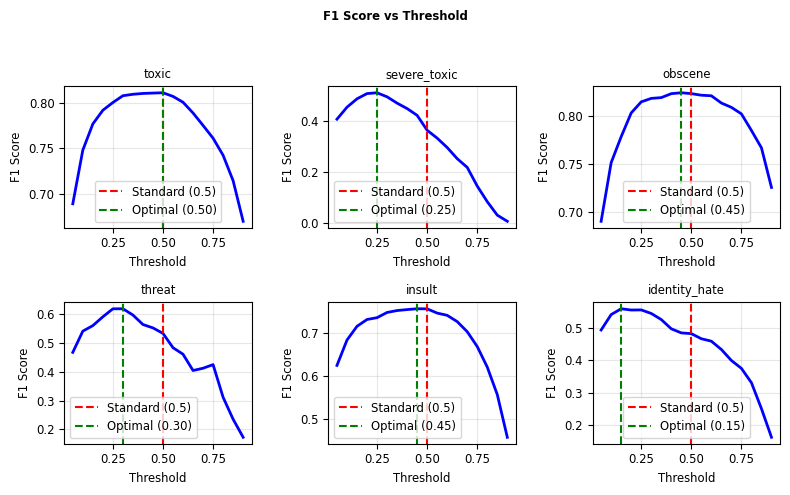


Total Thresholding


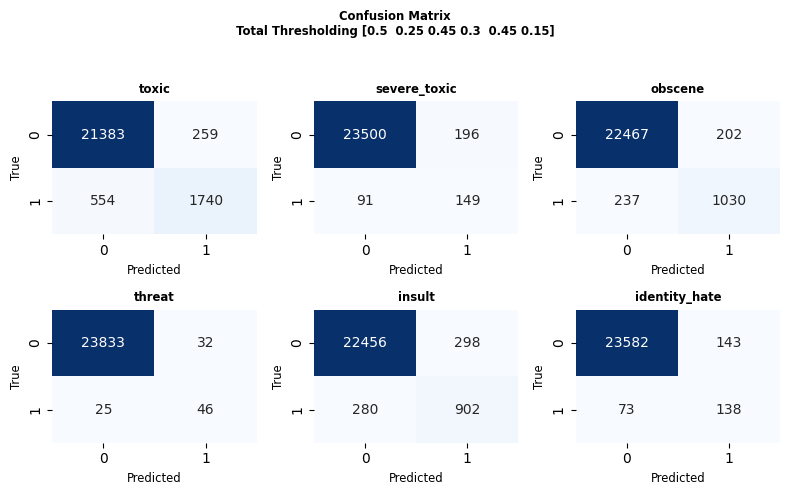

F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
thresh  0.680021  0.770192       0.985002       0.989005      0.688124   
std     0.628366  0.769138       0.985002       0.989005      0.688124   

        PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
thresh       0.85898      0.016642         0.924423  
std          0.85898      0.015938         0.925886

Label  Precision  Precision_std    Recall  Recall_std  F1-Score  \
0          toxic   0.870435       0.870435  0.758500    0.758500  0.810622   
1   severe_toxic   0.431884       0.470199  0.620833    0.295833  0.509402   
2        obscene   0.836039       0.849706  0.812944    0.798737  0.824330   
3         threat   0.589744       0.622642  0.647887    0.464789  0.617450   
4         insult   0.751667       0.773852  0.763113    0.741117  0.757347   
5  identity_hate   0.491103       0.653226  0.654028    0.383886  0.560976   

   F1-Score_std   ROC-AUC  ROC-AUC_std    PR-AUC  PR-AUC_std  
0      0.810622  0.981160     0.981160  0.899913    0.899913  
1      0.363171  0.988903     0.988903  0.423280    0.423280  
2      0.823434  0.987159     0.987159  0.899405    0.899405  
3      0.532258  0.982775     0.982775  0.534537    0.534537  
4      0.757131  0.986262     0.986262  0.818939    0.818939  
5      0.483582  0.983756     0.983756  0.552667    0.552667


Selective Thresholding


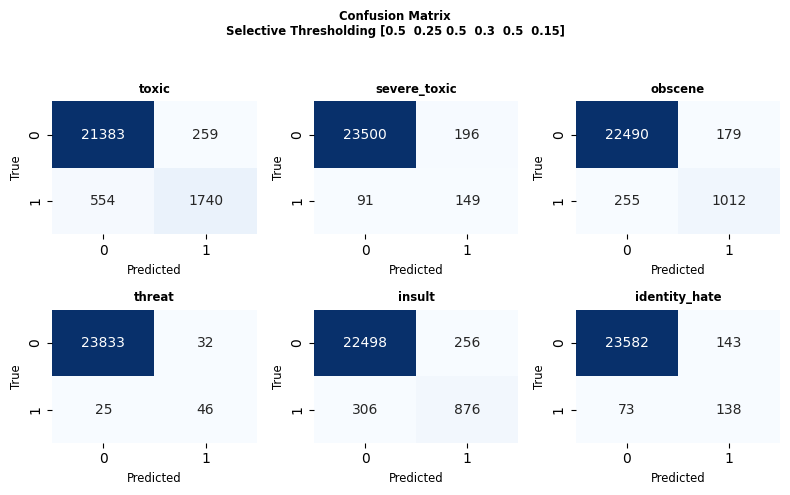

F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
thresh  0.679836  0.769799       0.985002       0.989005      0.688124   
std     0.628366  0.769138       0.985002       0.989005      0.688124   

        PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
thresh       0.85898      0.016495         0.924883  
std          0.85898      0.015938         0.925886

Label  Precision  Precision_std    Recall  Recall_std  F1-Score  \
0          toxic   0.870435       0.870435  0.758500    0.758500  0.810622   
1   severe_toxic   0.431884       0.470199  0.620833    0.295833  0.509402   
2        obscene   0.849706       0.849706  0.798737    0.798737  0.823434   
3         threat   0.589744       0.622642  0.647887    0.464789  0.617450   
4         insult   0.773852       0.773852  0.741117    0.741117  0.757131   
5  identity_hate   0.491103       0.653226  0.654028    0.383886  0.560976   

   F1-Score_std   ROC-AUC  ROC-AUC_std    PR-AUC  PR-AUC_std  
0      0.810622  0.981160     0.981160  0.899913    0.899913  
1      0.363171  0.988903     0.988903  0.423280    0.423280  
2      0.823434  0.987159     0.987159  0.899405    0.899405  
3      0.532258  0.982775     0.982775  0.534537    0.534537  
4      0.757131  0.986262     0.986262  0.818939    0.818939  
5      0.483582  0.983756     0.983756  0.552667    0.552667

(array([0.5 , 0.25, 0.45, 0.3 , 0.45, 0.15]),
 array([0.5 , 0.25, 0.5 , 0.3 , 0.5 , 0.15]))

In [193]:
mod_10_bigru_reg = [el for el in all_results if el['model_name']=='model_10_BiGRU_Reg']
threshold_analysis(mod_10_bigru_reg[0])

💡 **Observation** 

The threshold analysis showed that with appropriate theshold levels the metrics we have to consier rump up for the Bidirectional GRU. We see a good increase in the F1 Macro with a slight decrease of hamming loss, both metrics better than the Bidirectional LSTM (even with thresholding optimization).

From the *confusion matrix* looking at the rare labels (severe_toxic, threat, identity_hate) we copmpare TP, FN, FP:
- BiLSTM:
    - severe_toxic from [82, 89, 158] to (optimization) -> [165, 257, 75]
    - threat form [35, 20, 36]  to (optimization) -> [45, 39, 26]
    - identity_hate form [94, 61, 117]  to (optimization) -> [135, 160, 76]

- BiGRU:
    - severe_toxic from [71, 80, 169] to (optimization) -> [149, 196, 91] 
    - threat form [33, 20, 38] to (optimization) -> [46, 32, 25]
    - identity_hate form [81, 43, 130]  to (optimization) -> [138, 143, 73]

In both models the optimization allow a better scan of true positives and a decrease of false positive for each label. 

The best model choosen for production is the Bideirectional GRU model with regularization with optimized threshold because gets better overll metrics has less overfitting and less hamming loss.

About the threshold optimization I'm going to change the values just for the rare labels and stay with 0.5 with the others to not have to much polirization in the binary predicton.

# Test set evaluation

In [208]:
CURRENT_DIR = r"C:\Users\Tia\Desktop\ProfessionAI\Progetti\data-science-portfolio\[Data Science] anti-hater-filter"

In [205]:
config = {
    'max_len': MAX_LEN,
    'rnn_units': 64,
    'loss_name': 'bce',
    'bidirectional': True,
    'emb_dr': 0.2,             
    'rnn_dr': 0.2,            
    'recurrent_dr': 0.0,       
    'pre_output_dr': 0.3,      
    'learning_rate': 0.001,
}

In [206]:
model_path = CURRENT_DIR + r'\models\model_10_BiGRU_Reg_weights.h5'
optimal_thresholds = [0.5 , 0.25, 0.5 , 0.3 , 0.5 , 0.15]
model_test = build_gru(config=config, embedding_matrix=embedding_matrix)
model_test.load_weights(model_path)

F1_Macro  F1_Micro  ROC_AUC_Macro  ROC_AUC_Micro  PR_AUC_Macro  \
0  0.681044  0.772325       0.987943       0.990021      0.713895   

   PR_AUC_Micro  Hamming_Loss  Subset_Accuracy  
0      0.861543      0.016314         0.924173

Label  Precision    Recall  F1-Score   ROC-AUC    PR-AUC
0          toxic   0.875000  0.753705  0.809836  0.981354  0.897476
1   severe_toxic   0.447802  0.682008  0.540630  0.990783  0.481695
2        obscene   0.850820  0.818612  0.834405  0.989208  0.908408
3         threat   0.575342  0.583333  0.579310  0.995201  0.580068
4         insult   0.770740  0.731583  0.750652  0.985767  0.821533
5  identity_hate   0.507353  0.654028  0.571429  0.985342  0.594192

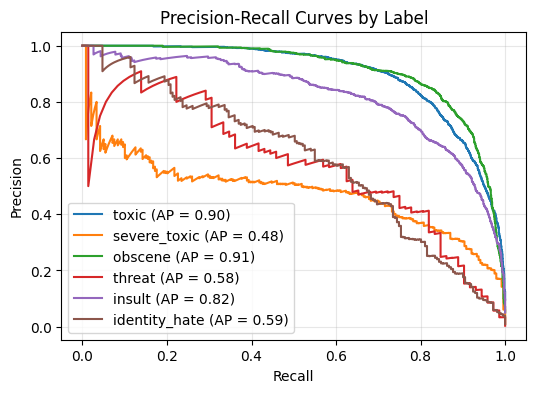

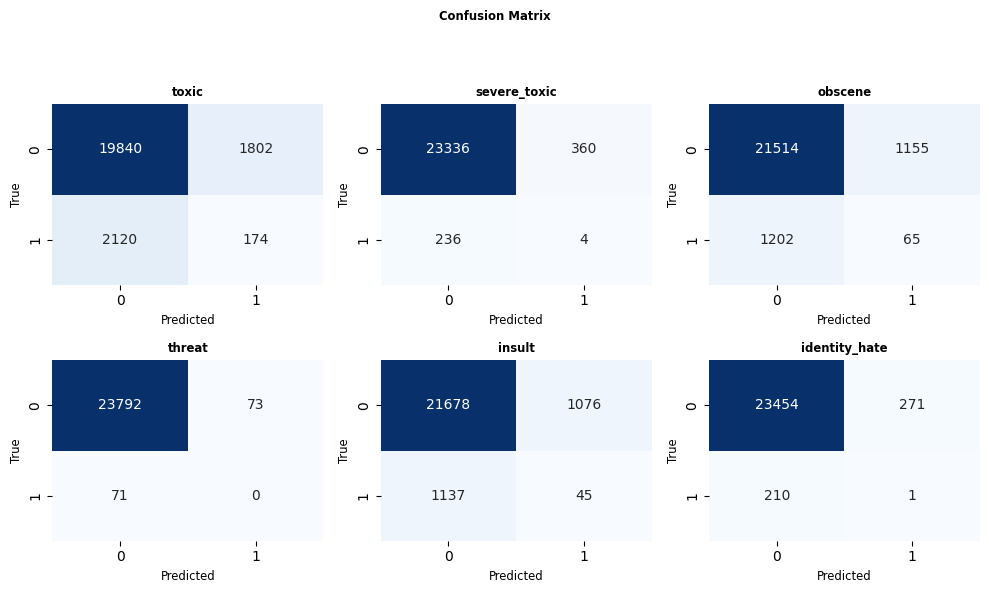

{'f1_macro': 0.6810436527072818,
 'f1_micro': 0.7723253328150811,
 'precision_macro': 0.6711762812018573,
 'precision_micro': 0.7906884202148826,
 'recall_macro': 0.7038784745085471,
 'recall_micro': 0.7547958214624881,
 'roc_auc_macro': 0.9879426643497254,
 'roc_auc_micro': 0.9900205666934253,
 'pr_auc_macro': 0.7138953111459444,
 'pr_auc_micro': 0.8615434308465659,
 'hamming_loss': 0.01631433823529412,
 'subset_accuracy': 0.9241727941176471,
 'f1_per_label': [0.8098360655737705,
  0.5406301824212272,
  0.8344051446945338,
  0.5793103448275863,
  0.7506516072980017,
  0.5714285714285714],
 'precision_per_label': [0.875,
  0.4478021978021978,
  0.8508196721311475,
  0.5753424657534246,
  0.7707404103479036,
  0.5073529411764706],
 'recall_per_label': [0.7537053182214473,
  0.6820083682008368,
  0.8186119873817035,
  0.5833333333333334,
  0.7315834038950042,
  0.6540284360189573],
 'roc_auc_per_label': [0.981354307436209,
  0.9907833963058369,
  0.9892079205027278,
  0.9952011048720527,

In [207]:
evaluate_model(model_test, X_test_seq, y_test, threshold=optimal_thresholds, label_names=LABEL_NAMES)

# Conclusions

The evaluation on test set mantain the metrics stable as in validation. A point must be made on the values of the confusion matrix that are almost zero the True Positive in the rare labels.

At conclusion the model has good performances but could benefit form more tuning ant model testing with:
- different dorpout configuration (to overcame overfitting seen between validatoin and test)
- add of other layers RNN or Dense in the final part of the network
- test other auxiuliary feature more correlated with the labels